# Preamble 

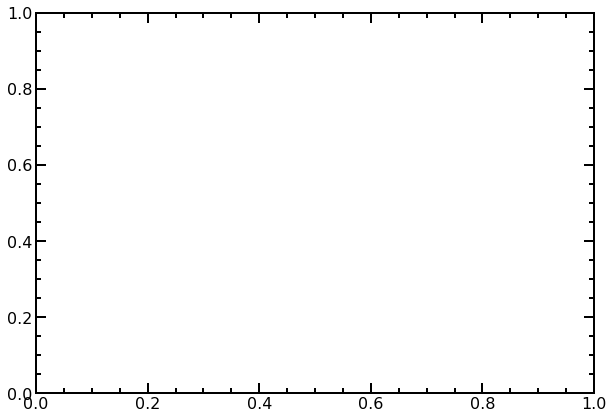

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from qutip import*
from scipy.special import eval_hermite as hpoly
from scipy.optimize import minimize
import sys
#here, configure the path to the directory for pre-defined functions.
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_pshapes as pshapes
from Fluxonium_hamiltonians import qchard_evolgates as gates
from Fluxonium_hamiltonians import qchard_rotope as op
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
%load_ext autoreload
%autoreload 2

In [24]:
savefig = True
from matplotlib import rcParams
if savefig == True:
    rcParams['font.family'] = 'serif'
    rcParams['font.serif'] = ['Times New Roman']
else:
    rcParams['font.family'] = 'sans-serif'
    rcParams['font.serif'] = ['Arial']
    
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/'

In [43]:
#Device parameters
nlev_lc = 30
nlev_single = 5  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L = 1  # inductive energy
    E_C = 1.0  # charging energy
    E_J = 4  # Josephson energy
    phi_ext = np.pi  # external phase shift

qubit = fluxonium.Fluxonium(E_J=E_J, E_C=E_C, E_L=E_L, phi_ext=phi_ext, nlev = nlev_single, nlev_lc = nlev_lc)

#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

comp_space = [0,1]
omega_d = qubit.freq(0,1) + delta_omega_d

# Charge driving

In [44]:
matr_el = np.abs(qubit.n_ij(0,1))
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

state_0 = basis(nlev_single, 0)
state_1 = basis(nlev_single, 1)
state_2 = basis(nlev_single, 2)
state_3 = basis(nlev_single, 3)

99.22634848666043


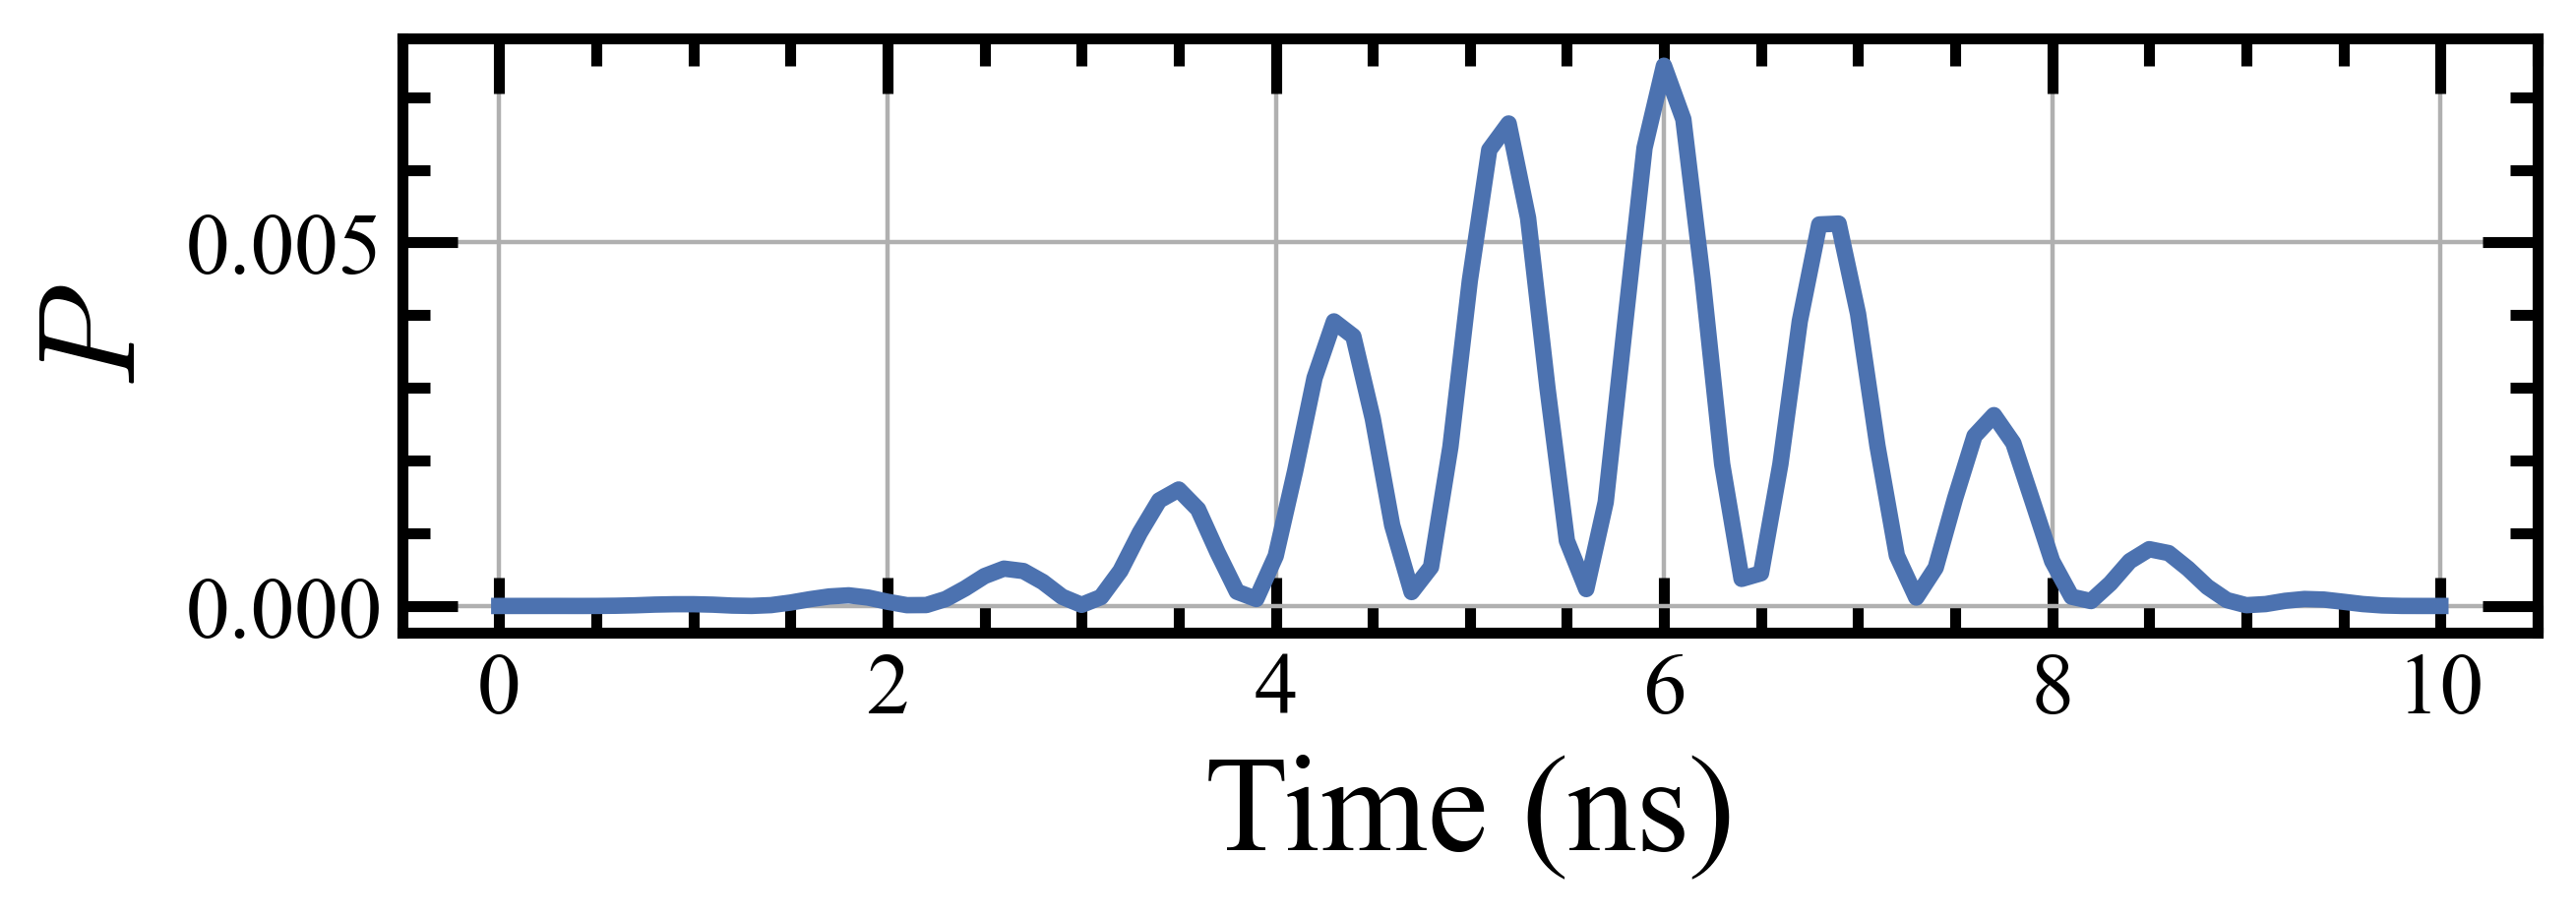

In [45]:

#Fidelity
U_ideal = qeye(2)
U_ideal = sigmay()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel*100)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
leakage_charge = 1 - trans_prob_0 - trans_prob_1

plt.figure(figsize = [7,2])
# plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
# plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
# plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
# plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.plot(t_points, leakage_charge)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
# plt.legend()
plt.grid()
# plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

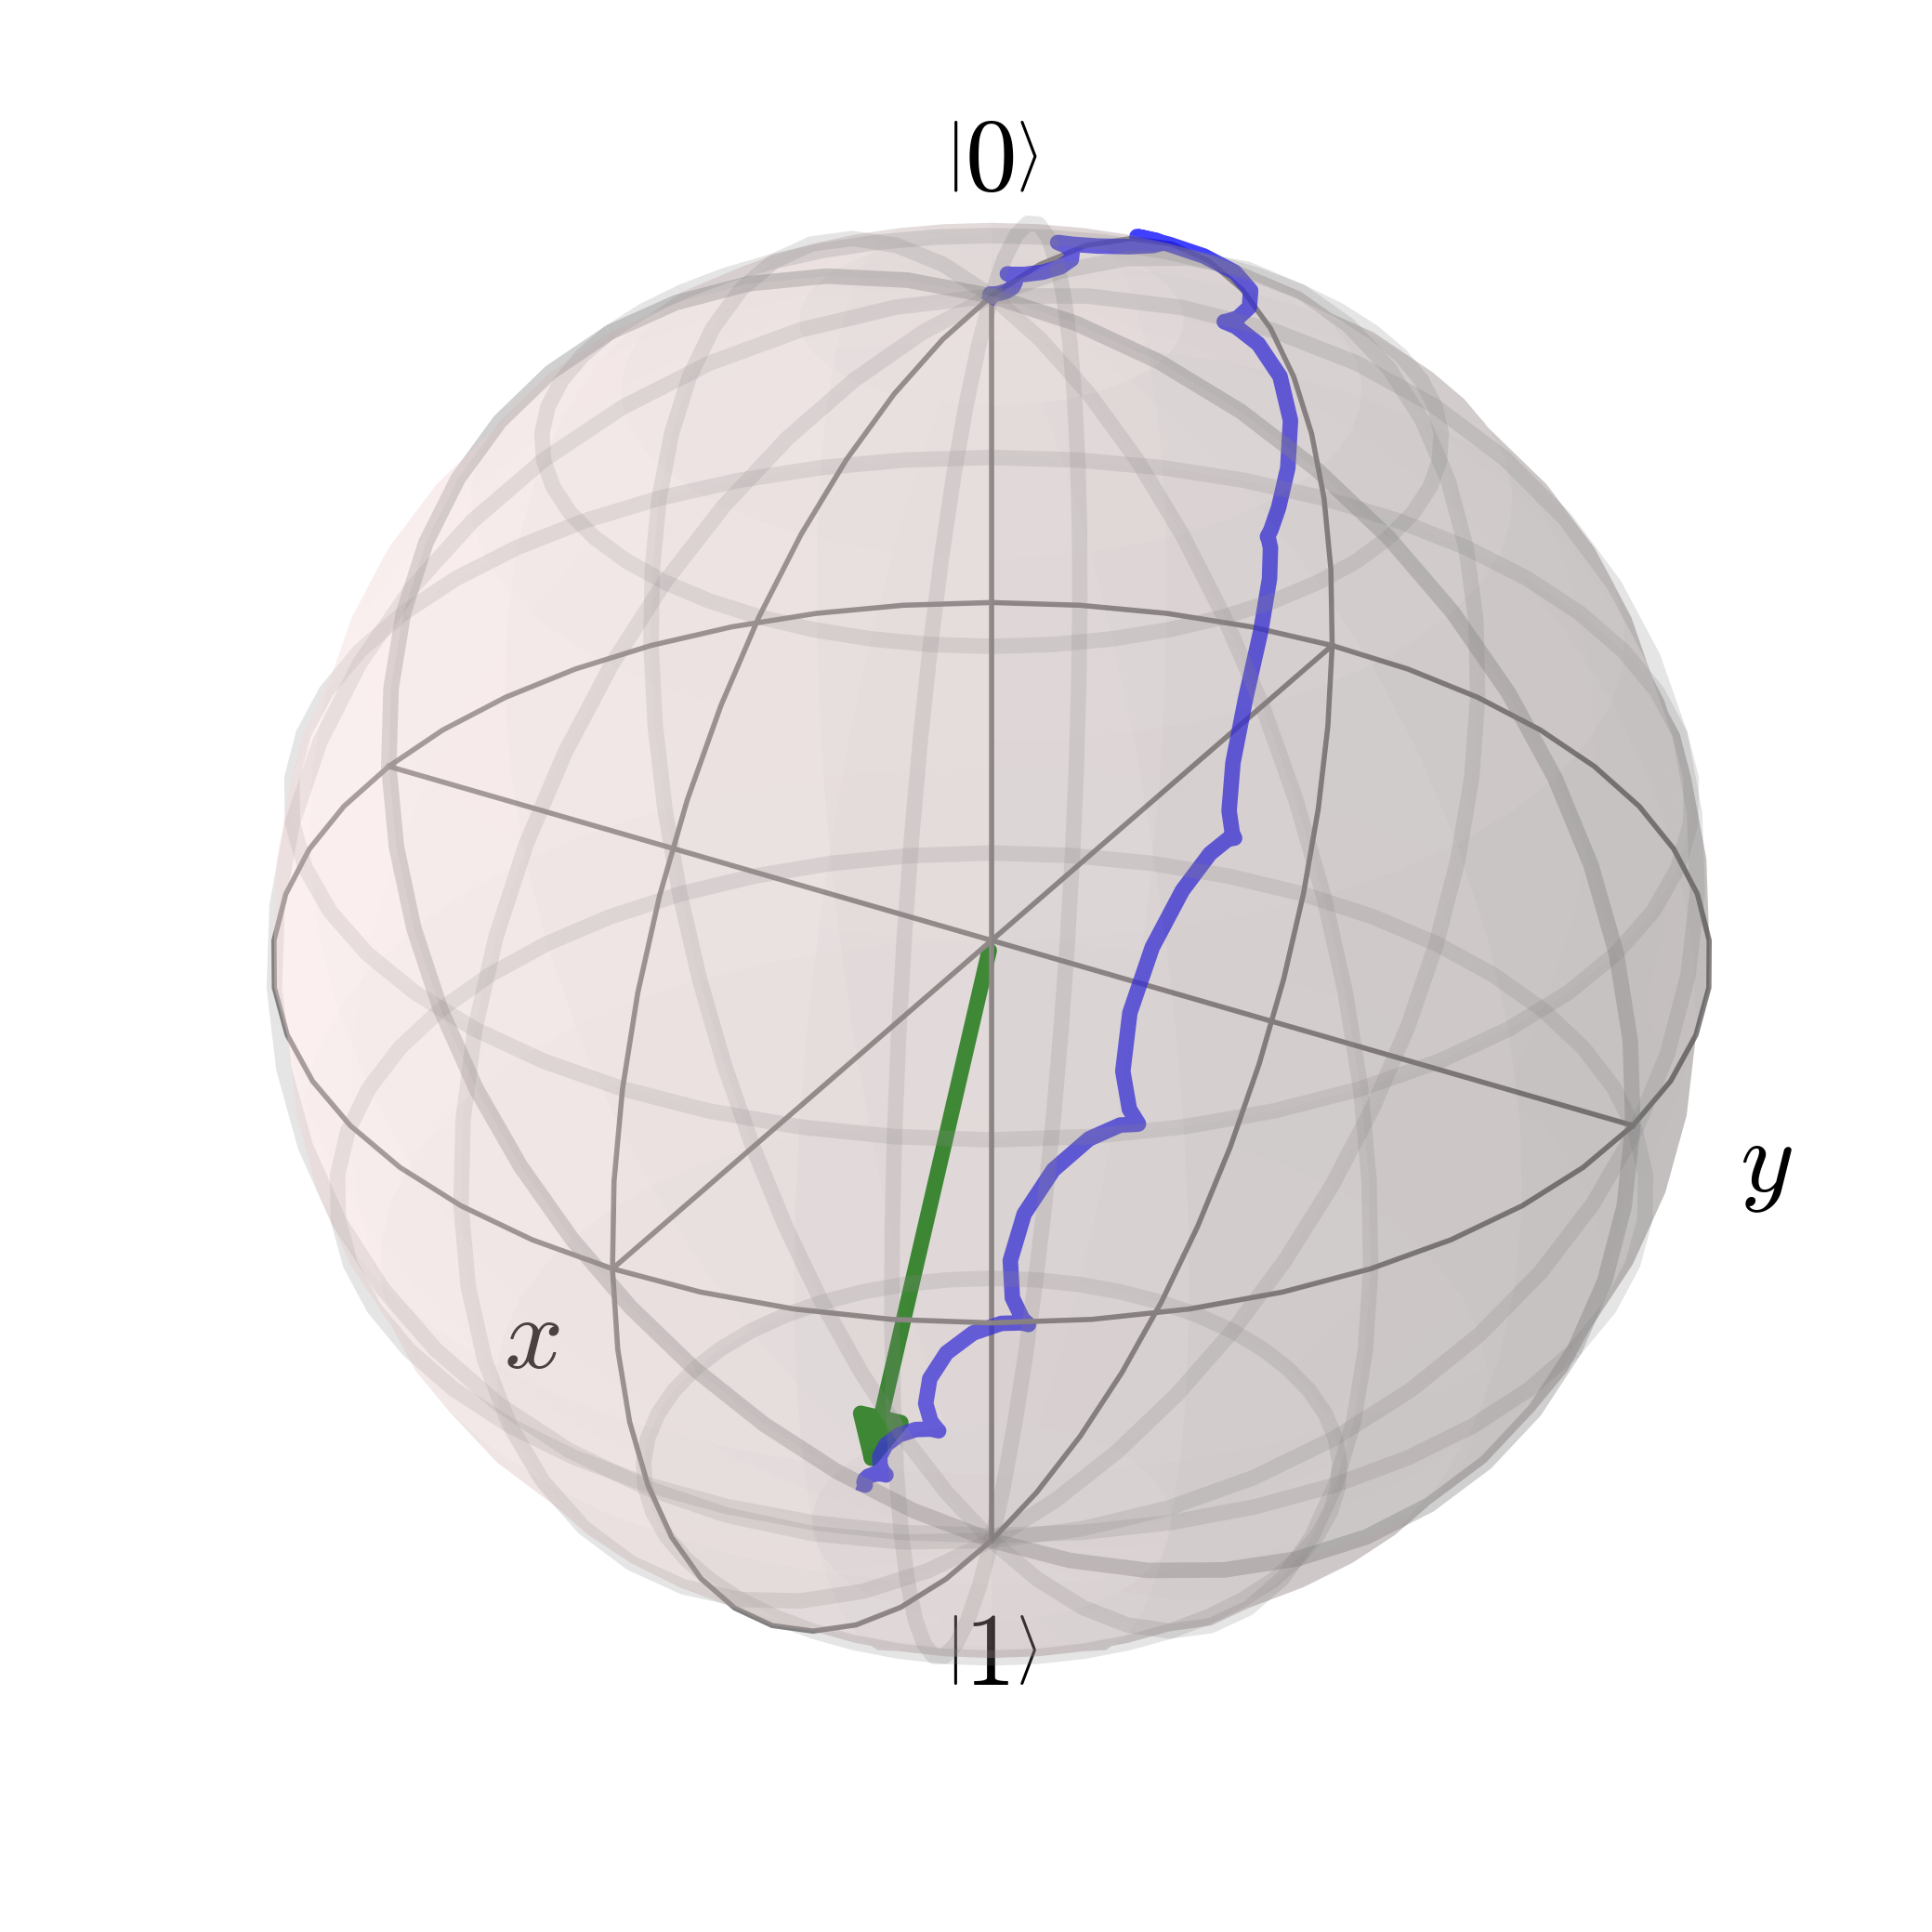

In [7]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()


In [66]:
# What is the frequency of 0-1?
print (qubit.level(1)-qubit.level(0))

0.23721751544503178


## Optimization
### Sweep DRAG

In [67]:
drag_coeff_array = np.linspace(-1,1,201)
error_array_DRAG_charge = np.zeros_like(drag_coeff_array)
U_ideal = sigmay()
for idx, drag_coeff in enumerate(drag_coeff_array):
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = True, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array_DRAG_charge[idx] = 1 - fidel

Text(0.5, 0, 'DRAG coefficient')

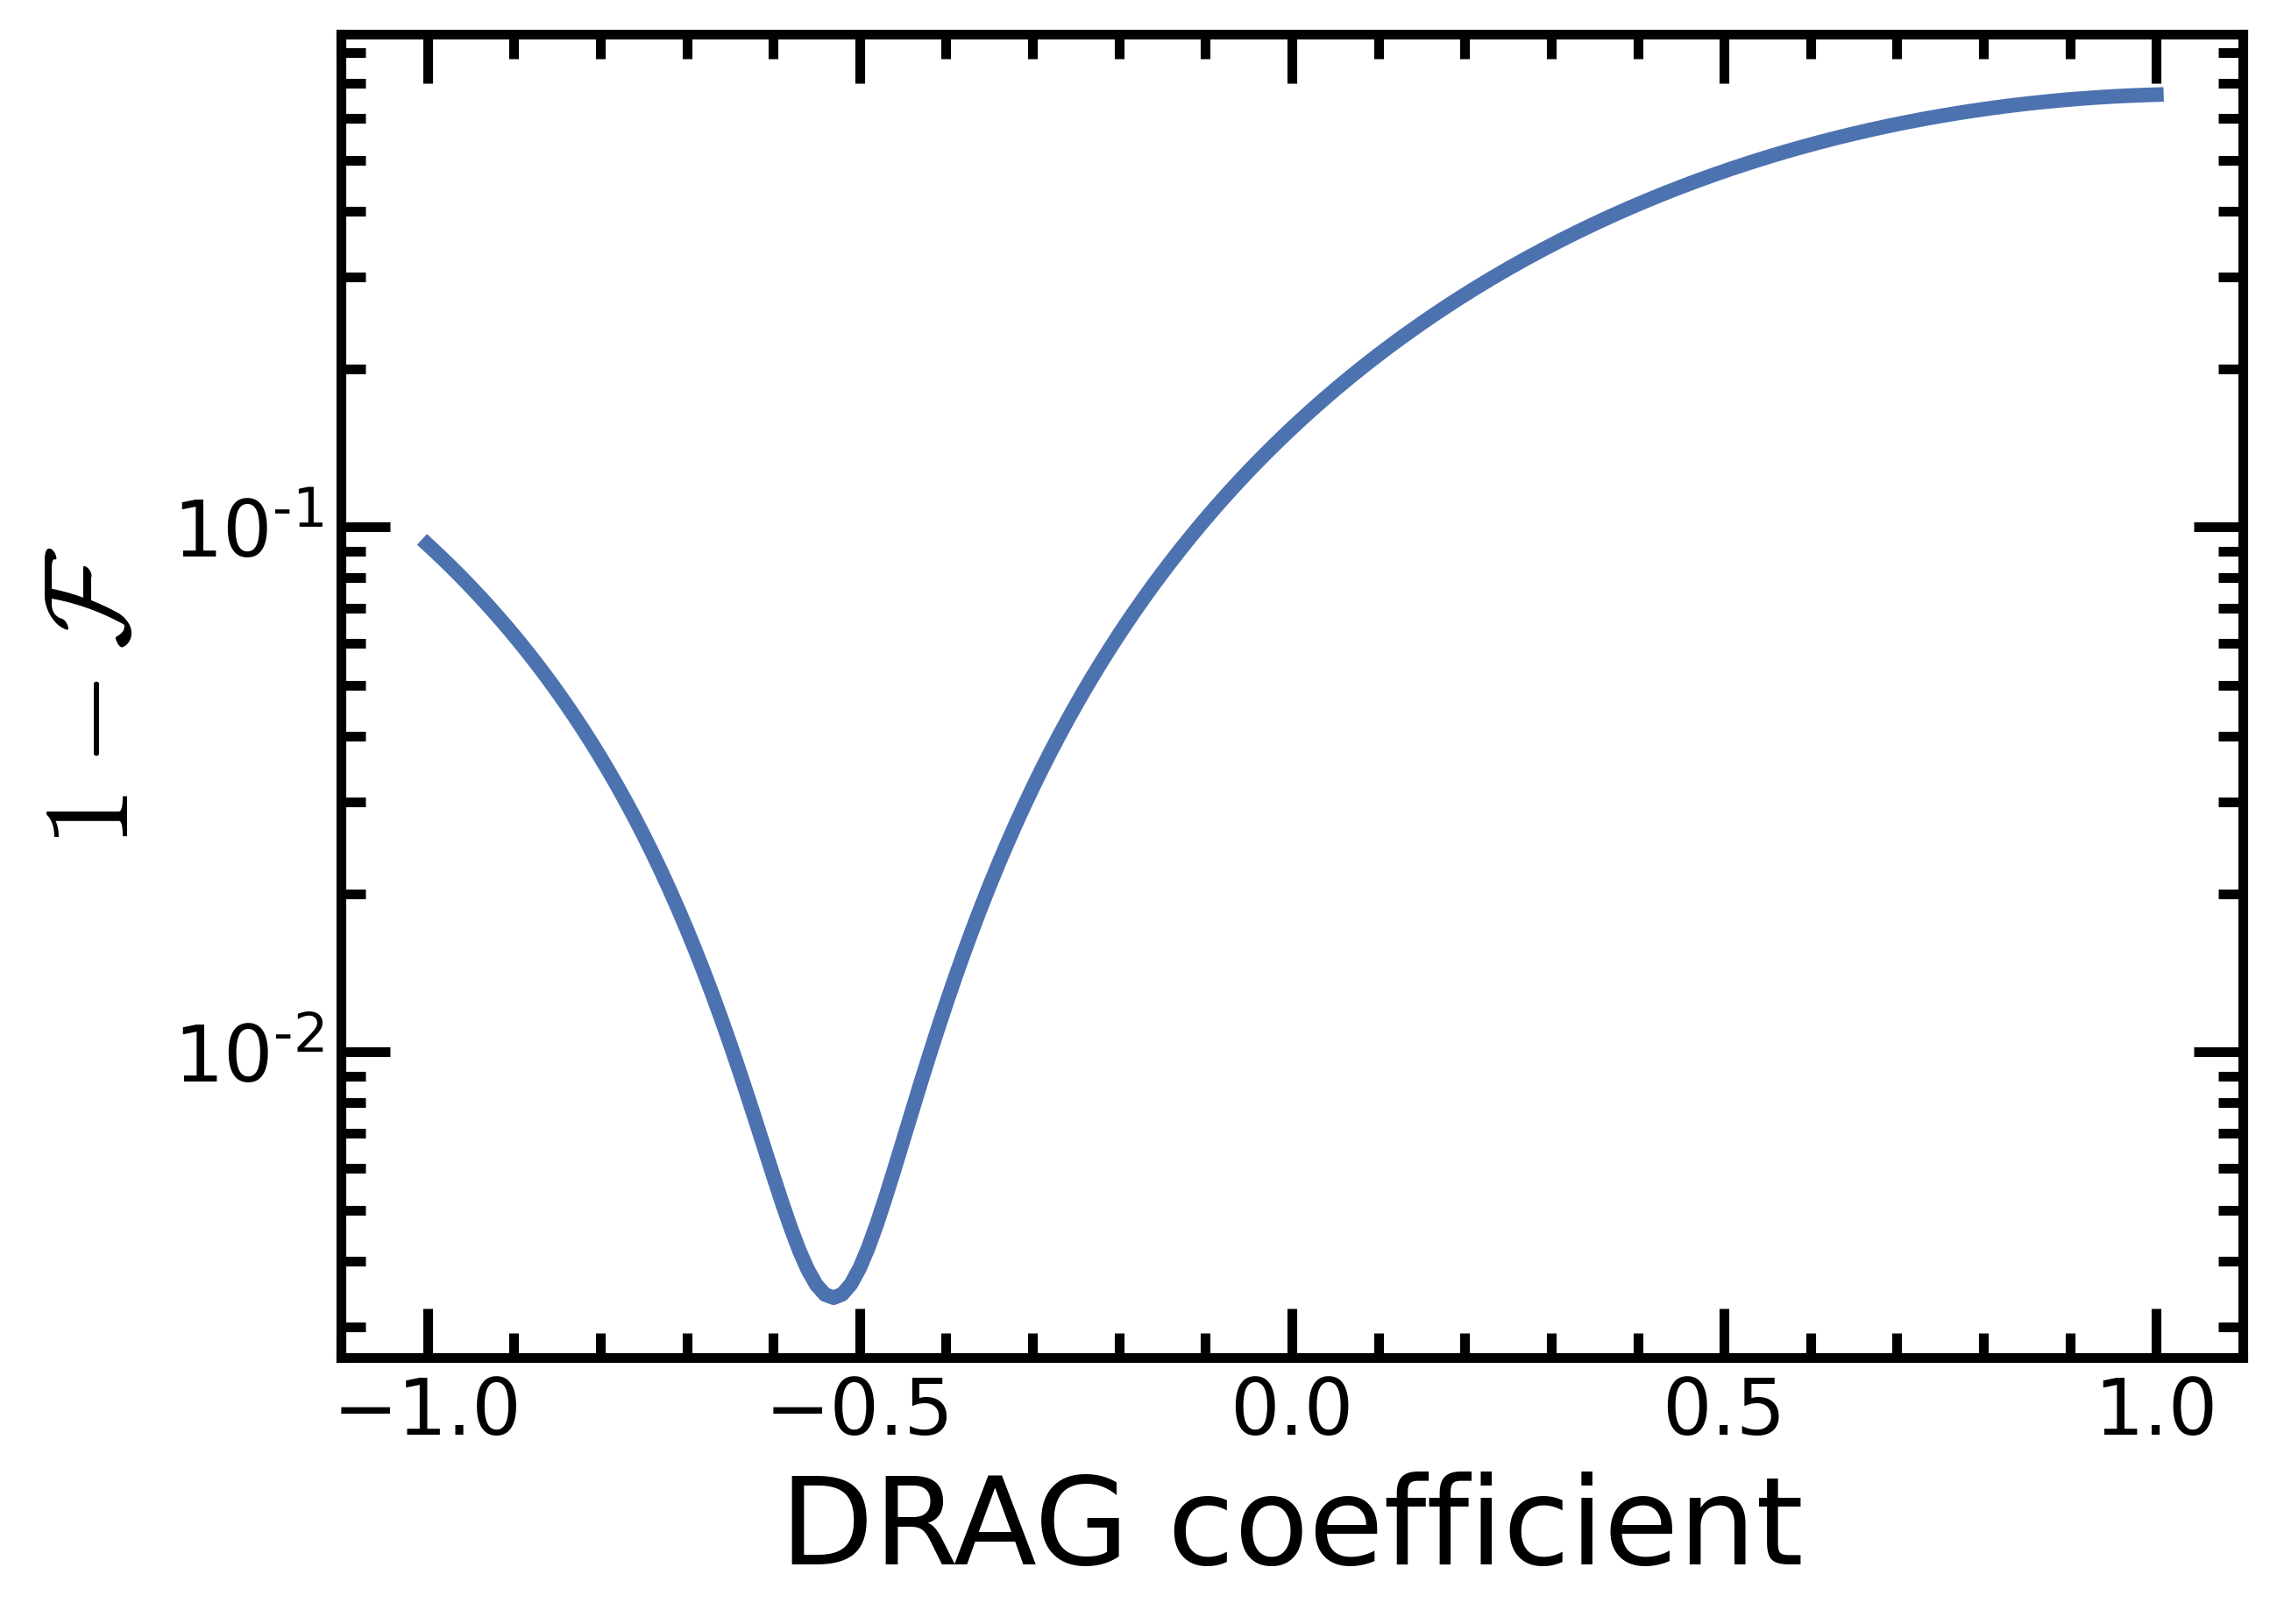

In [68]:
plt.figure(figsize=[7,5])
plt.semilogy(drag_coeff_array, error_array_DRAG_charge)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel('DRAG coefficient')

### Sweep detuning

In [71]:
drag_coeff = 0
delta_omega_d_array = np.linspace(-0.02,0.01,51)
error_array_detune_charge = np.zeros_like(delta_omega_d_array)
for idx, delta_omega_d in enumerate(delta_omega_d_array):
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    error_array_detune_charge[idx] = 1 - fidel

-0.009200000000000002


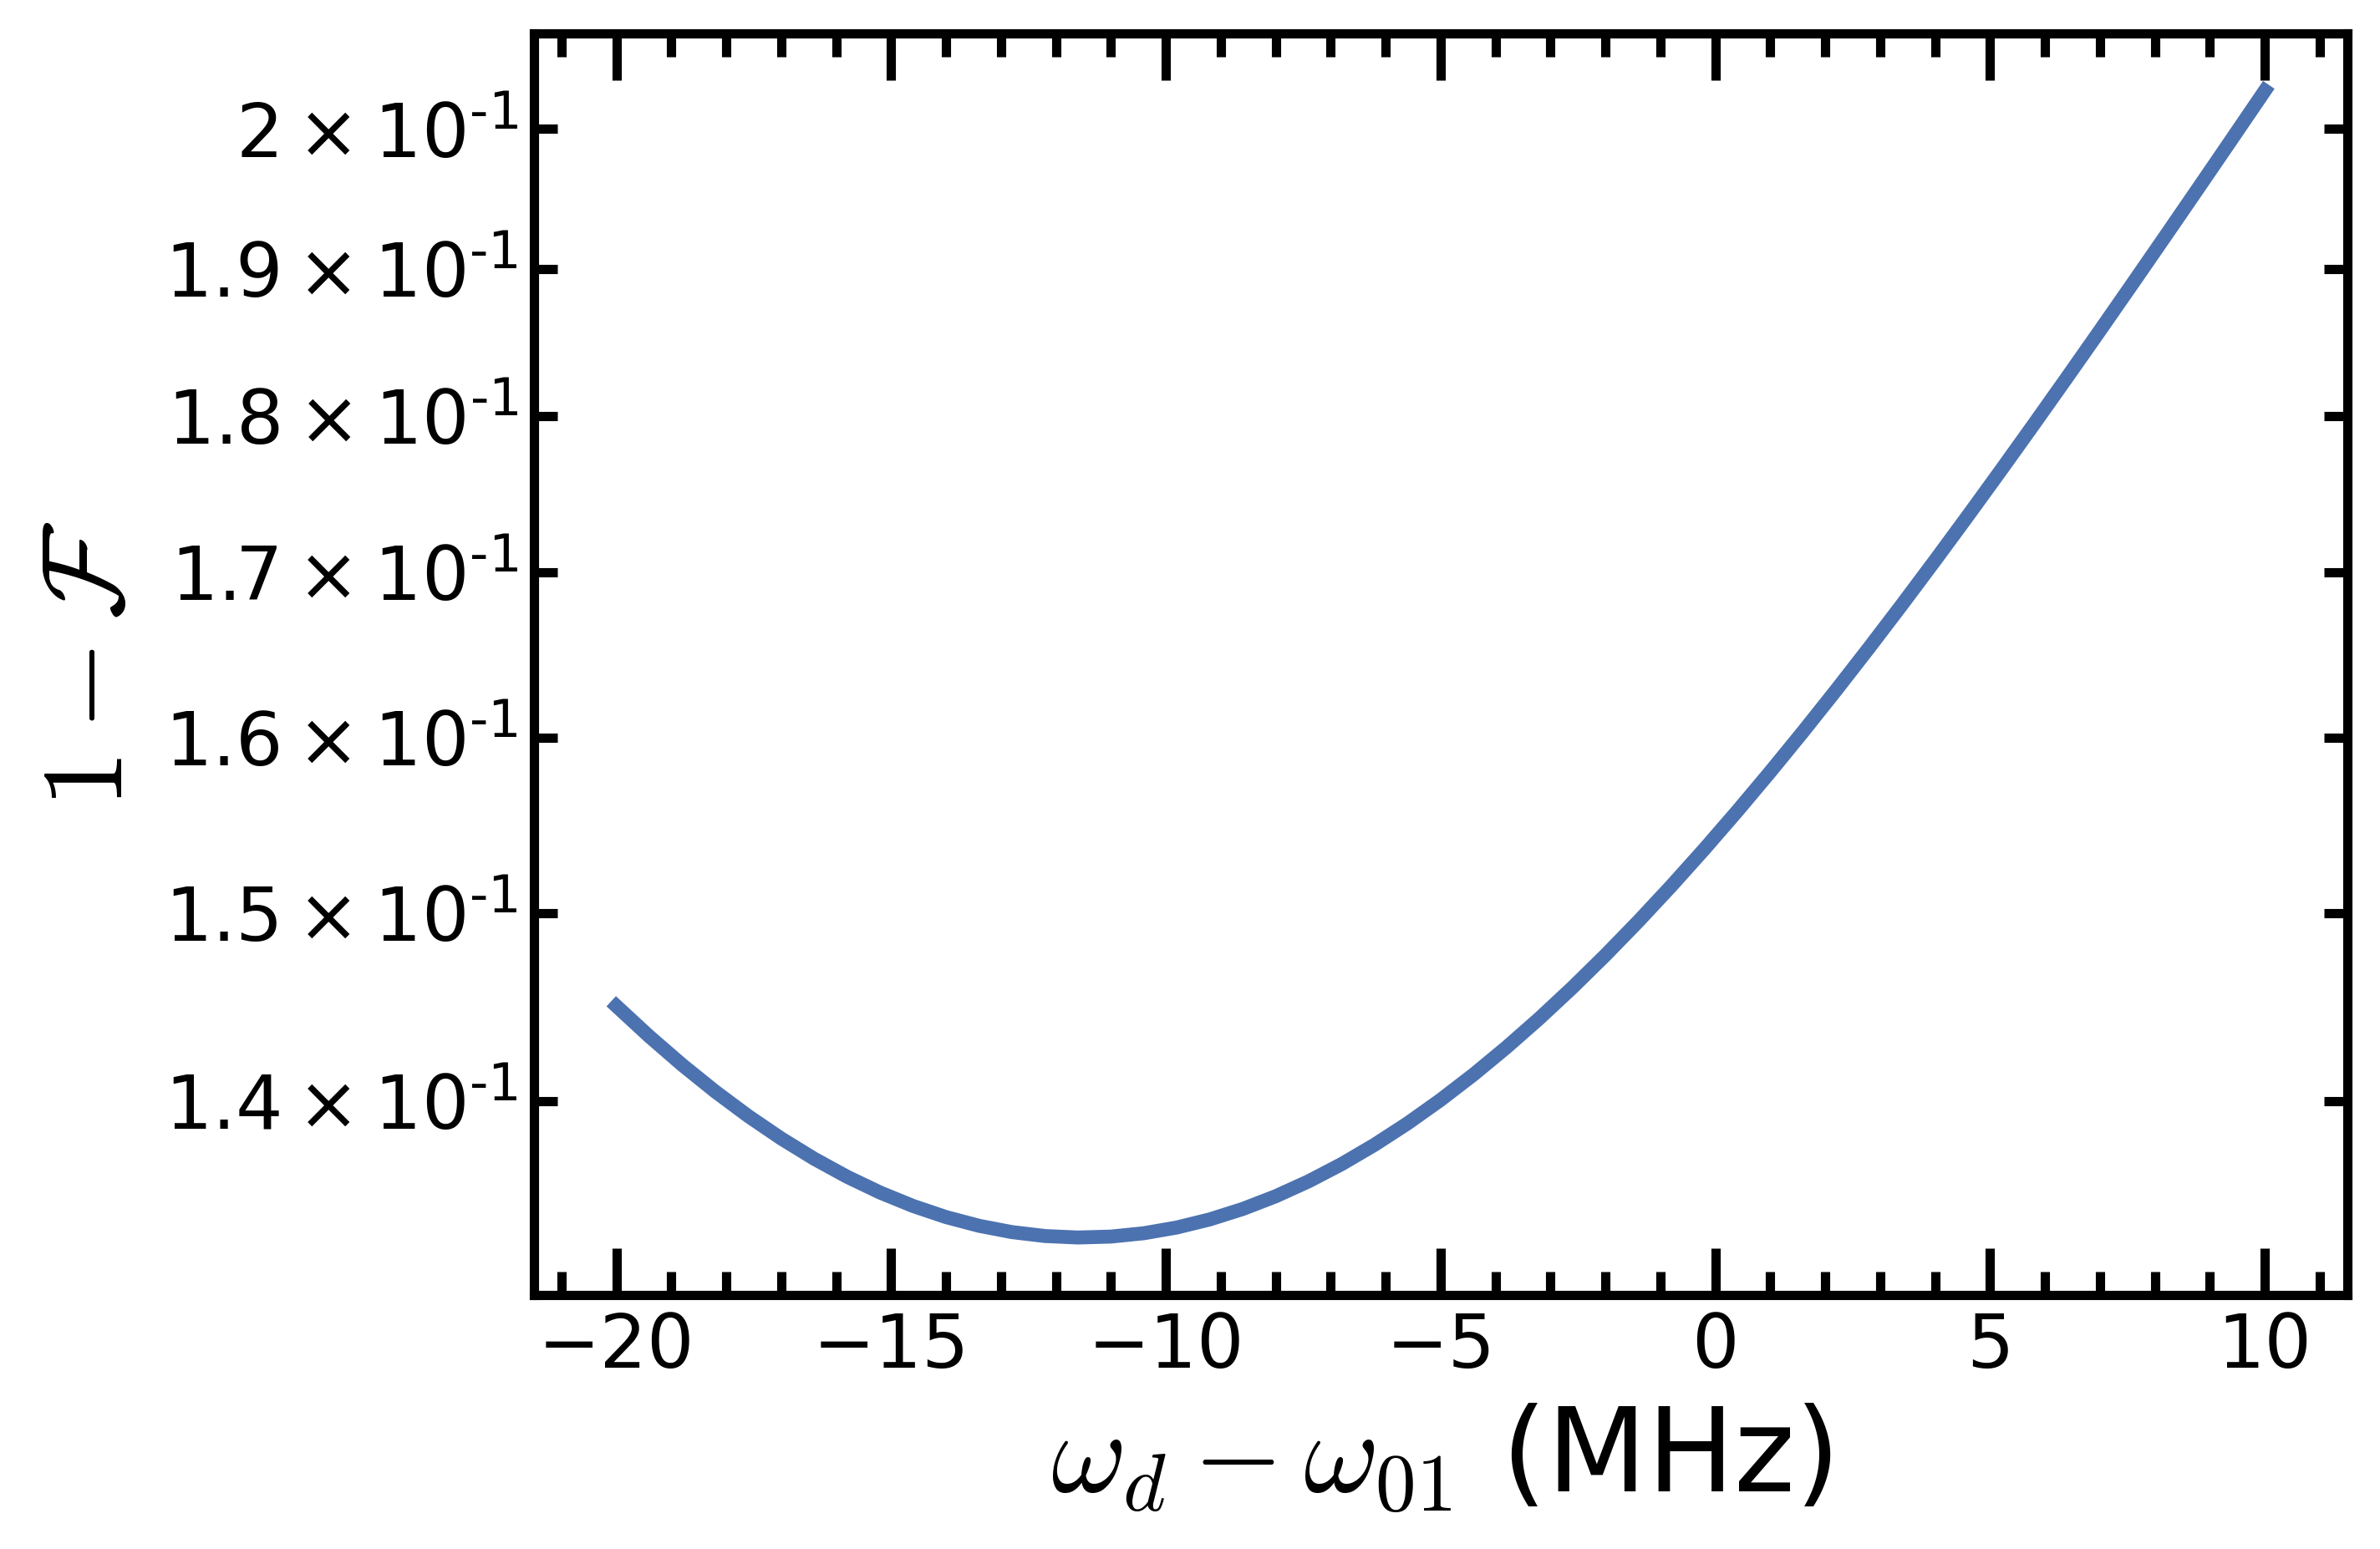

In [72]:
plt.figure(figsize=[7,5])
plt.semilogy (delta_omega_d_array*1e3, error_array_detune_charge)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\omega_d - \omega_{01}$ (MHz)')
print (delta_omega_d_array[np.argmin(error_array)])

### Numerical optimization using both detuning and DRAG

In [51]:
def infidelity(x):
    delta_omega_d = x[0]
    drag_coeff = (x[1])
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return 1-fidel

x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
print (xopt.x)
print (infidelity(xopt.x))

[ 4.84838633e-05 -4.82263963e-01]
0.000146199258715618


0.000146199258715618


Text(0.5, 1.0, '$\\mathcal{F}=$0.999854')

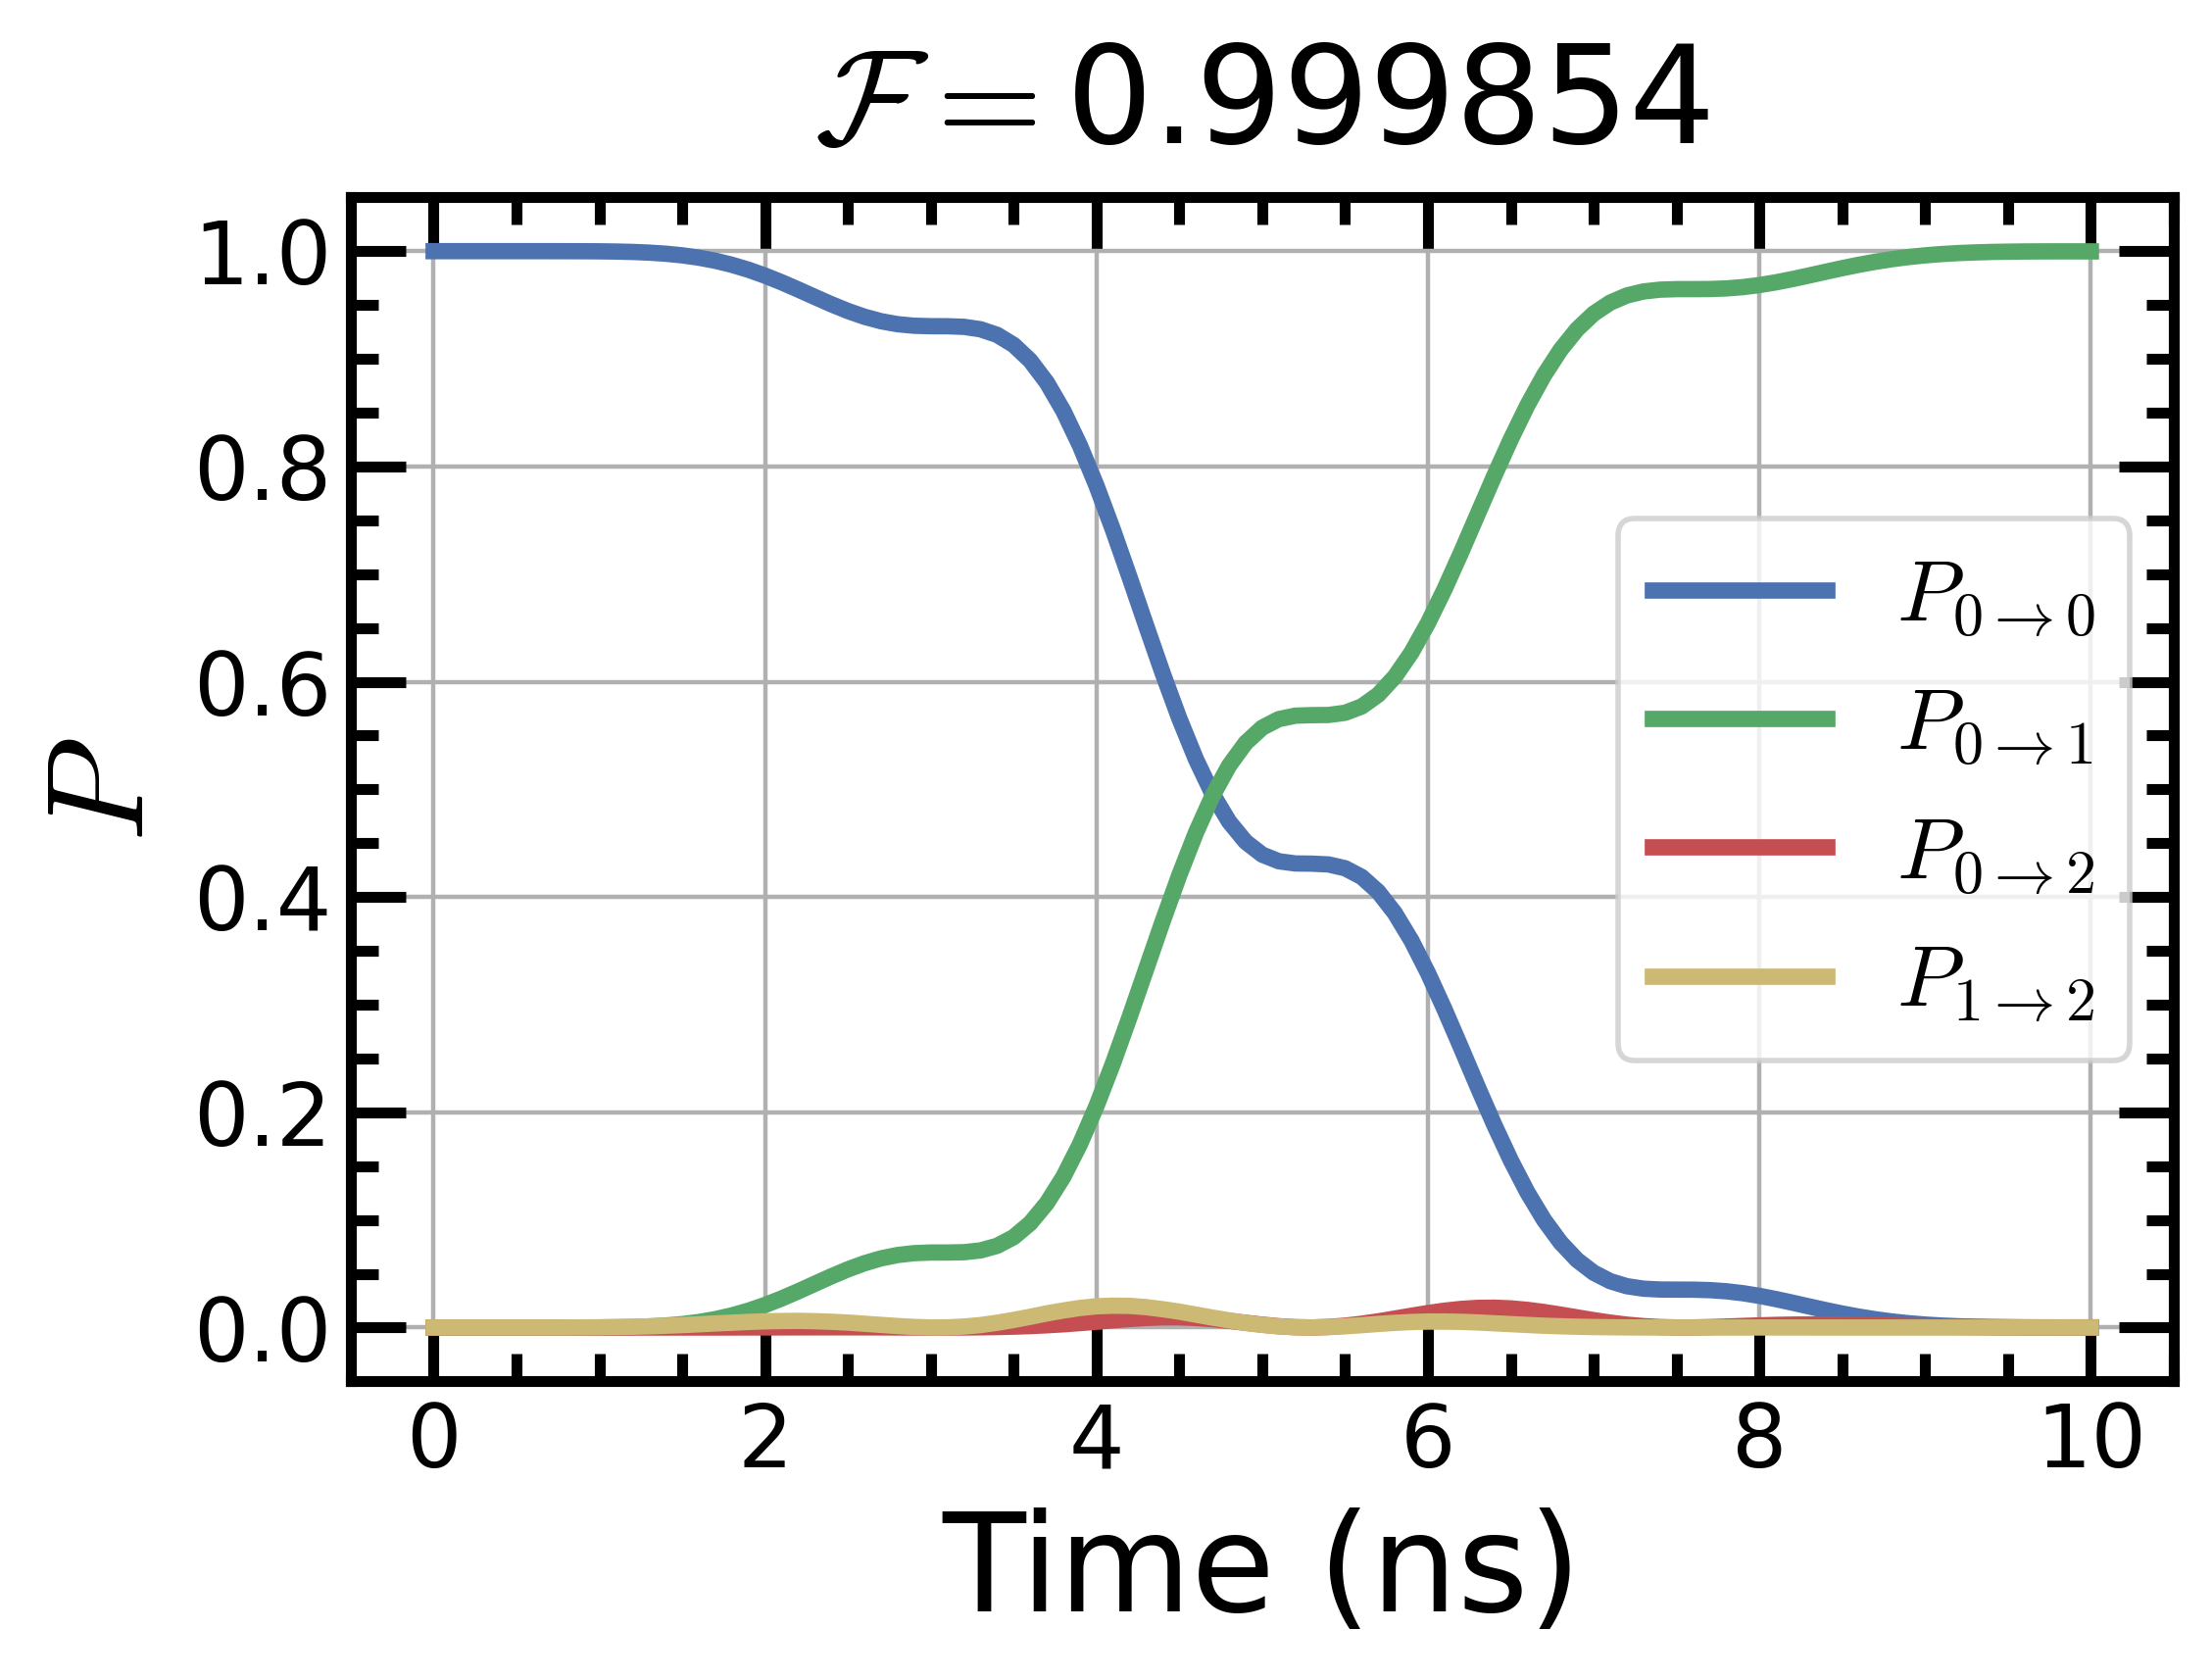

In [52]:
delta_omega_d=xopt.x[0]
drag_coeff = xopt.x[1]
omega_d = qubit.freq(0,1) + delta_omega_d
U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(1-fidel)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

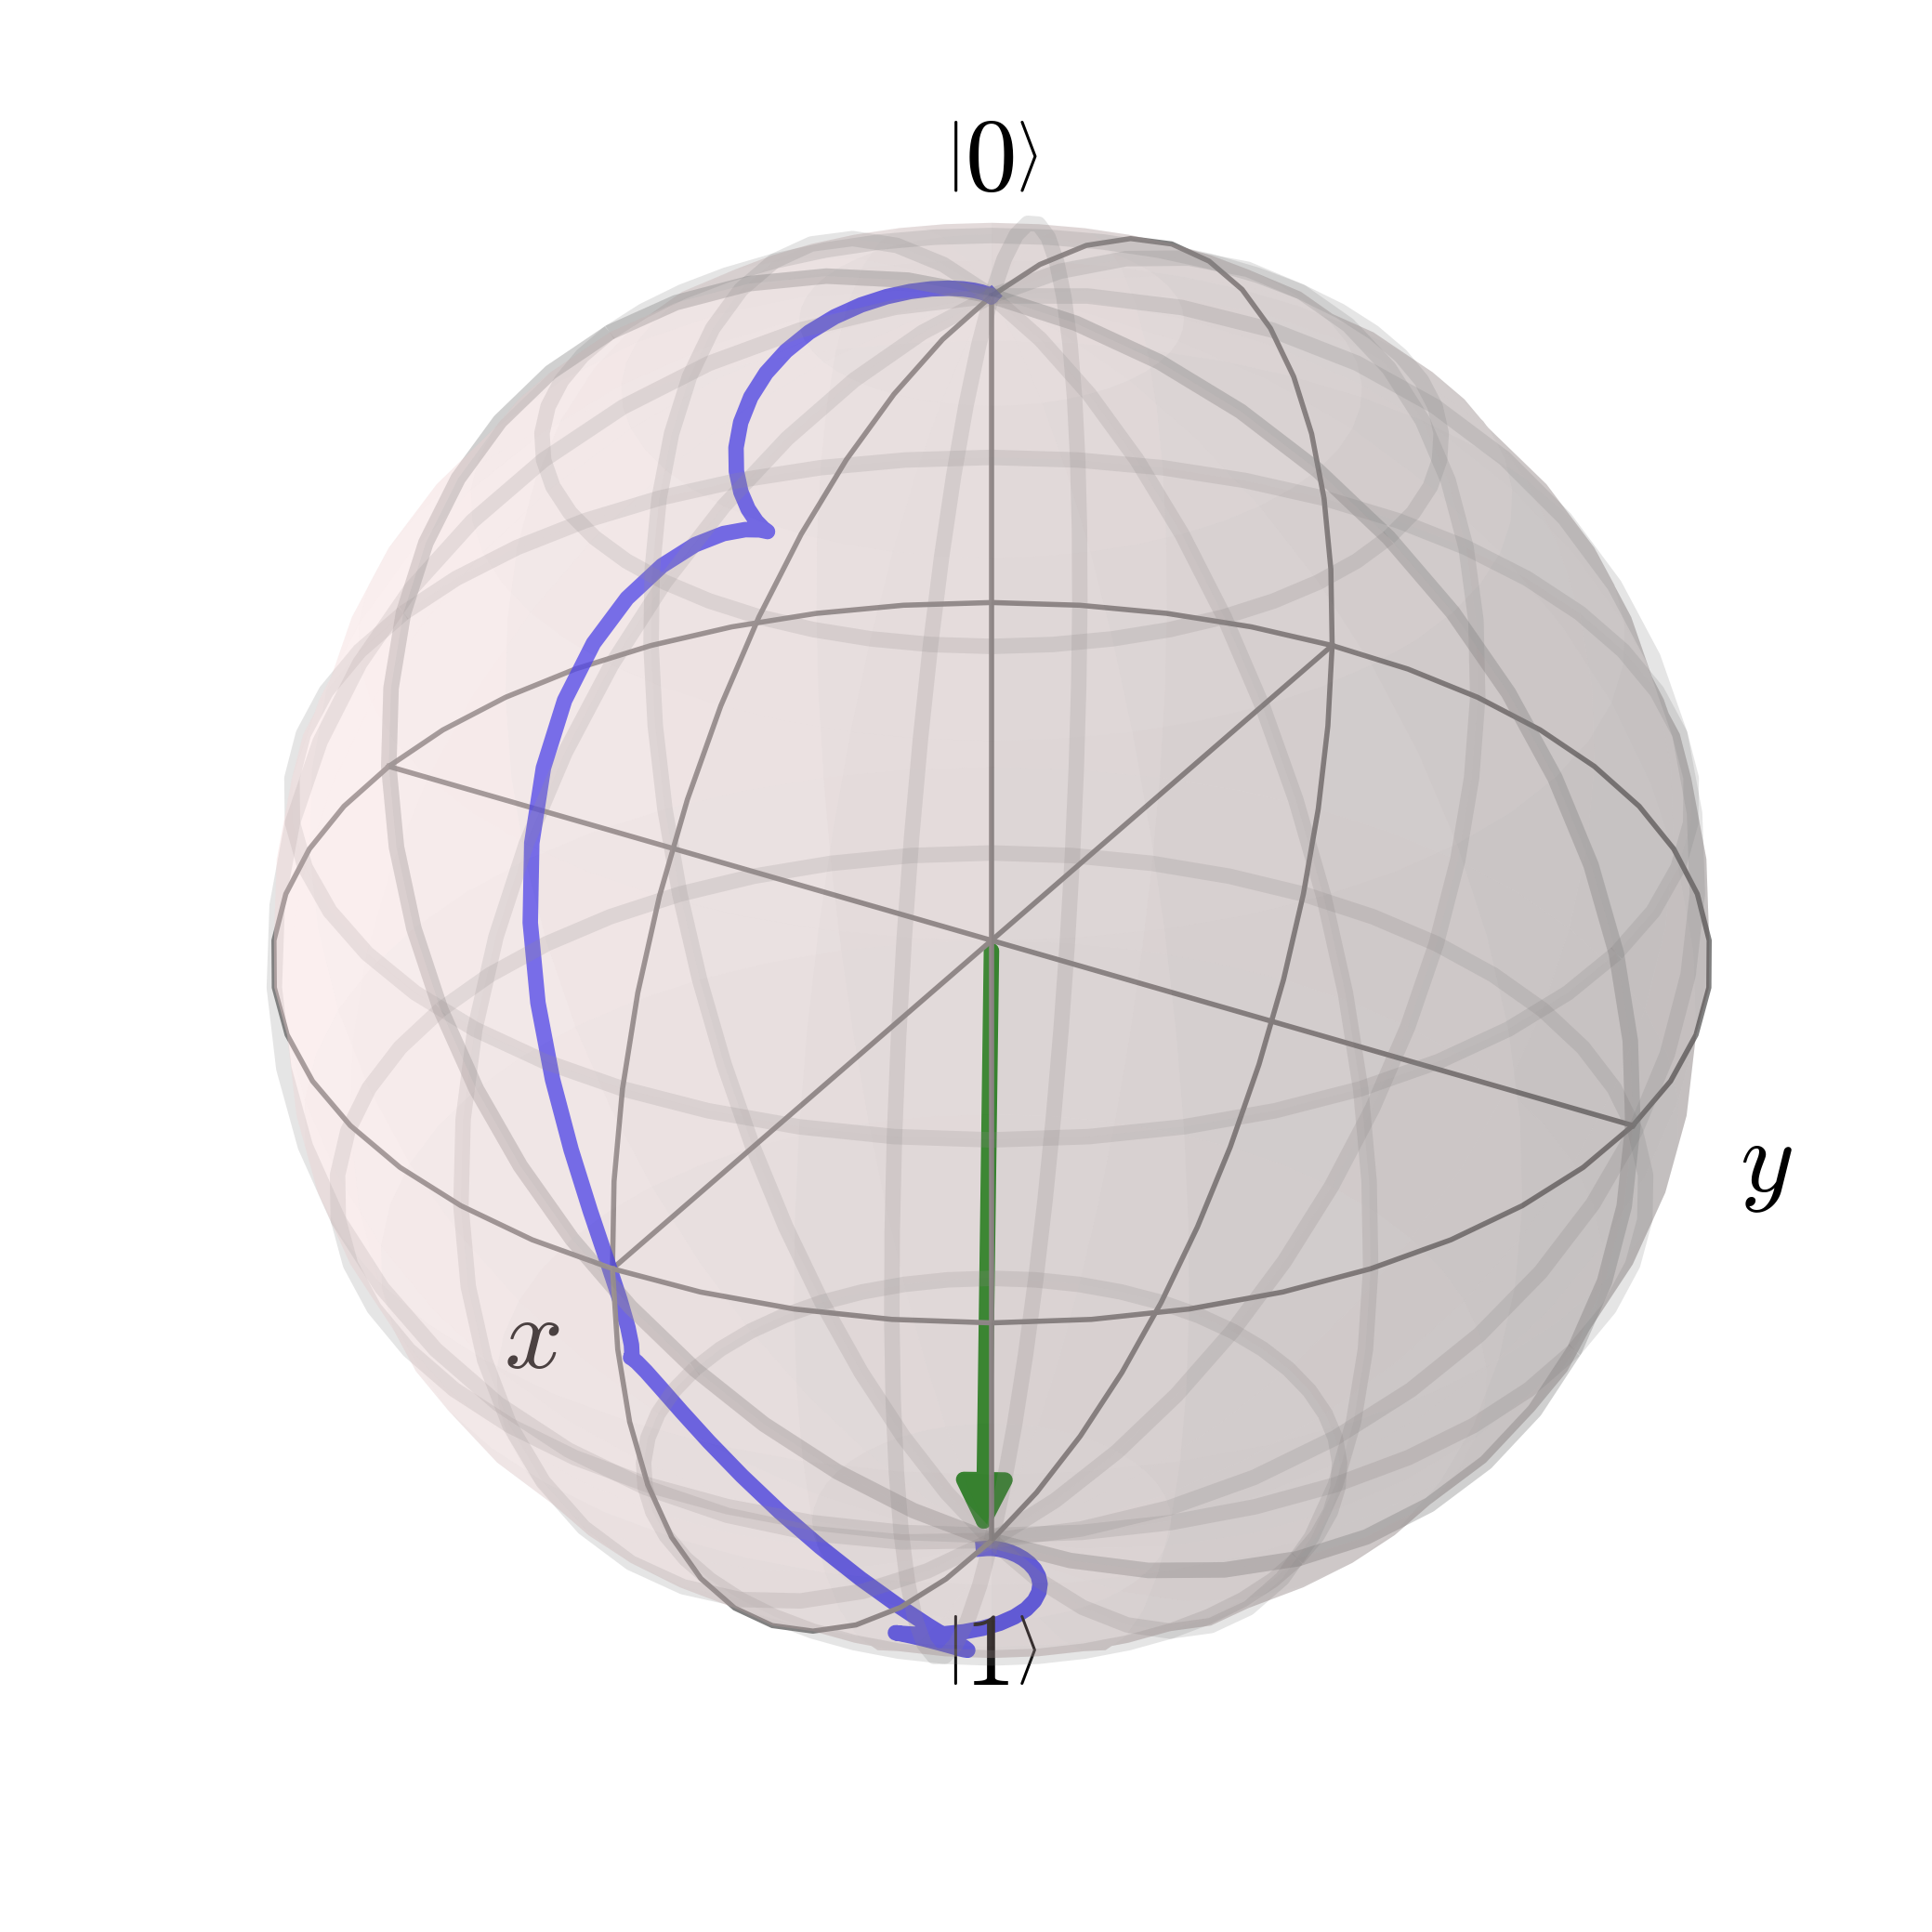

In [53]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0
sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

### Check that $\pi/2$ pulses also work

<ipython-input-11-47c9630e3632>:17: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U_ideal = ry(np.pi/2.0)


Text(0.5, 1.0, '$\\mathcal{F}=$1.0')

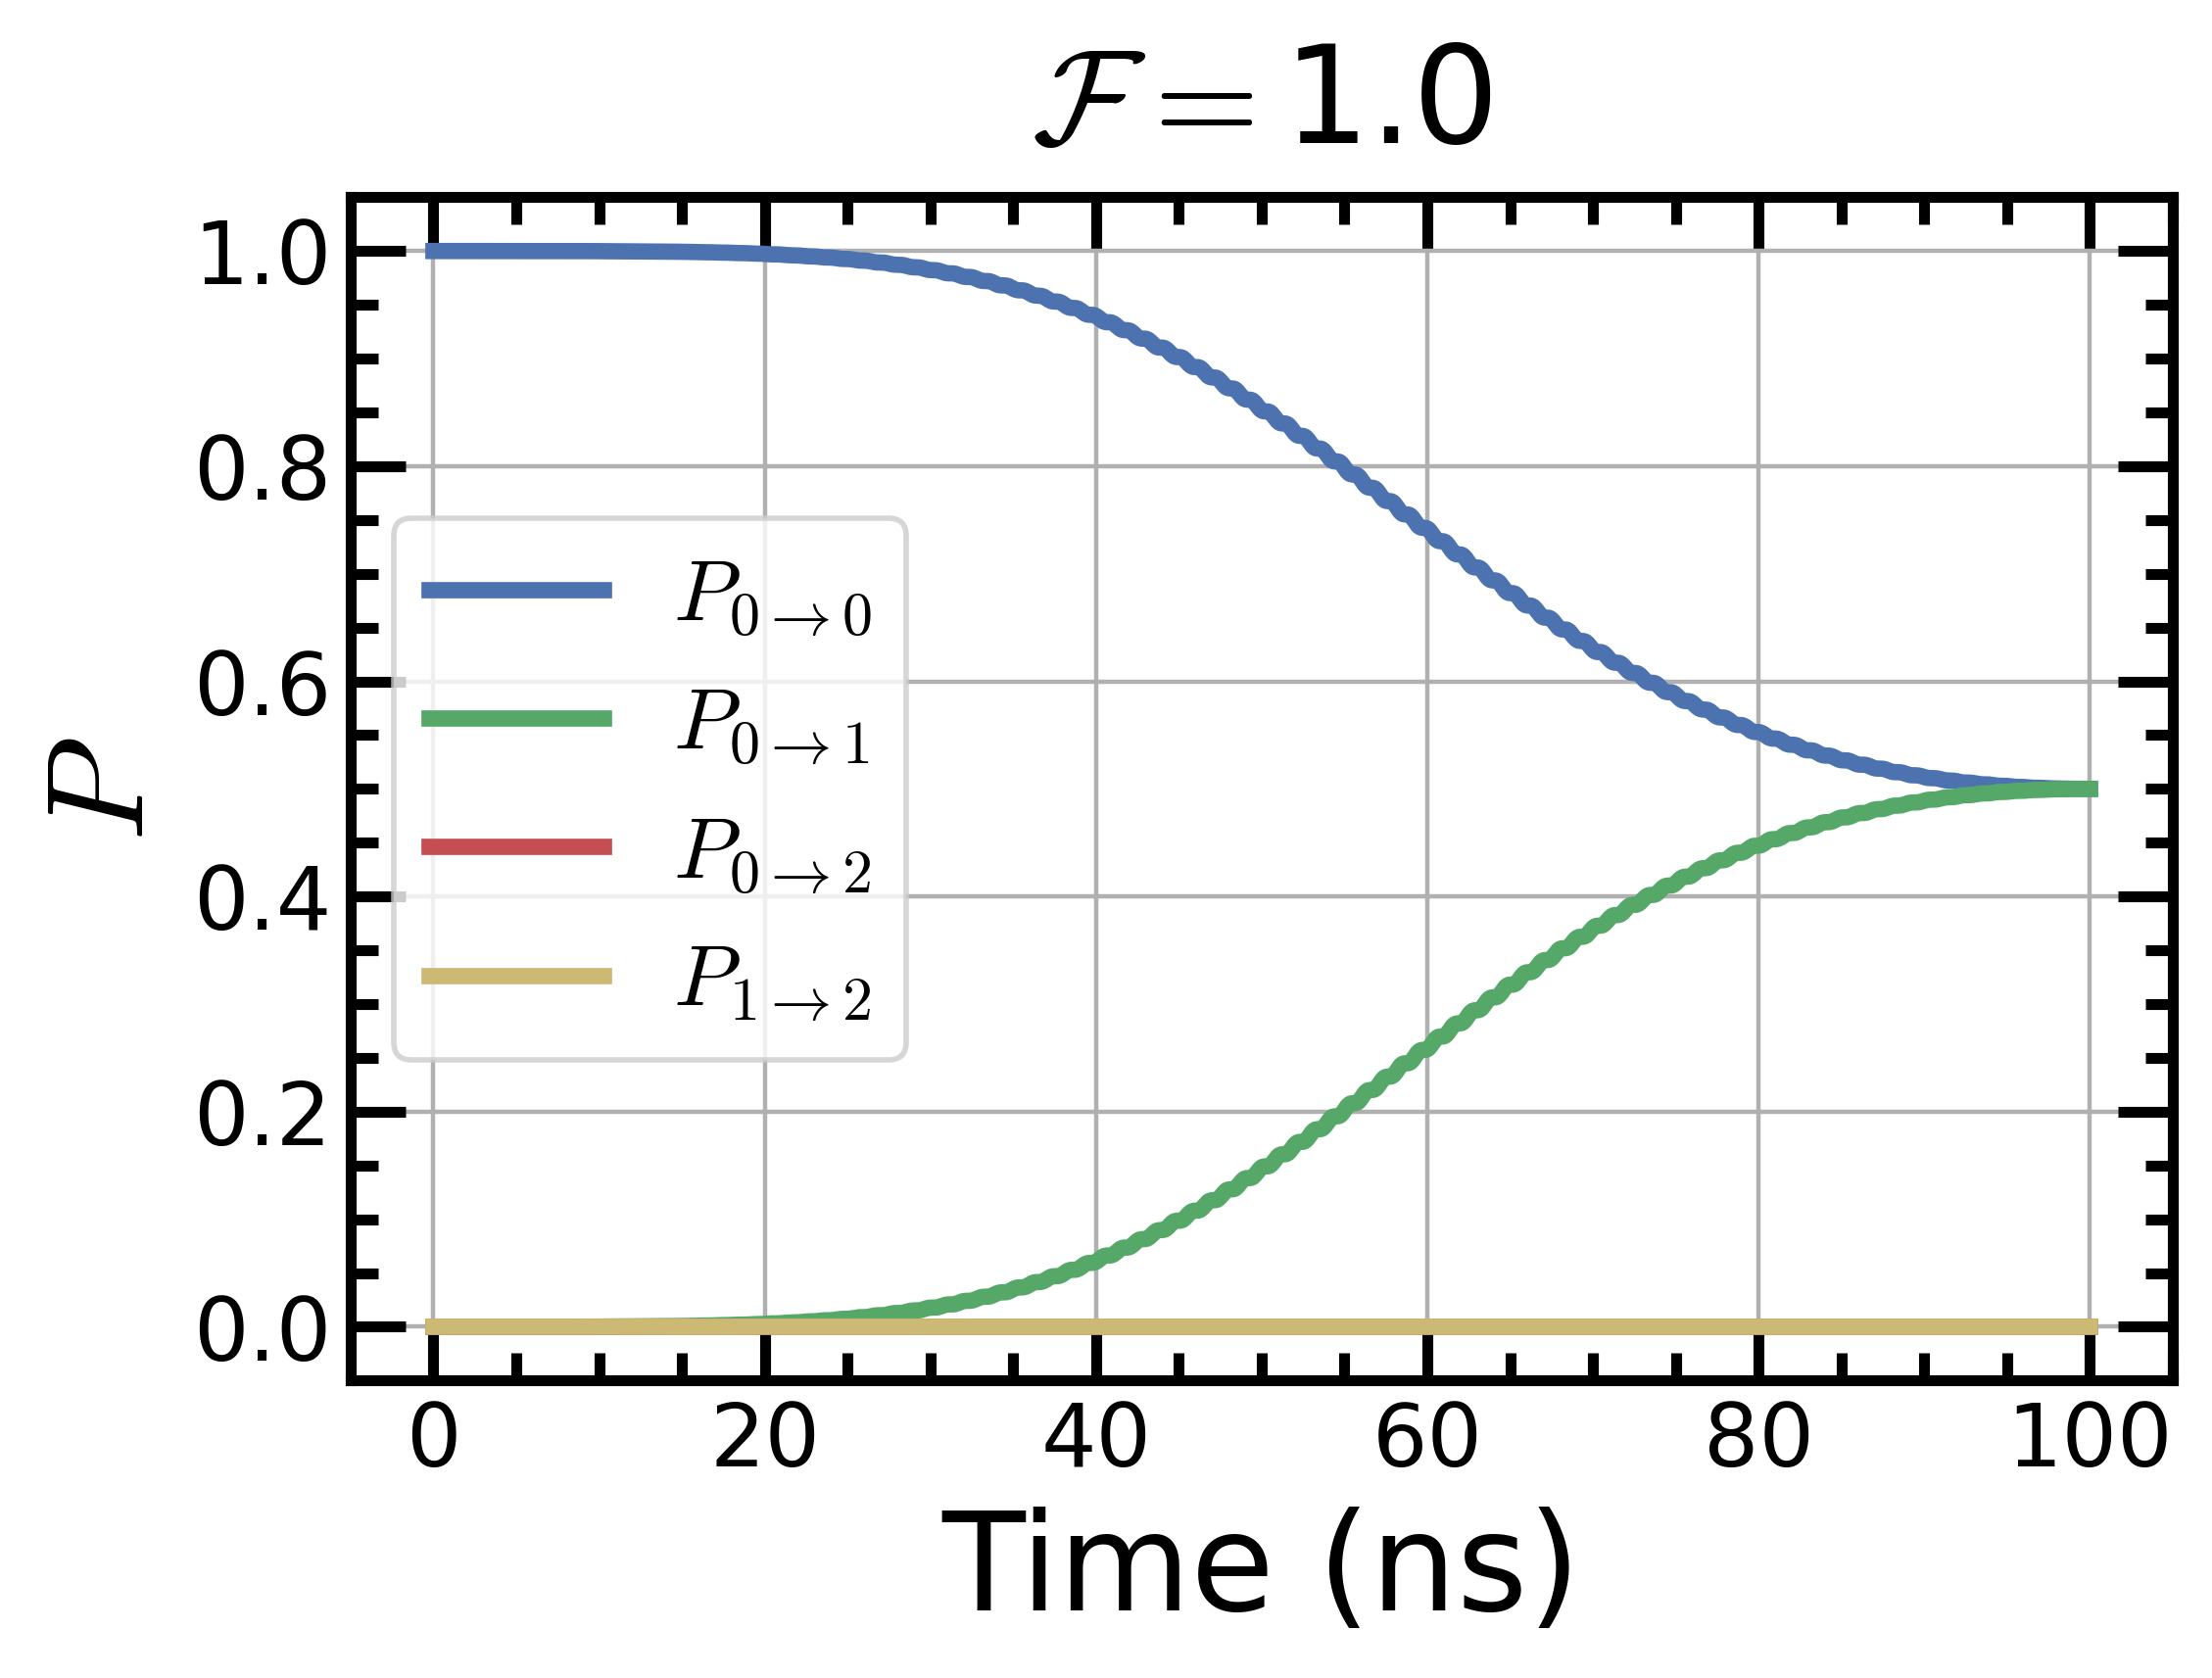

In [11]:
## Check pi/2 pulses
delta_omega_d, drag_coeff = xopt.x
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())
H_dummy = 0*(qubit.n())
omega_d = qubit.freq(0,1) + delta_omega_d
t_points = np.linspace(0, T_gate, 20 * int(T_gate) + 1)

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
        -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_ideal = ry(np.pi/2.0)
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0

trans_prob_0 = gates.prob_transition(U_nothing*U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_nothing*U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_nothing*U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_nothing*U_t, state_1, state_2)
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

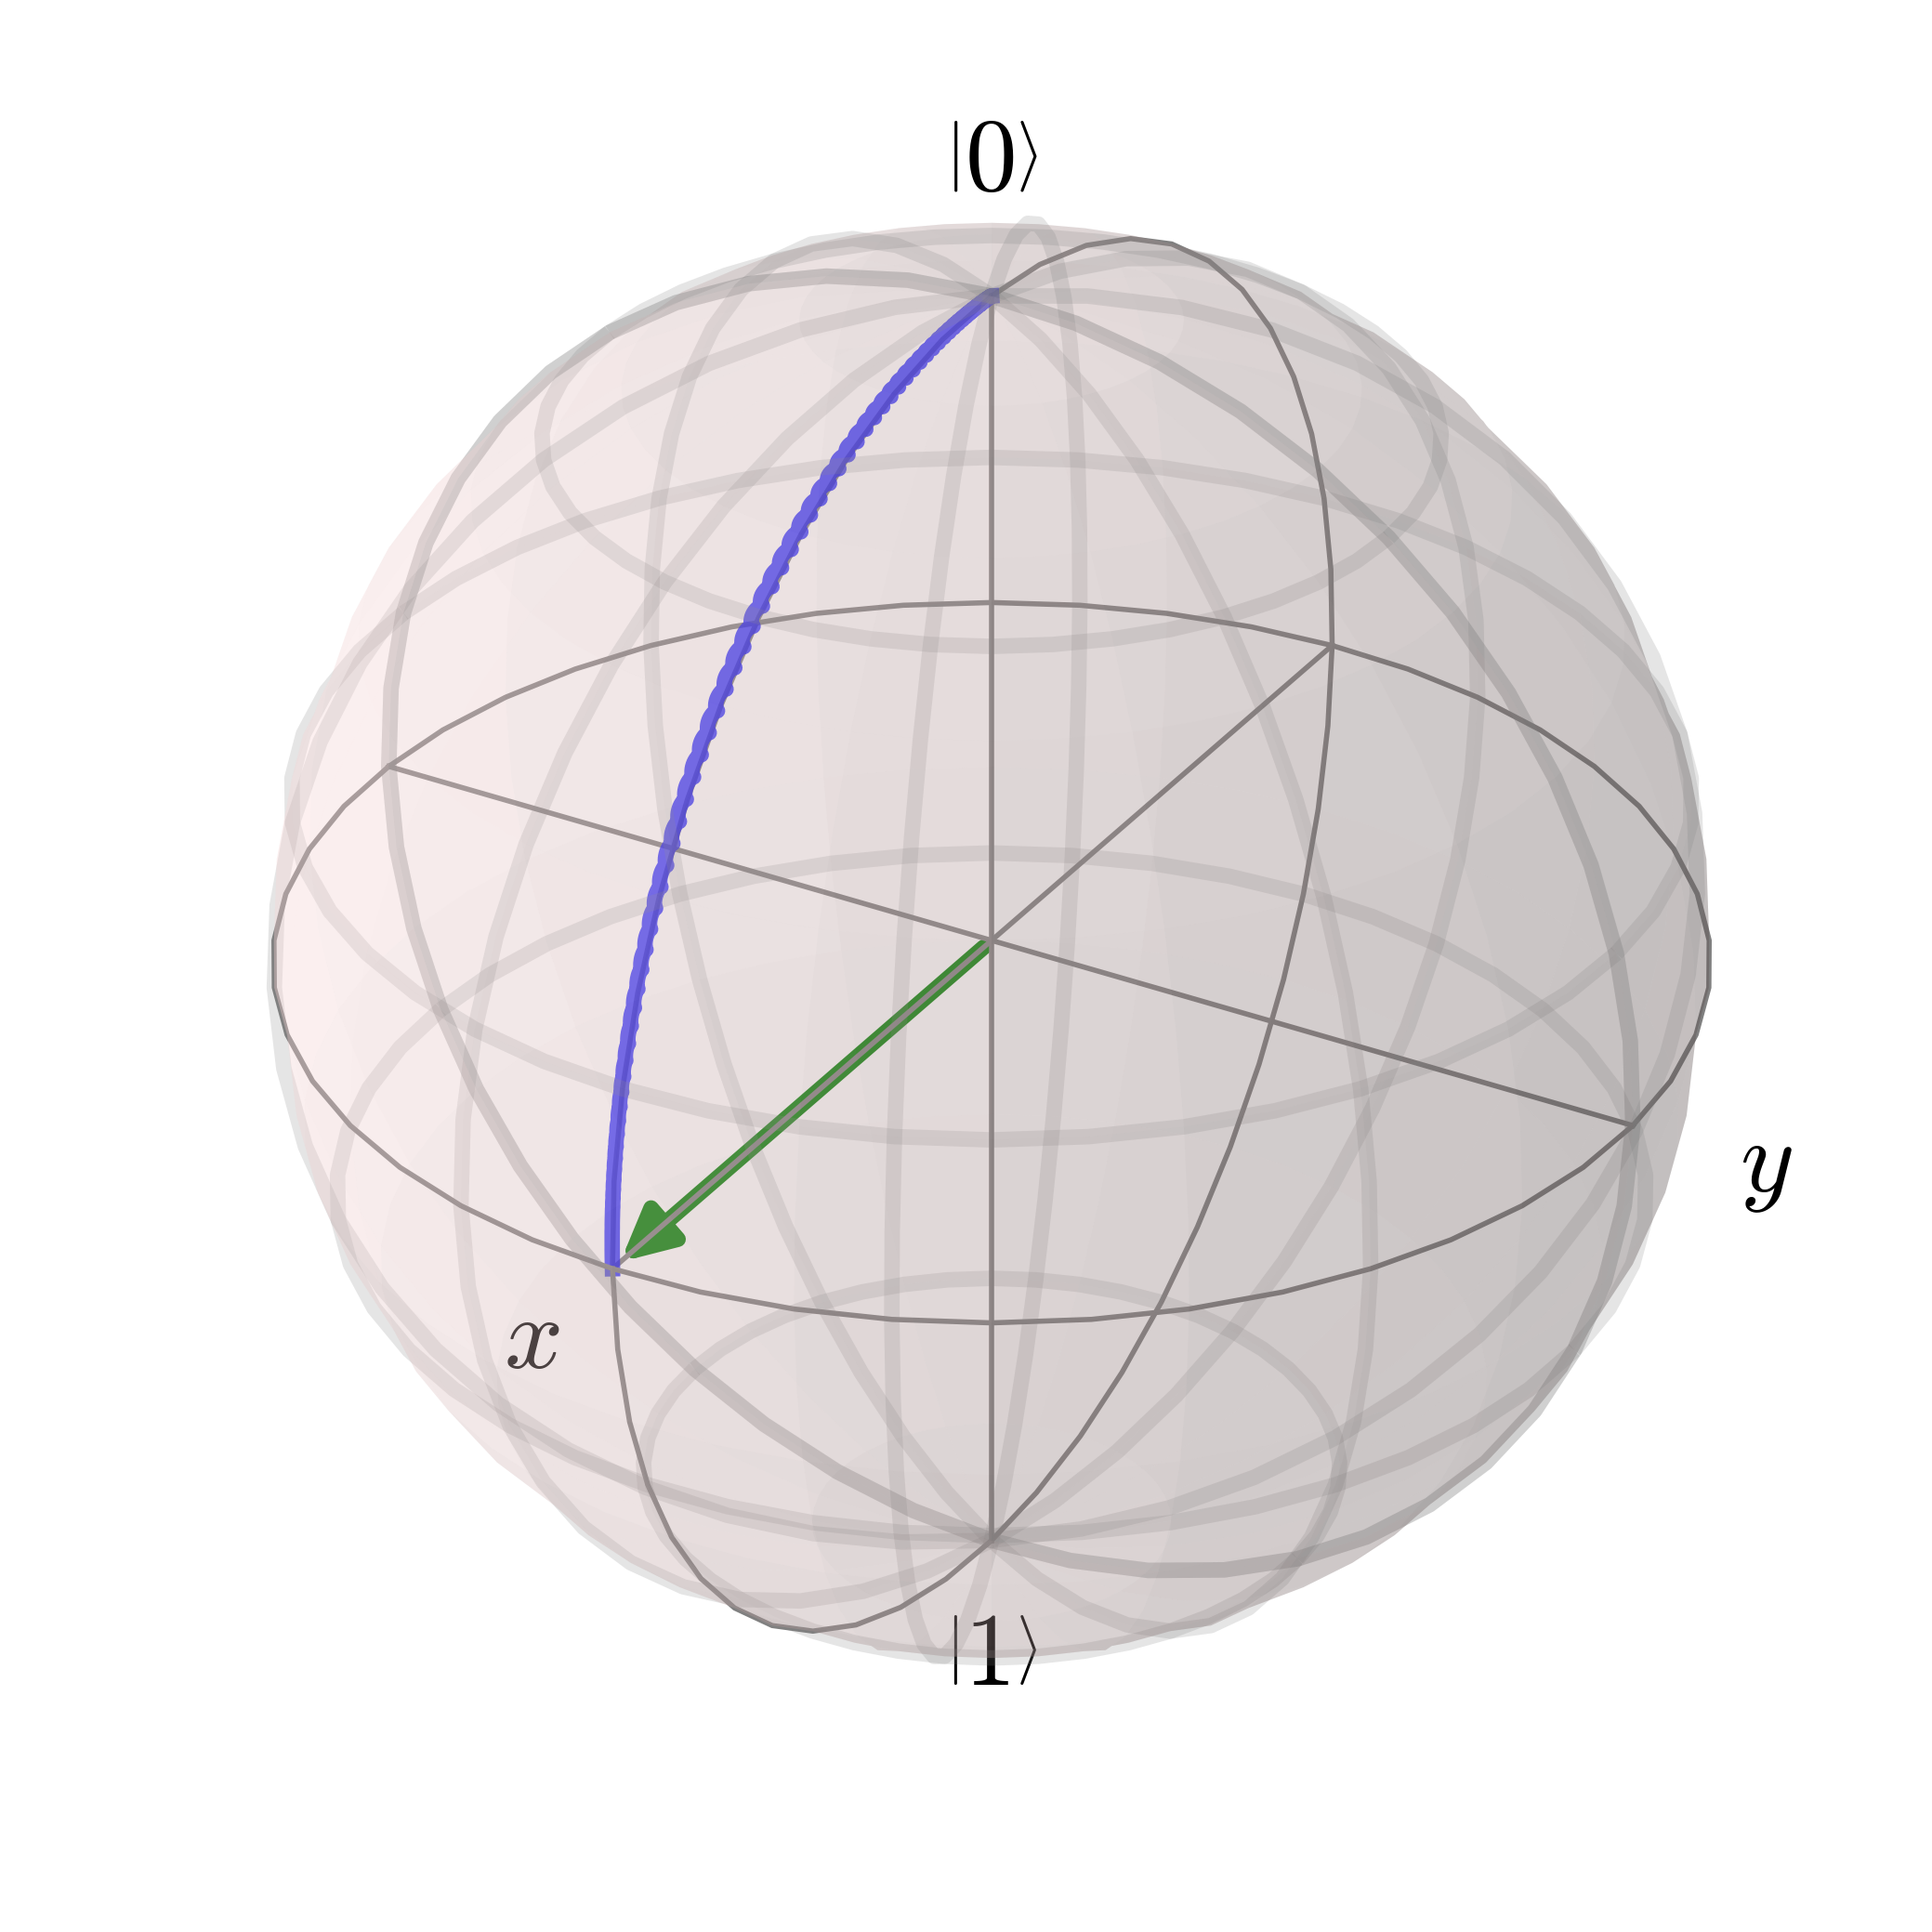

In [12]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

### PTM

<ipython-input-16-82c36dd842ff>:24: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real = np.linalg.lstsq(p_out, p_in)[0]


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa84f62400>)

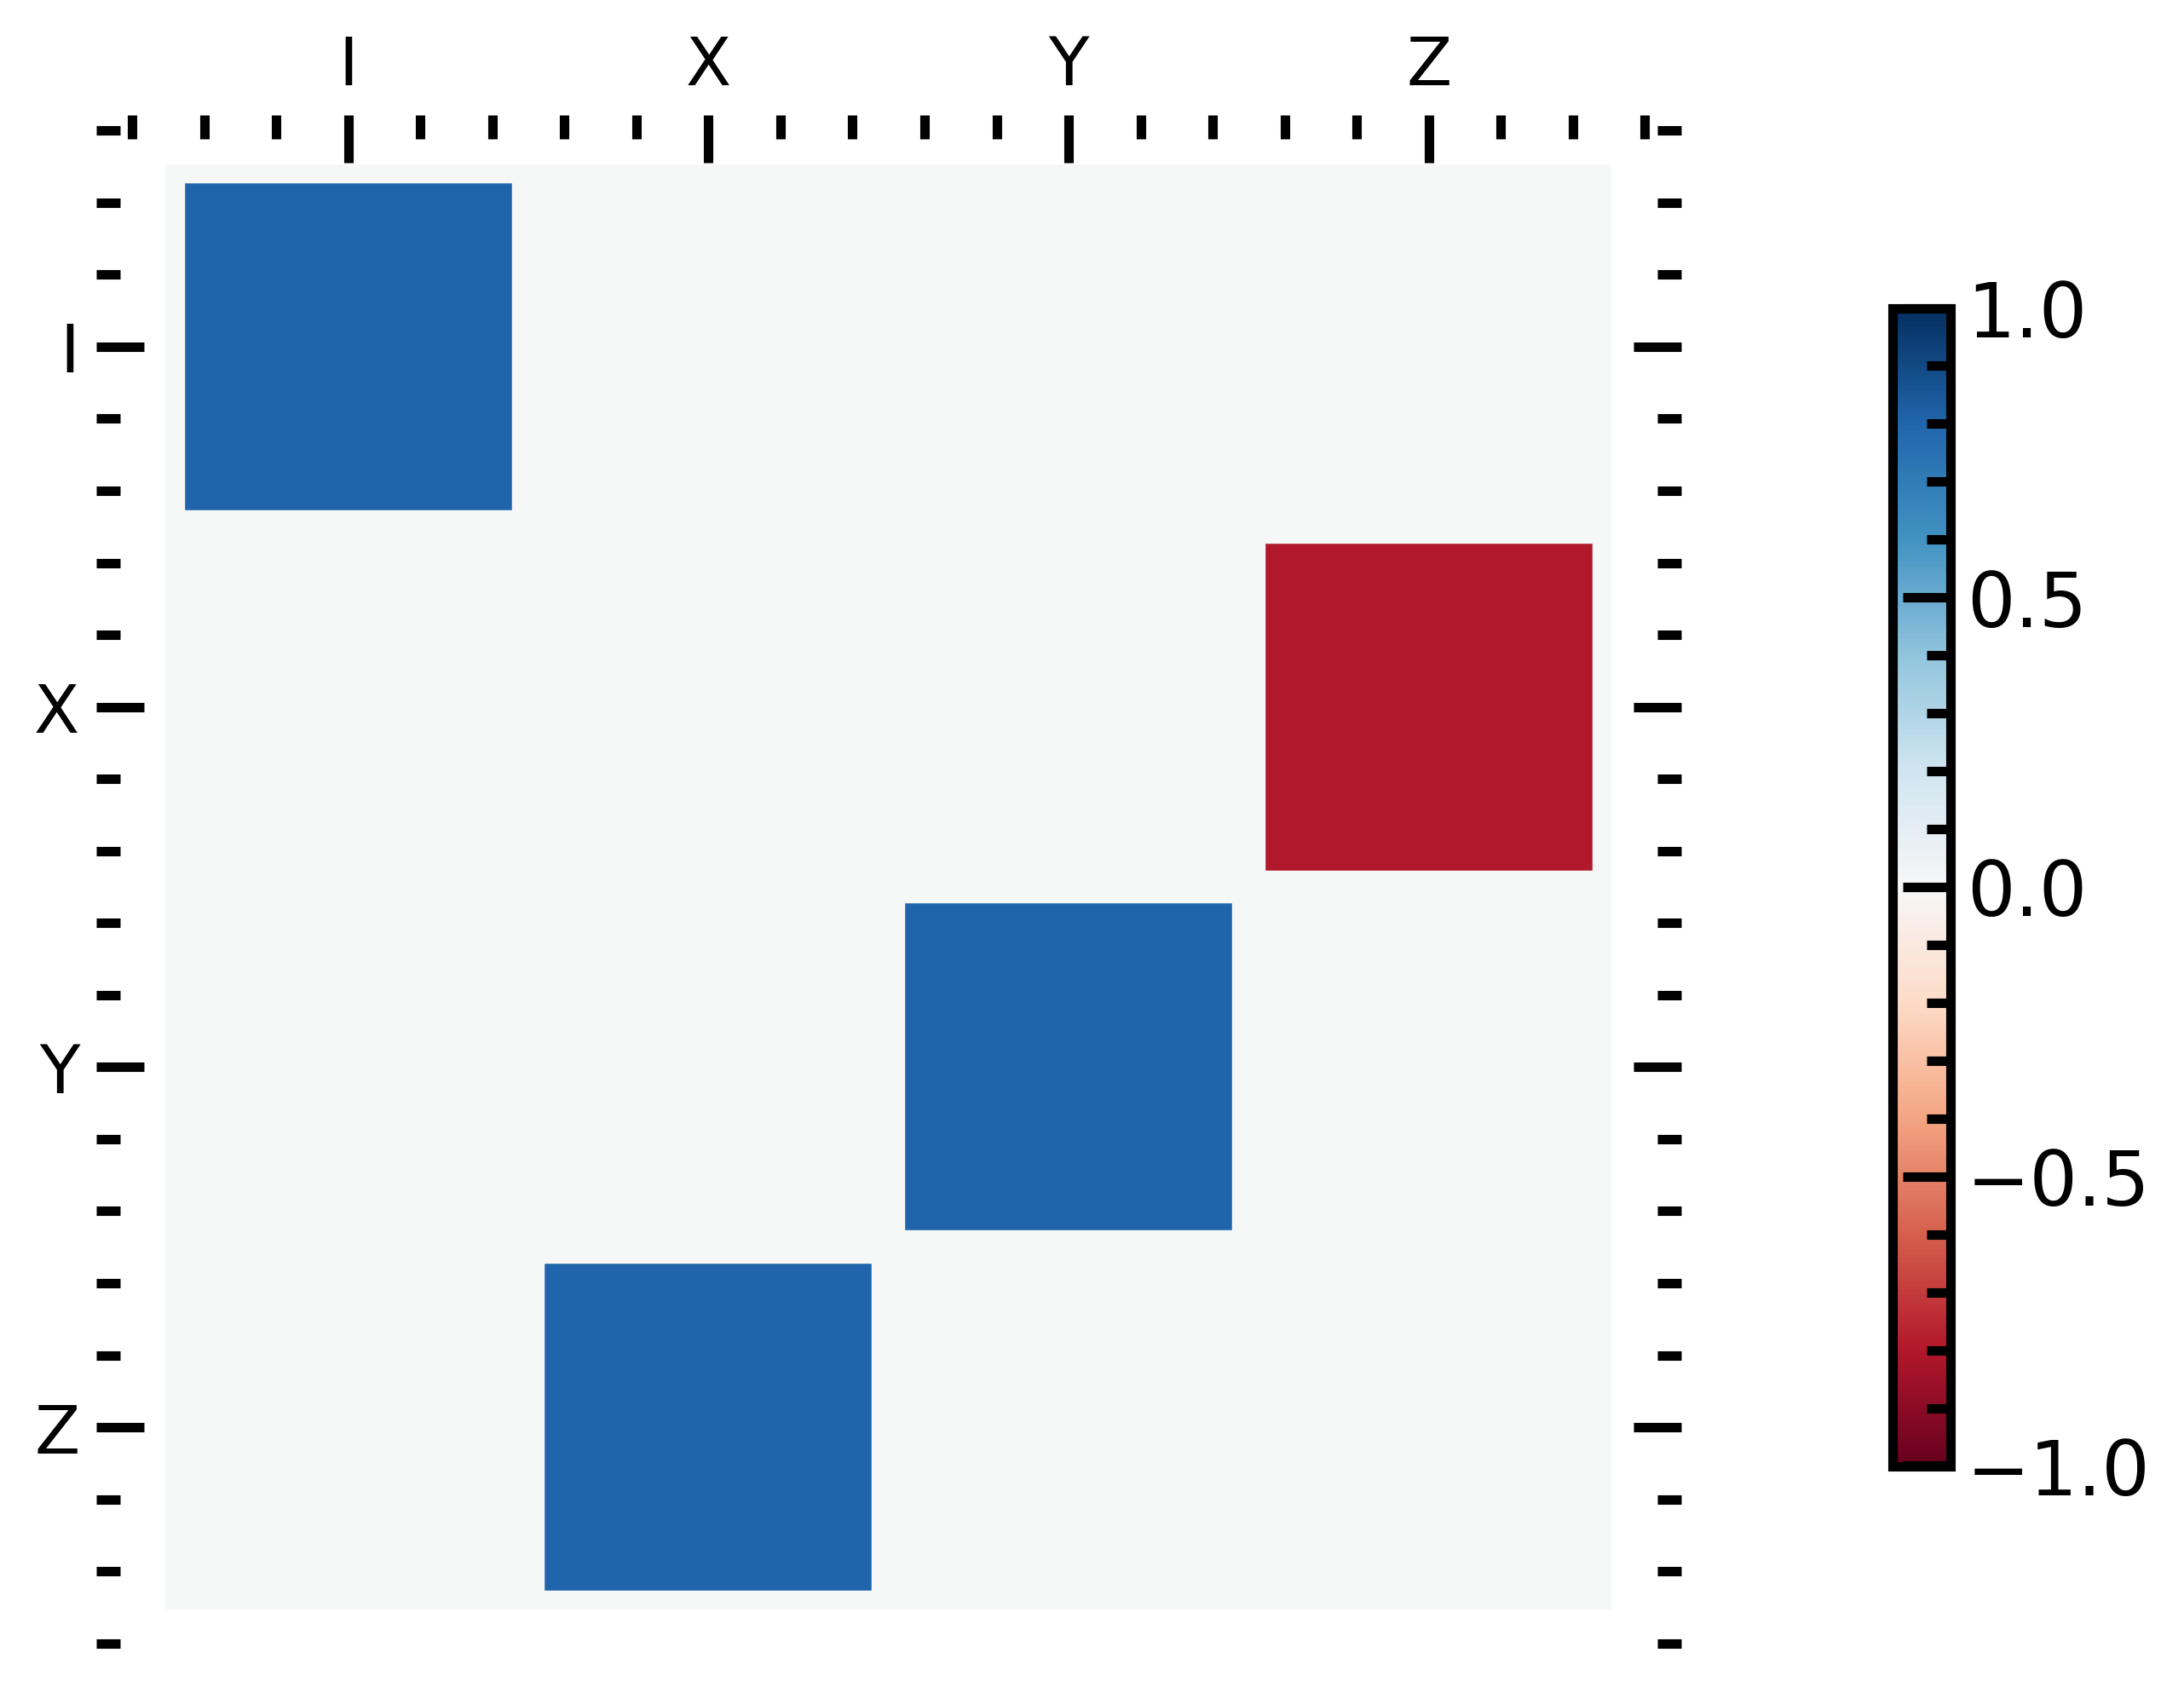

In [16]:
#Using propagator
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)

U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
    -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    state_evol =  U_nothing*U_t * psi_ini
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = (expect(meas, psi_ini))
        p_out[i,j] = (expect(meas, state_evol[-1]))
ptm_real = np.linalg.lstsq(p_out, p_in)[0]
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

<ipython-input-19-e3d42e83347c>:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa7219beb0>)

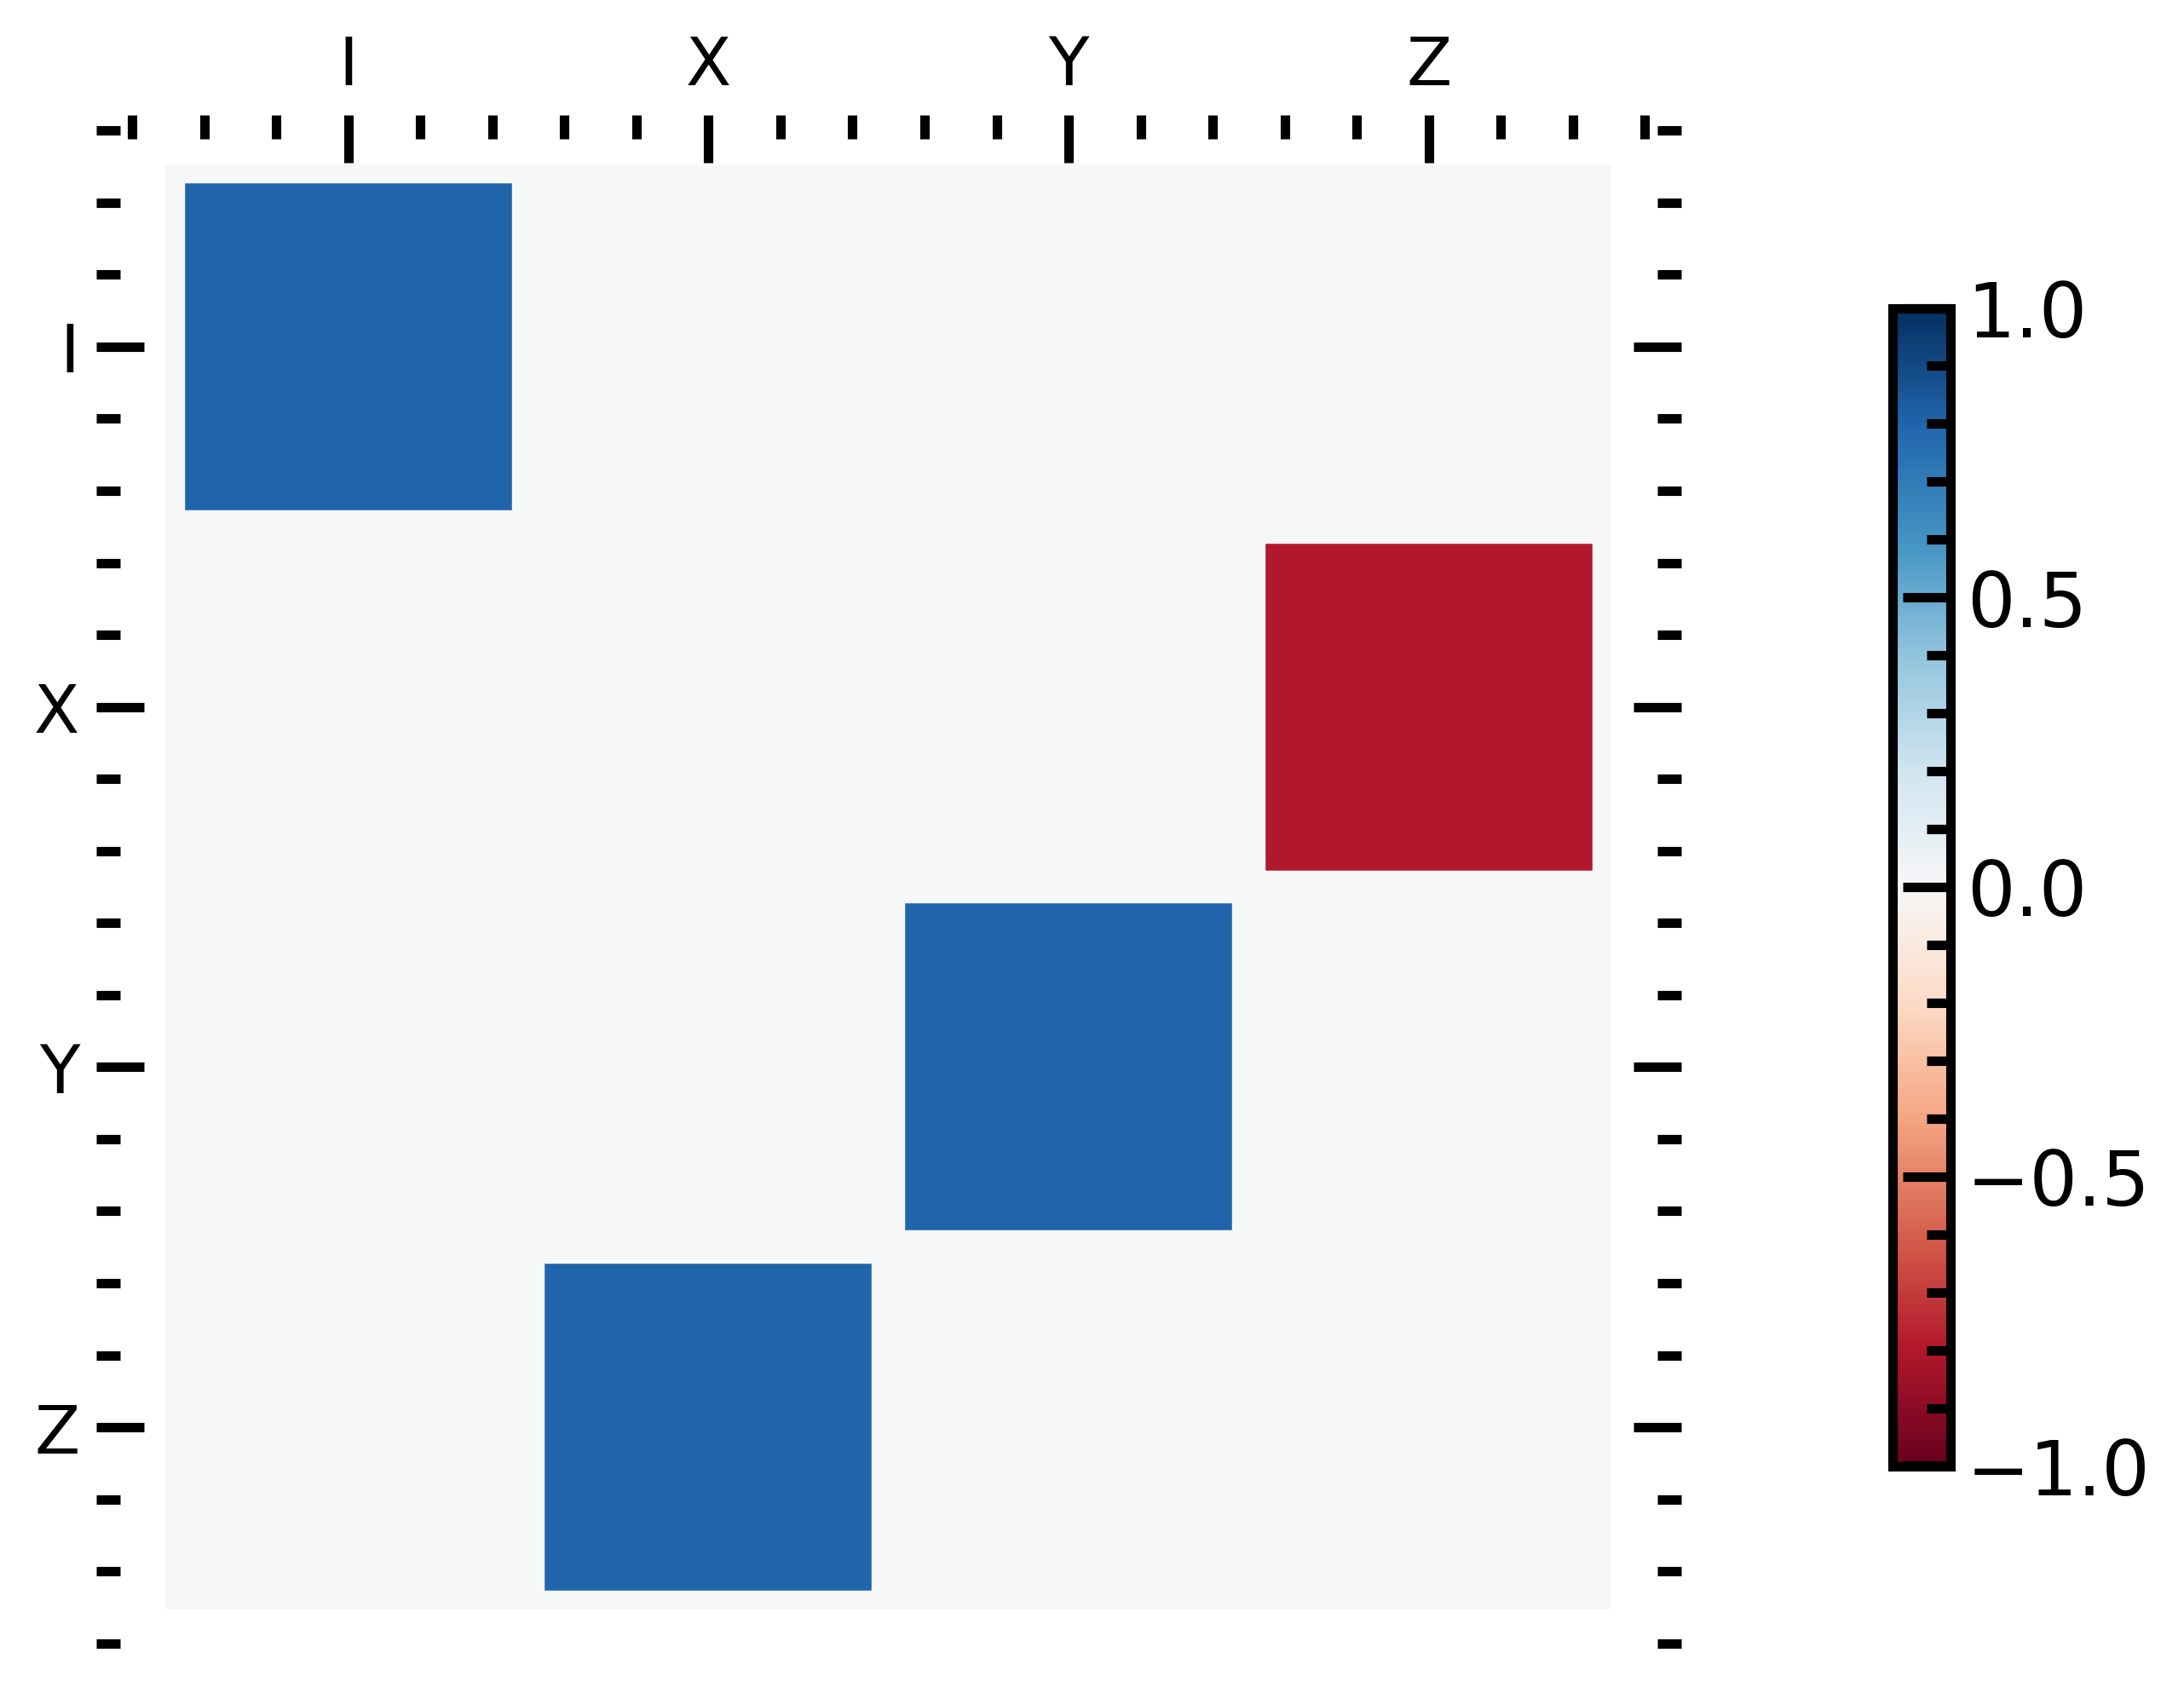

In [19]:
# Using master equation for states
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states0 = gates.evolution_psi_microwave(qubit.H(), H_drive, psi0 = psi_ini, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    evol_states1 = gates.evolution_psi_microwave(qubit.H(), H_drive, psi0 = U_nothing[-1]*evol_states0[-1], t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    evol_states2 = gates.evolution_psi_microwave(qubit.H(), H_drive, psi0 = U_nothing[-1]*evol_states1[-1], t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = (expect(meas, psi_ini))
        p_out[i,j] = (expect(meas, U_nothing[-1]*evol_states0[-1]))

ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])        
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

<ipython-input-22-088d433f52bd>:3: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  sx2 = rx(np.pi/2)
<ipython-input-22-088d433f52bd>:4: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  sy2 = ry(np.pi/2)
<ipython-input-22-088d433f52bd>:8: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  gate = ry(np.pi/2)
<ipython-input-22-088d433f52bd>:18: FutureWarning: `rcond` parameter will chan

0.9999665060593808


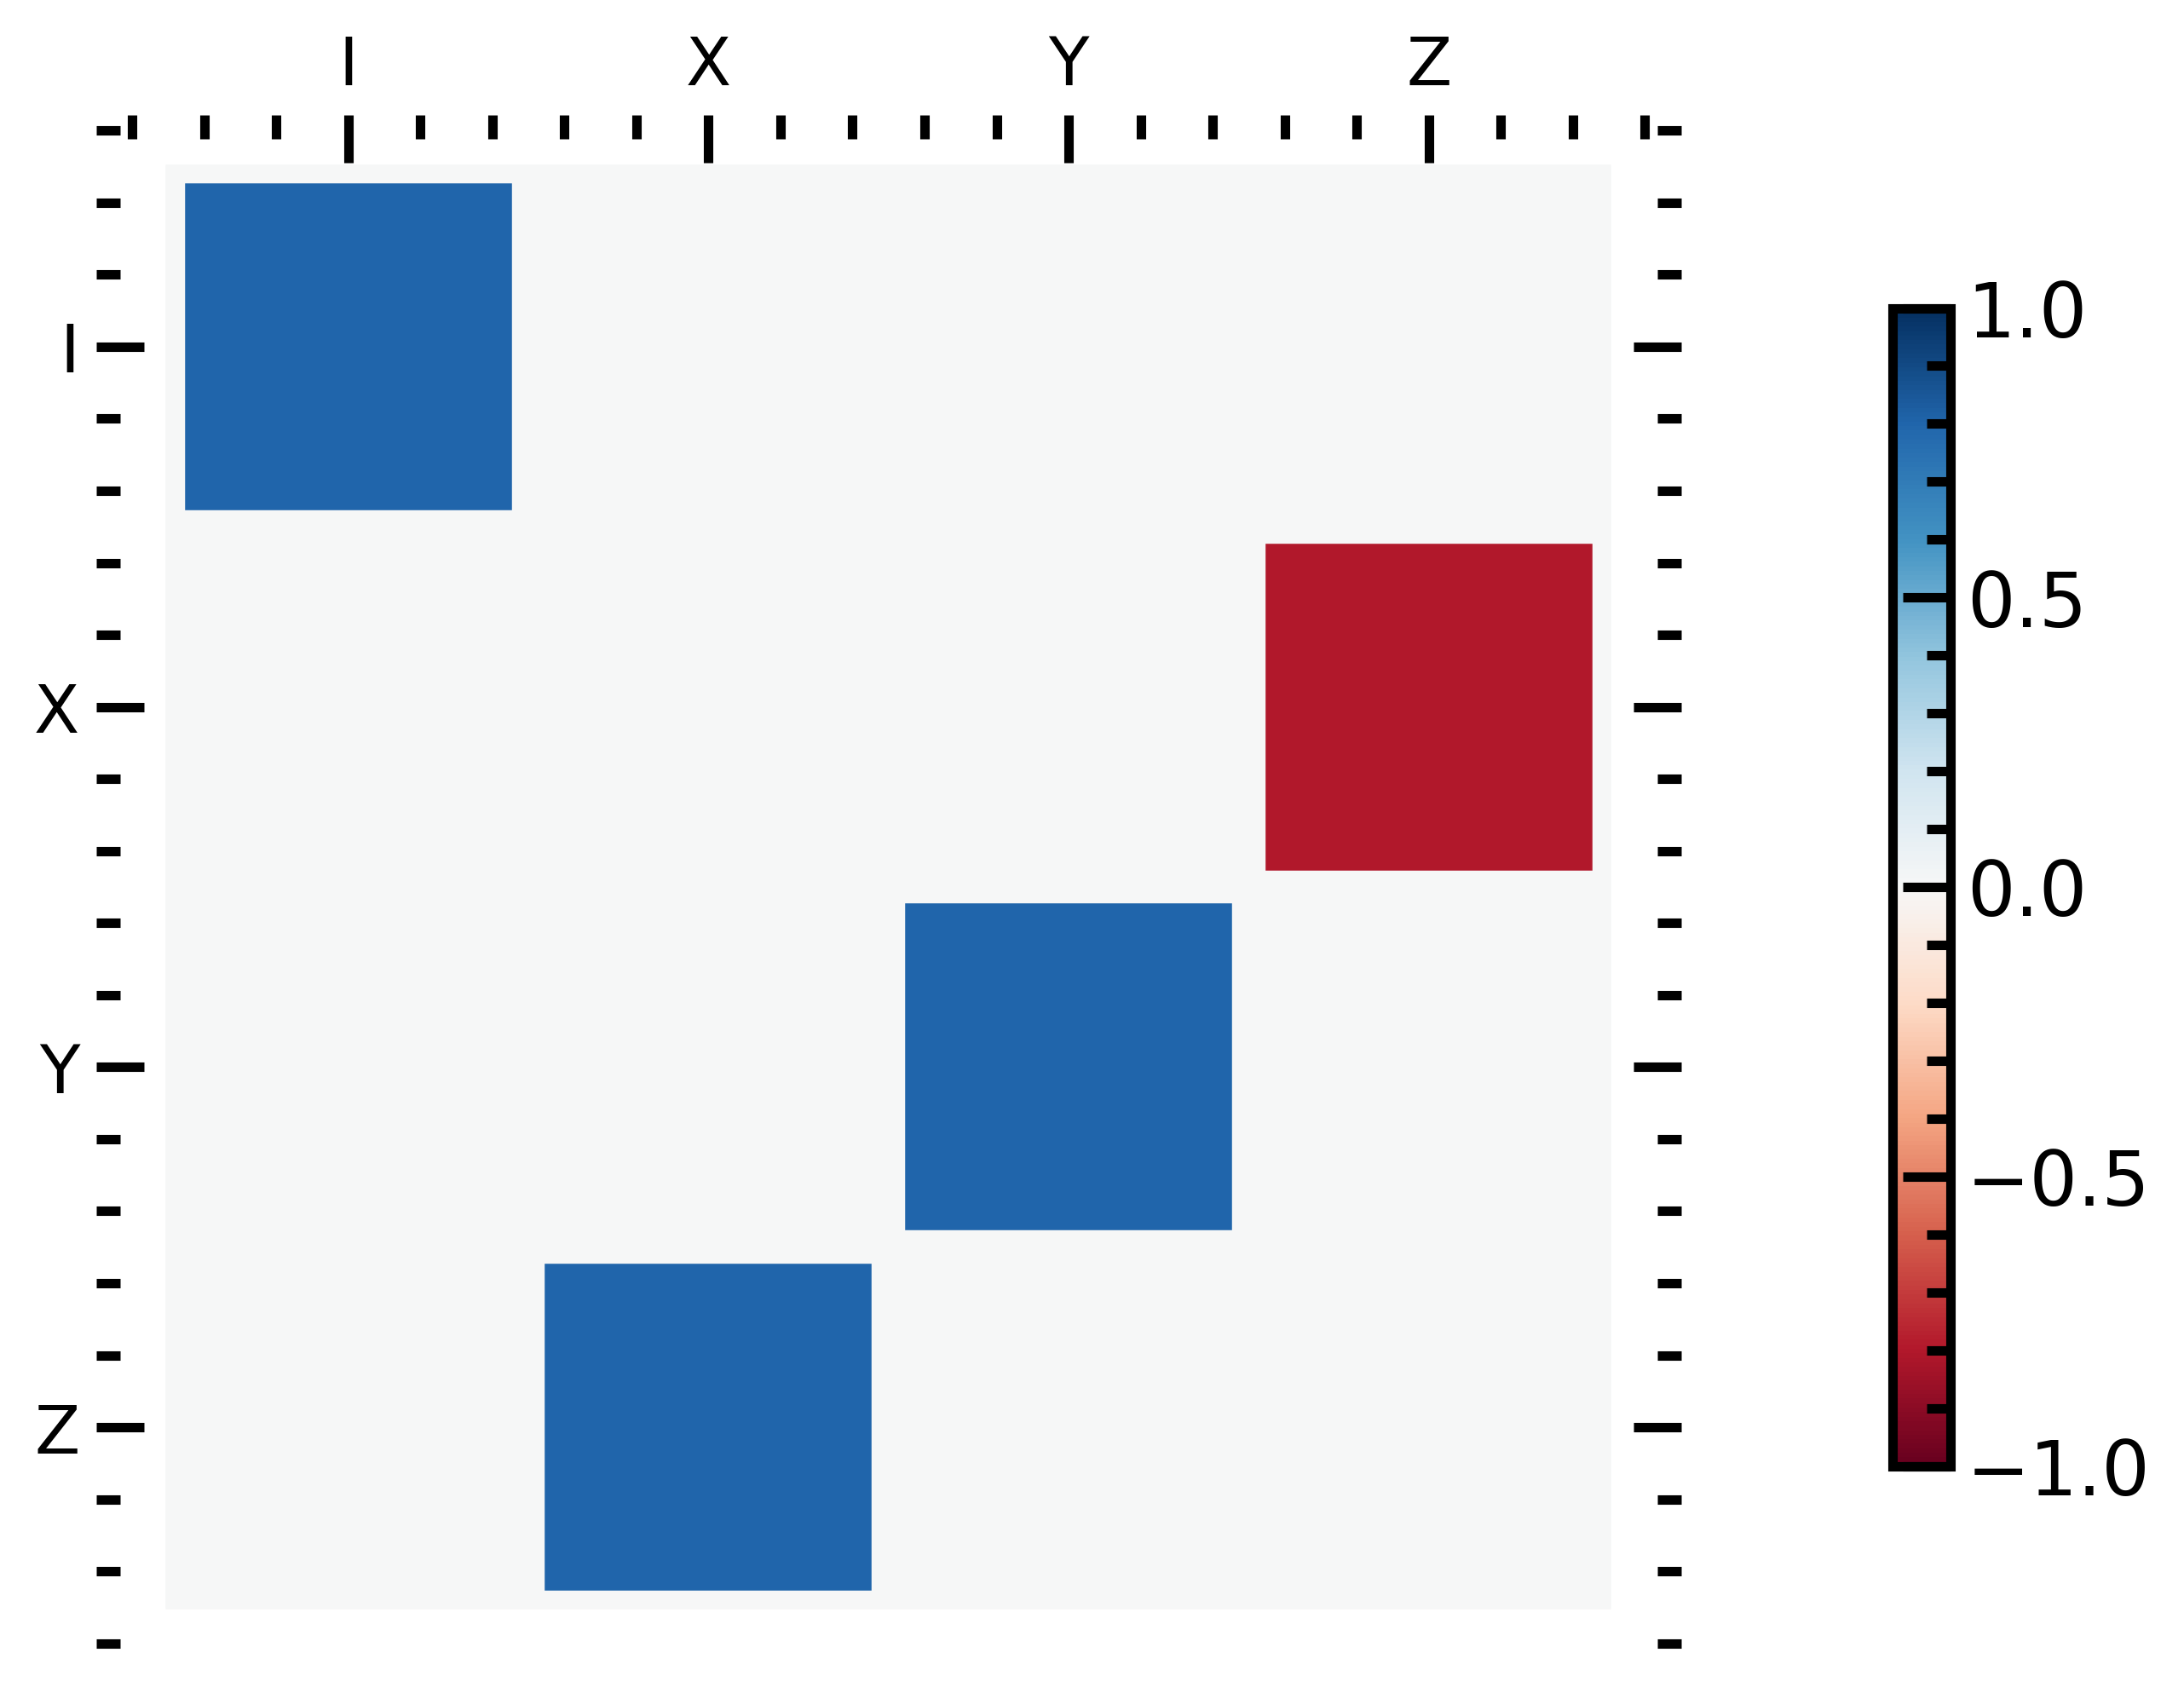

In [22]:
# Two-level system ideal PTM
I = qeye(2)
sx2 = rx(np.pi/2)
sy2 = ry(np.pi/2)
p_in = np.zeros((4,4))
p_out = np.zeros((4,4))

gate = ry(np.pi/2)

prep_rotations = [I, sigmax(), sx2, sy2]
meas_rotations = [I, sigmax(), sigmay(), sigmaz()]
for i, prep in enumerate(prep_rotations):
    psi_ini = prep*basis(2,0)
    for j, meas in enumerate(meas_rotations):
        p_in[i,j] = expect(meas, psi_ini)
        p_out[i,j] = expect(meas, gate*psi_ini)
        
ptm_ideal = Qobj(np.linalg.lstsq(p_out, p_in)[0])
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_ideal, xlabels = op_label, ylabels = op_label)
ptm_real = Qobj(ptm_real)

d = 2
process_fidelity = ((ptm_real.dag()*ptm_ideal).tr() + d)/(d**2+d)
print (process_fidelity)

In [43]:
#introducing decoherence
#List of collapse operators
gamma1_01 = (50e6)**-1.0
gamma2_01 = (5e3)**-1.0
L1_01 = np.sqrt(gamma1_01)*state_0*state_1.dag()
L2_01 = np.sqrt(2*gamma2_01)*state_1*state_1.dag()

gamma1_02 = (53e3)**-1
gamma2_02 = (52e3)**-1
L1_02 = np.sqrt(gamma1_02)*state_0*state_2.dag()
L2_02 = np.sqrt(2*gamma2_02)*state_2*state_2.dag()

gamma1_13 = (58e3)**-1
gamma2_13 = (33e3)**-1
L1_13 = np.sqrt(gamma1_13)*state_1*state_3.dag()
L2_13 = np.sqrt(2*gamma2_13)*state_3*state_3.dag()

gamma1_23 = (306e3)**-1
gamma2_23 = (7e3)**-1
L1_23 = np.sqrt(gamma1_23)*state_2*state_3.dag()
L2_23 = np.sqrt(2*gamma2_23)*state_3*state_3.dag()

gamma1_12 = (786e3)**-1
gamma2_12 = (6e3)**-1
L1_12 = np.sqrt(gamma1_12)*state_1*state_2.dag()
L2_12 = np.sqrt(2*gamma2_12)*state_2*state_2.dag()

gamma1_03 = (697e3)**-1
gamma2_03 = (6e3)**-1
L1_03 = np.sqrt(gamma1_03)*state_0*state_3.dag()
L2_03 = np.sqrt(2*gamma2_03)*state_3*state_3.dag()

c_ops = [L1_01,L2_01, L1_02,L2_02, L1_13,L2_13, L1_23,L2_23, L1_12,L2_12, L1_03,L2_03]

<ipython-input-44-dc3319ff9825>:18: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])


(<Figure size 3200x2400 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faa70882fd0>)

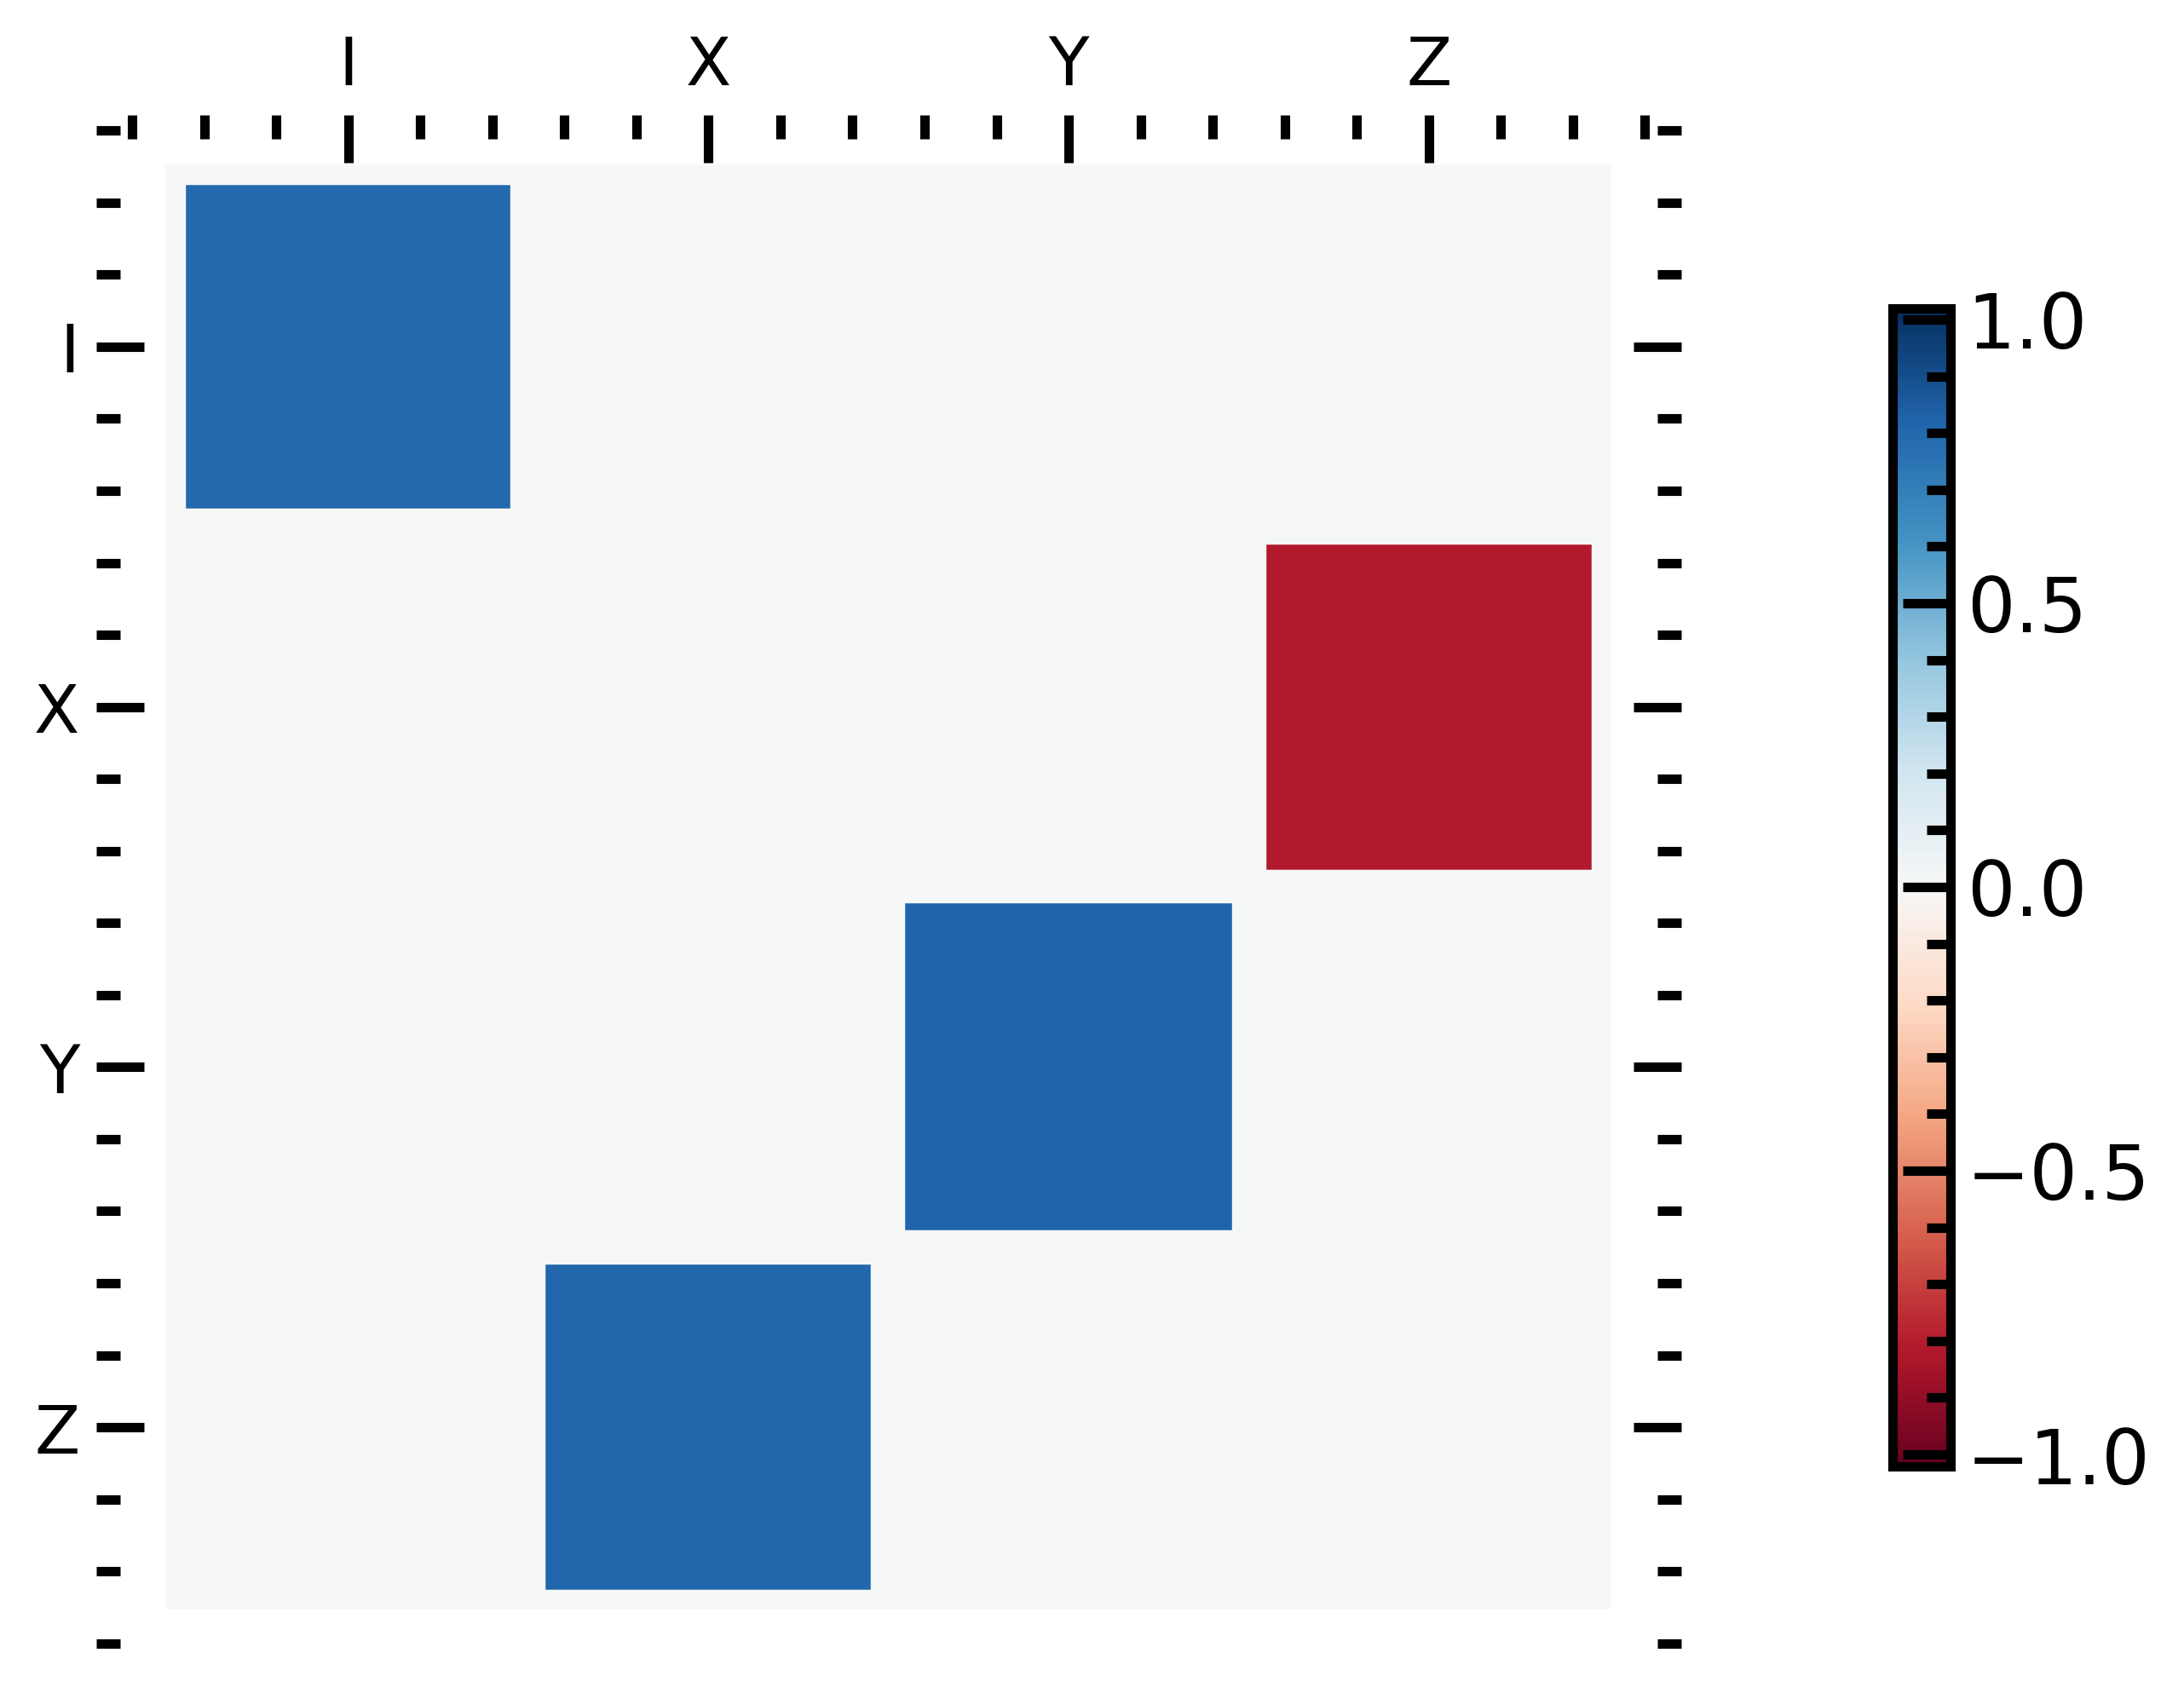

In [44]:
# Using master equation for states
drive_amplitude_factor = 0.25
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.n())

prep_ops = [qeye(nlev_single), op.sx(phi=np.pi/2, N=nlev_single), op.sy(phi=-np.pi/2, N=nlev_single), op.sigx(N=nlev_single)]
meas_ops = [qeye(nlev_single), op.sigx(N=nlev_single), op.sigy(N=nlev_single), op.sigz(N=nlev_single)]
p_in = np.zeros((4,4), dtype = complex)
p_out = np.zeros((4,4), dtype = complex)
for i, prep in enumerate(prep_ops):
    psi_ini = prep*state_0
    evol_states = gates.evolution_psi_microwave_diss(qubit.H(), H_drive, psi0 = psi_ini, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d, c_ops = c_ops)
    for j, meas in enumerate(meas_ops):
        p_in[i,j] = (expect(meas, psi_ini))
        p_out[i,j] = (expect(meas, U_nothing[-1]*evol_states[-1]*U_nothing[-1].dag()))

ptm_real = Qobj(np.linalg.lstsq(p_out, p_in)[0])        
op_label = ["I","X","Y","Z"]
qutip.hinton(ptm_real, xlabels = op_label, ylabels = op_label)

### Sweeping gate time

In [8]:
#Gate parameter
T_gate_array = np.linspace(5,25,21) #ns
error_array_charge = np.zeros_like(T_gate_array)
drag_coeff_array = np.zeros_like(T_gate_array)
delta_omega_d_array = np.zeros_like(T_gate_array)

drive_amplitude_factor = 0.5
U_ideal = sigmay()

shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0
delta_omega_d = 0

for T_idx, T_gate in enumerate(T_gate_array):
  
    t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
    delta_omega_d = 0
    drag_coeff = 0
    U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    def infidelity(x):
        delta_omega_d = x[0]
        drag_coeff = x[1]
        omega_d = qubit.freq(0,1) + delta_omega_d
        U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
        U_real = U_nothing[-1]*U_t[-1]
        U_real = Qobj(U_real[0:2, 0:2])

        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
        return 1-fidel
    if T_idx == 0:    
        x0 = [0,0]
    else:
        x0 = [xopt.x[0],xopt.x[1]]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
    
    error_array_charge[T_idx] = infidelity(xopt.x)
    drag_coeff_array[T_idx] = xopt.x[1]
    delta_omega_d_array[T_idx] = xopt.x[0]

Text(0.5, 0, '$\\tau_g$ (ns)')

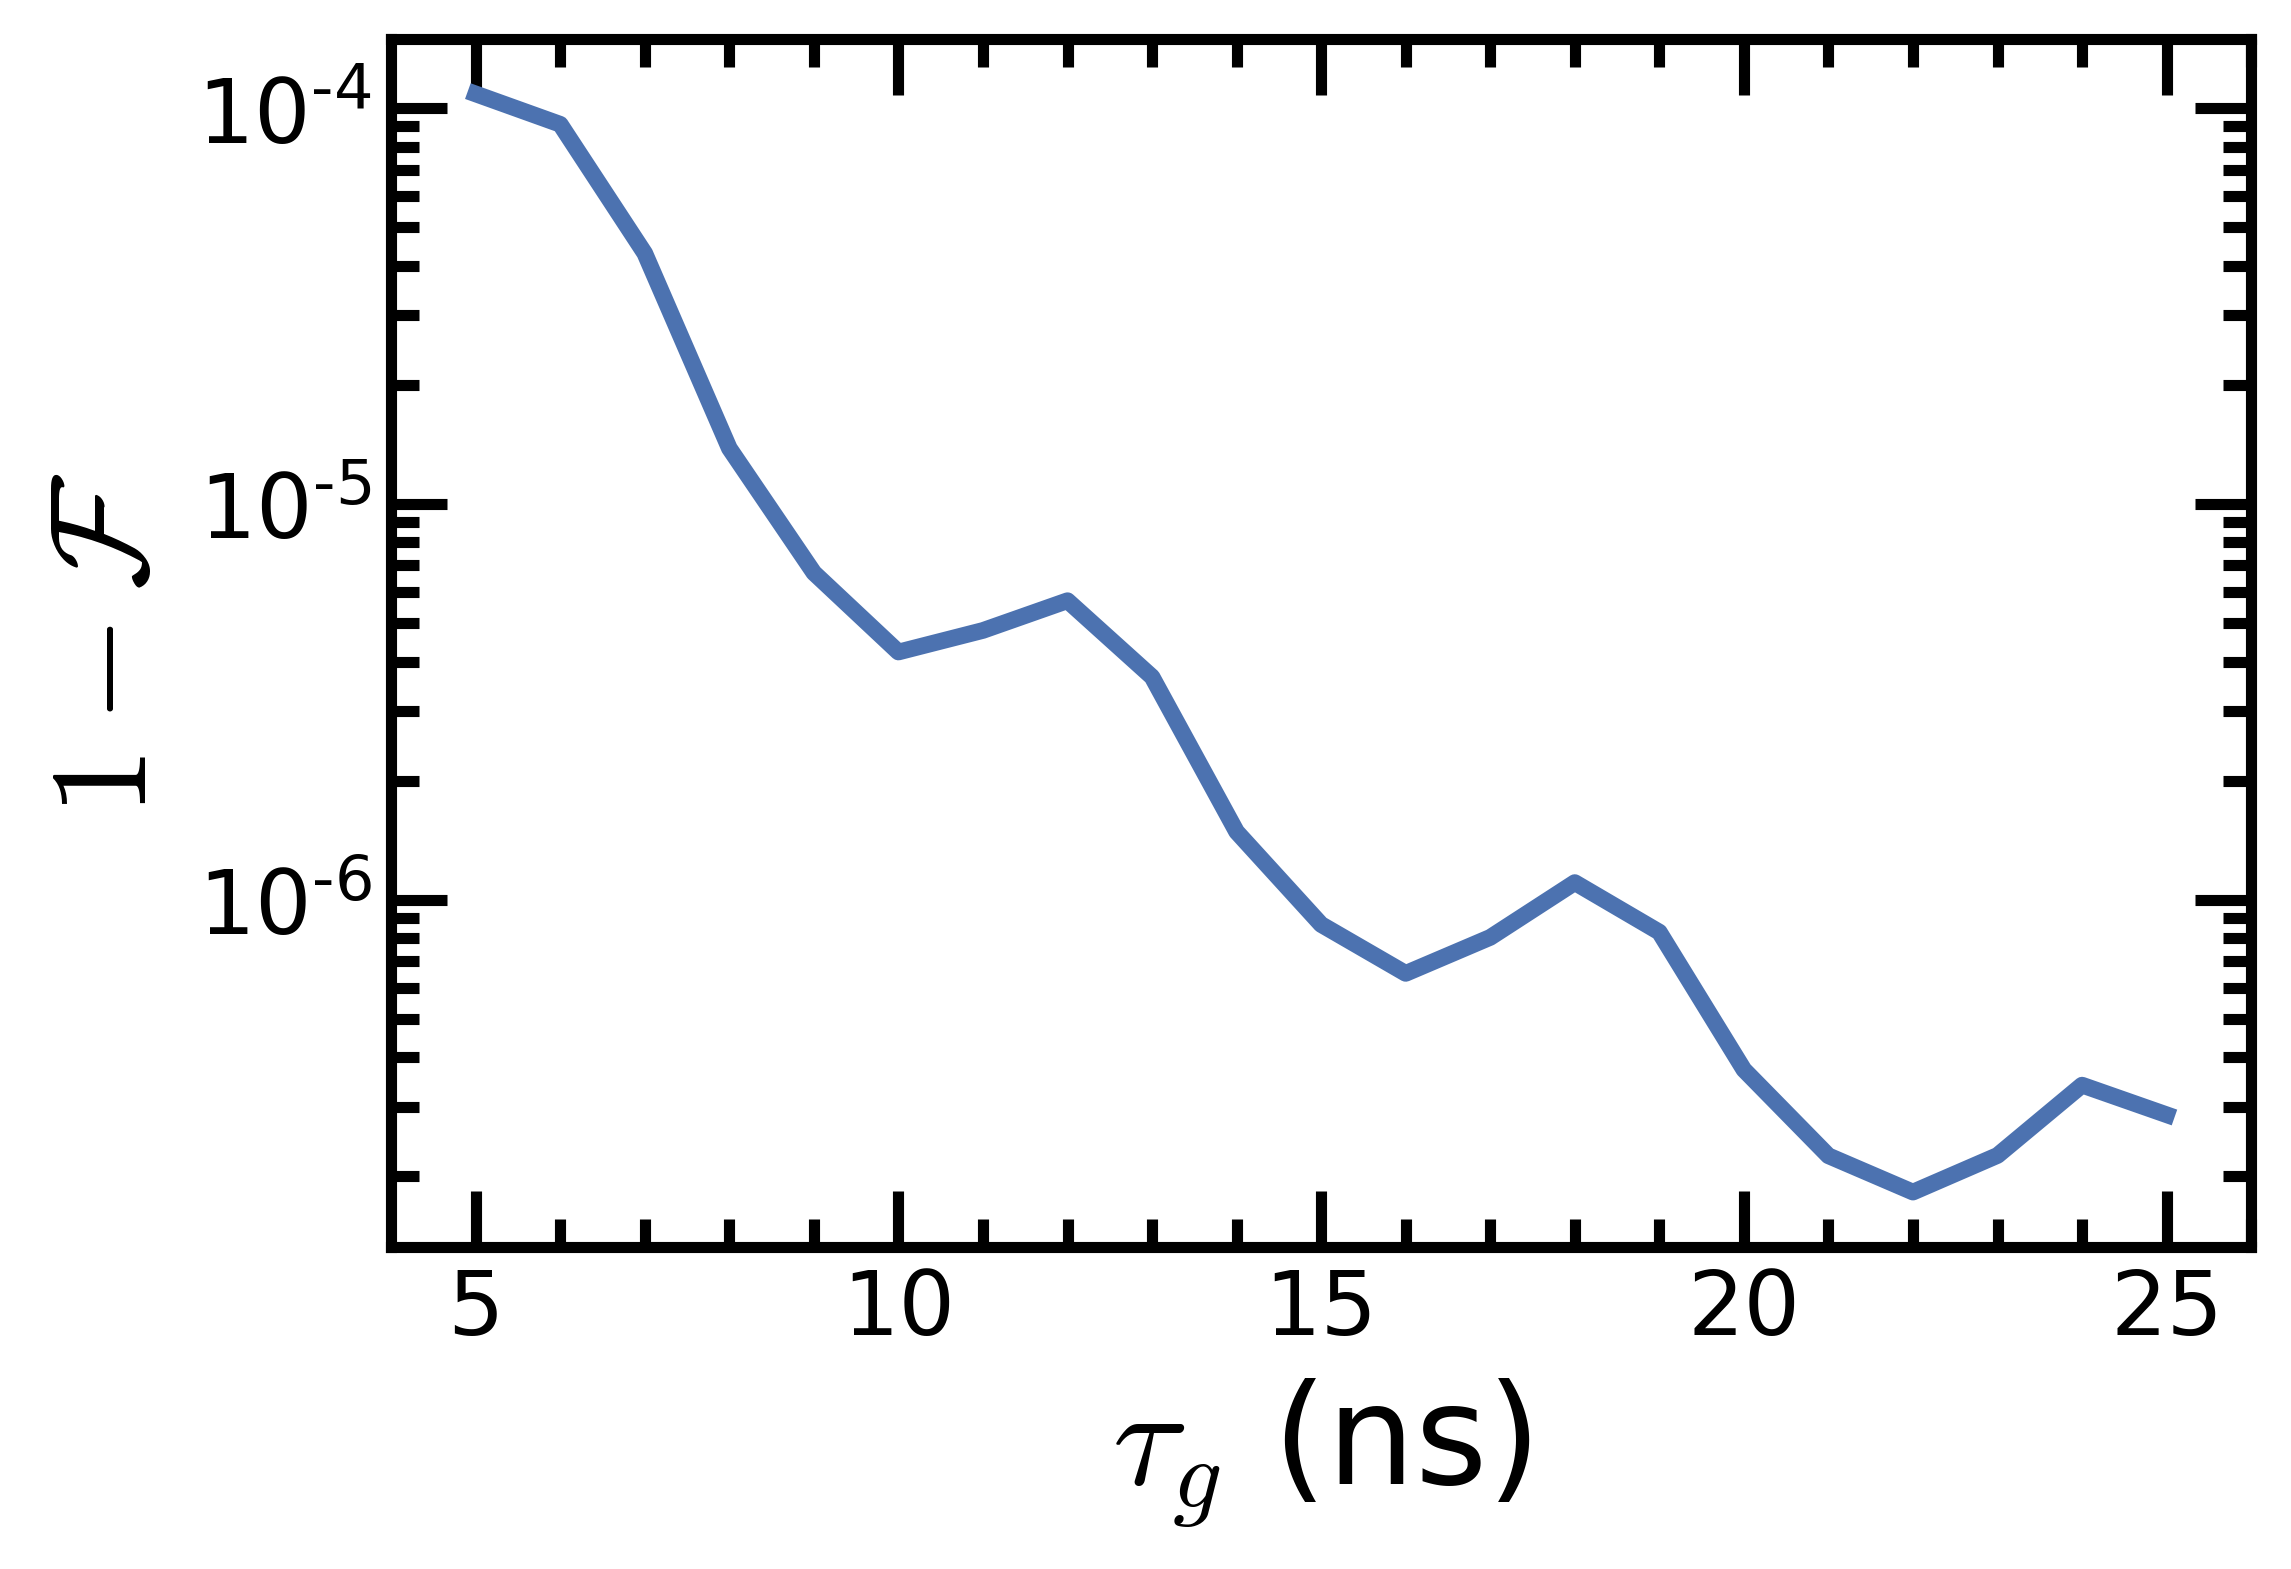

In [9]:
plt.semilogy(T_gate_array, error_array_charge)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

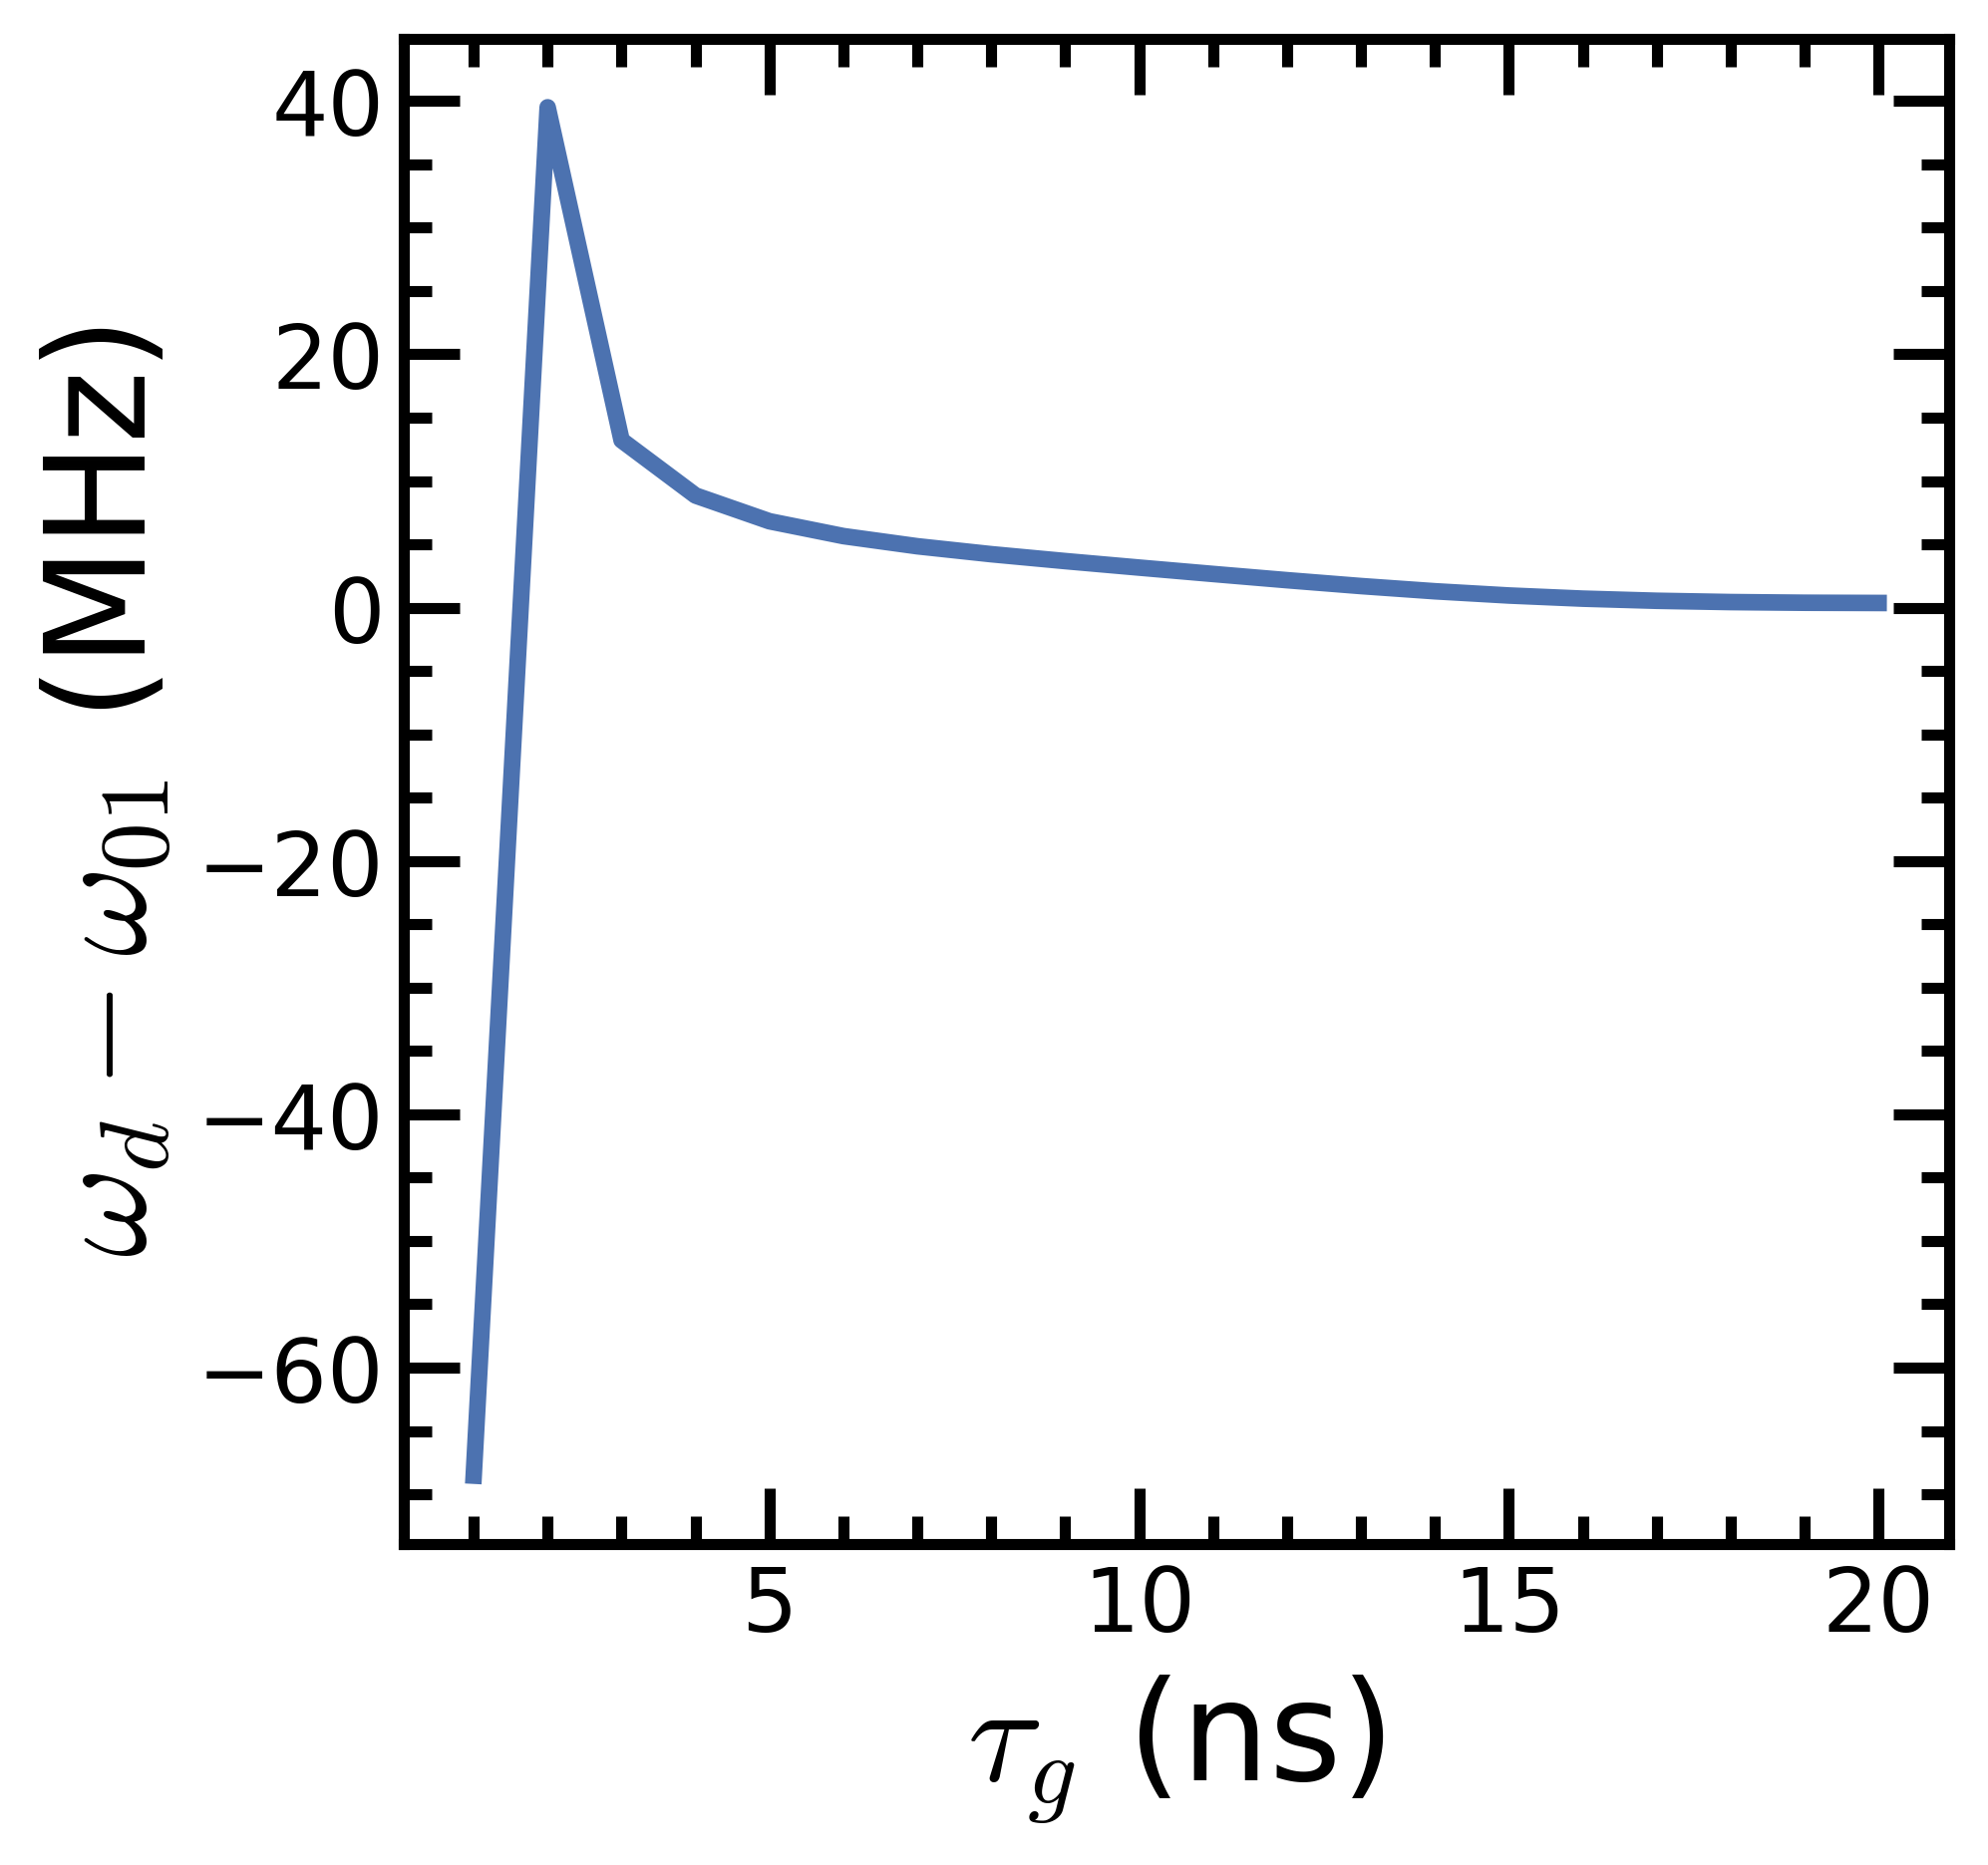

In [206]:
plt.figure(figsize = [5,5])
plt.plot(T_gate_array, delta_omega_d_array*1e3)
plt.ylabel(r'$\omega_d - \omega_{01}$ (MHz)')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

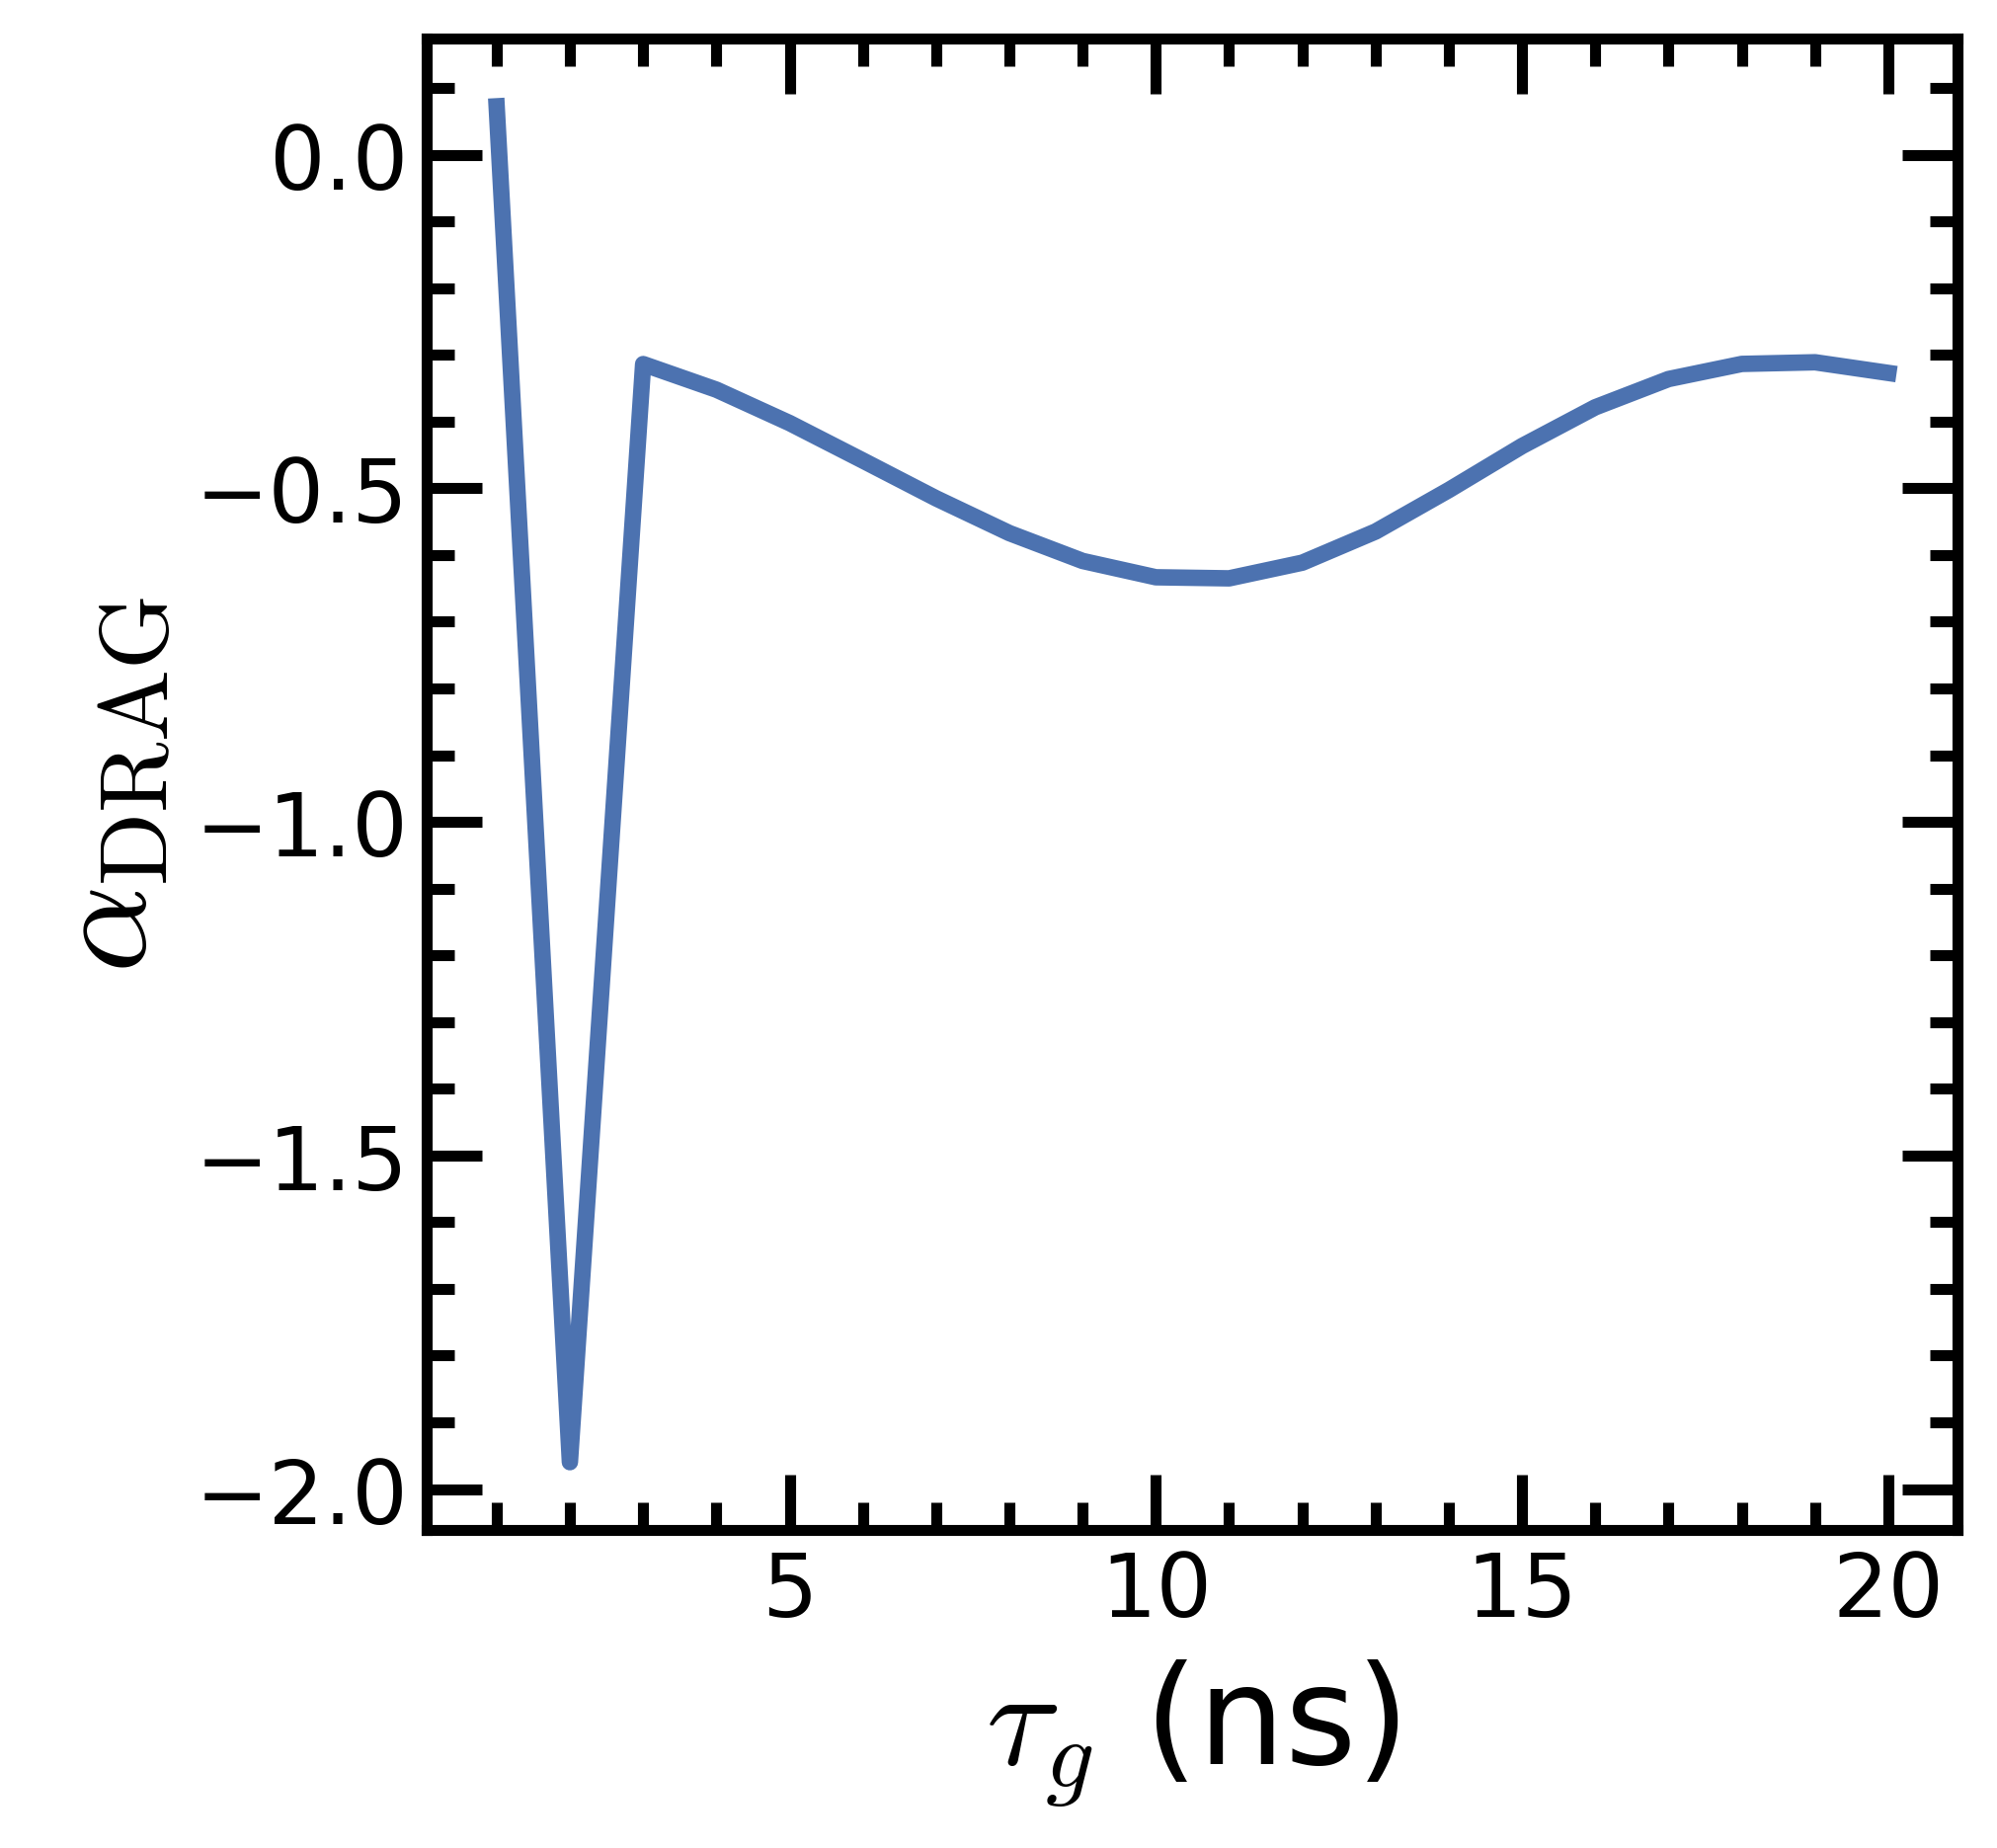

In [207]:
plt.figure(figsize = [5,5])
plt.plot(T_gate_array, drag_coeff_array)
plt.ylabel(r'$\alpha_\mathrm{DRAG}$')
plt.xlabel(r'$\tau_g$ (ns)')

## Flux driving

In [49]:
#Gate parameter
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
drive_amplitude_factor = 0.5
delta_omega_d = 0
shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0

comp_space = [0,1]
omega_d = qubit.freq(0,1) + delta_omega_d
matr_el = np.abs(qubit.phi_ij(0,1))
epsilon = drive_amplitude_factor/matr_el
H_drive = epsilon*(qubit.phi())
H_dummy = 0*(qubit.phi())
U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

99.93811181980402


Text(0.5, 1.0, '$\\mathcal{F}=$0.999381')

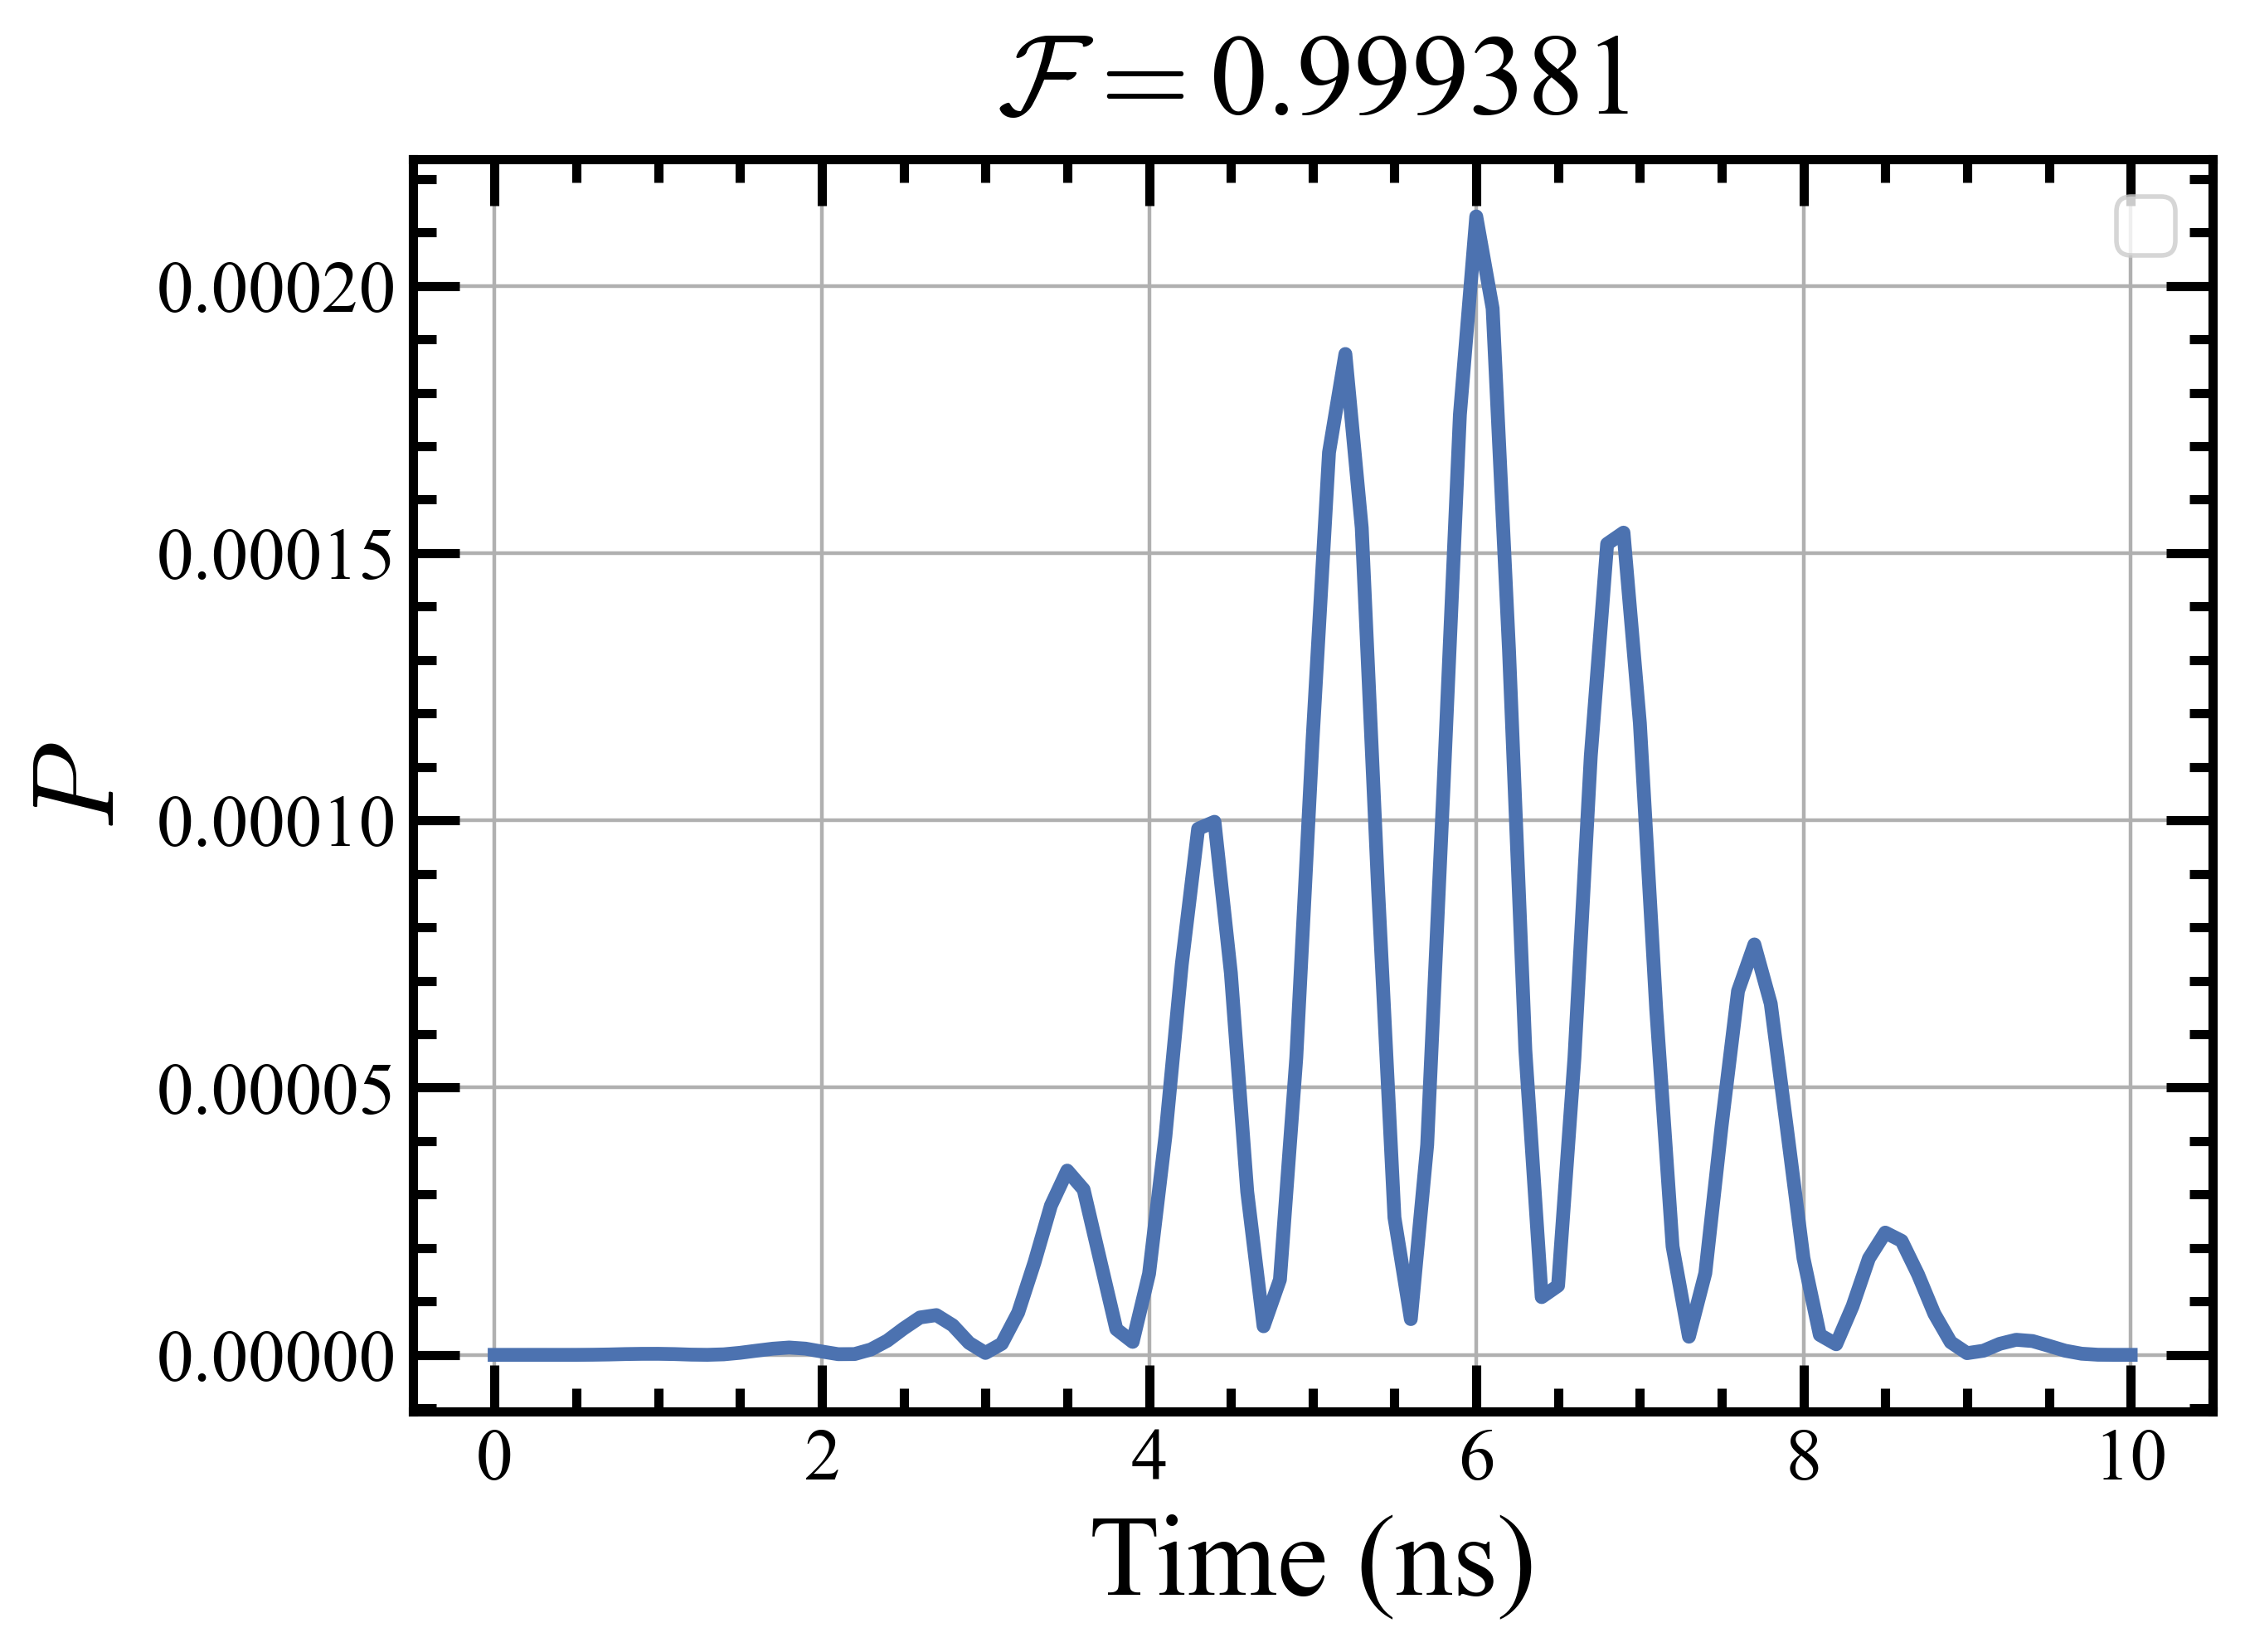

In [51]:
#Plotting results
state_0 = basis(nlev_single,0)
state_1 = basis(nlev_single,1)
state_2 = basis(nlev_single,2)
state_3 = basis(nlev_single,3)

#Fidelity
U_ideal = sigmax()
U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(fidel*100)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)
leakage_flux = 1 - trans_prob_0 - trans_prob_1

plt.figure(figsize = [7,5])
# plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
# plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
# plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
# plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.plot(t_points, leakage_flux)
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

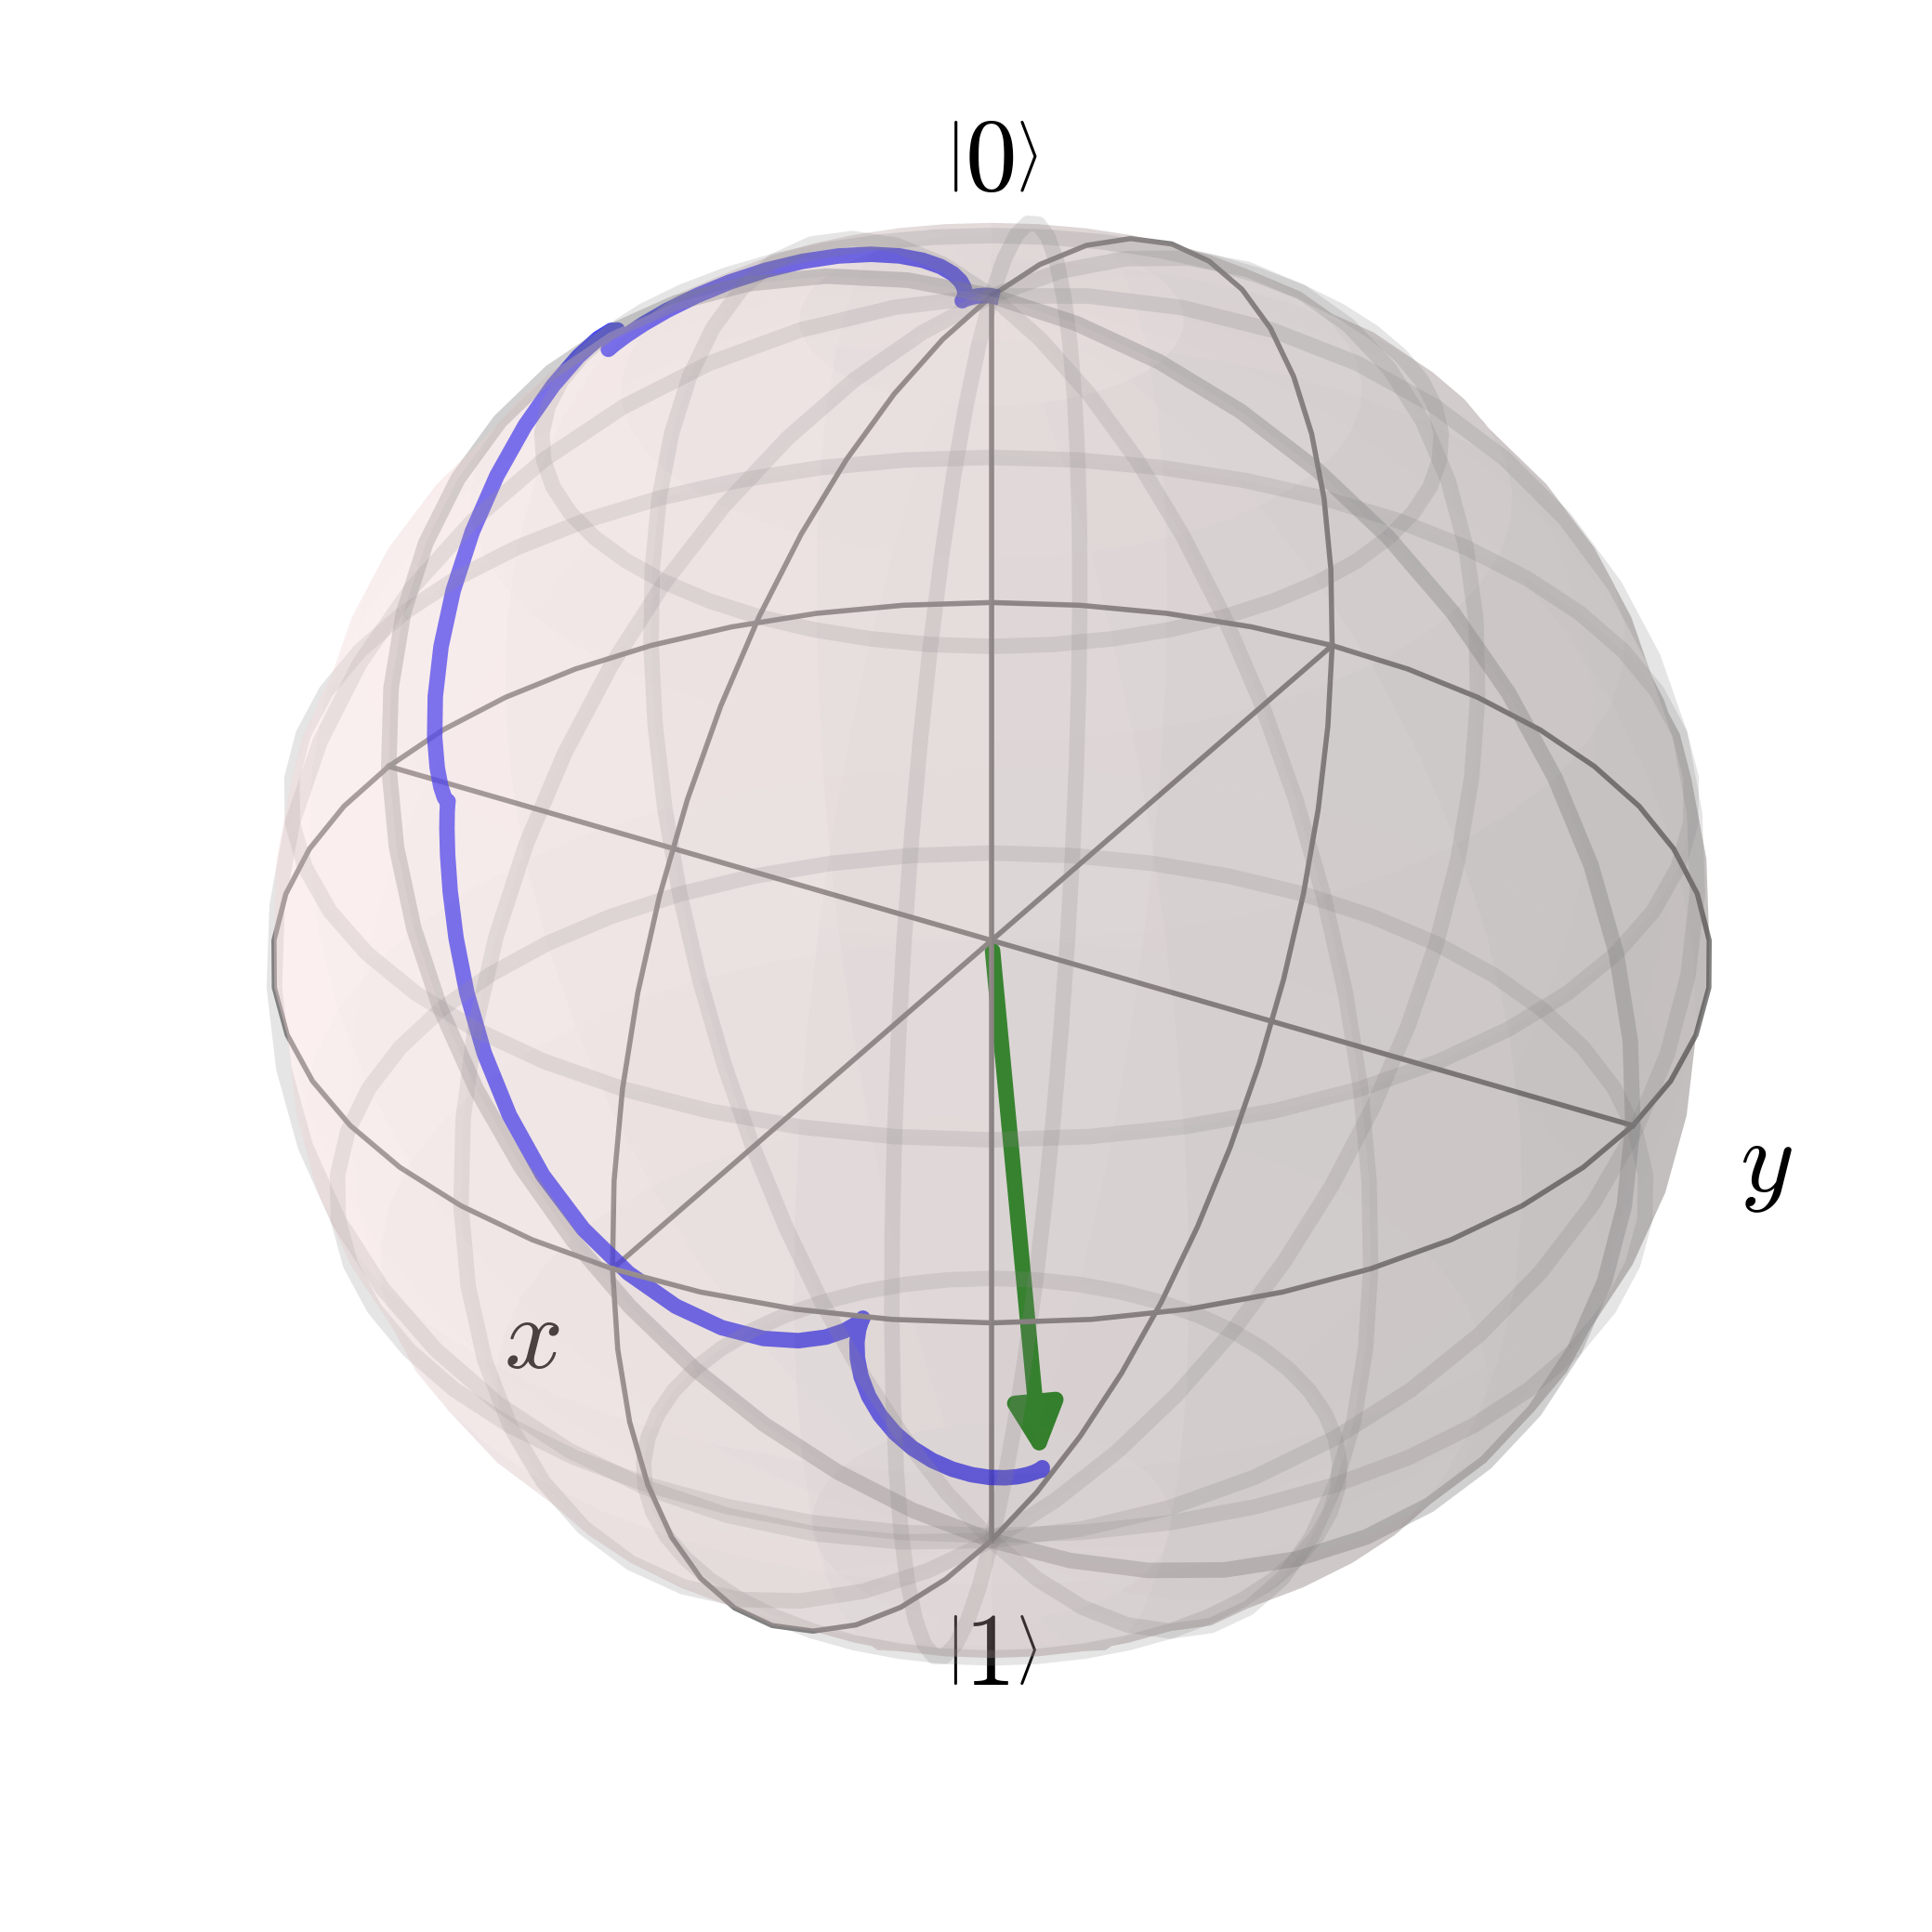

In [87]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

### Optimization

In [51]:
def infidelity(x):
    delta_omega_d = x[0]
    drag_coeff = x[1]
    omega_d = qubit.freq(0,1) + delta_omega_d
    U_t = gates.evolution_operator_microwave(
                qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    U_real = U_nothing[-1]*U_t[-1]
    U_real = Qobj(U_real[0:2, 0:2])

    op1 = U_real.dag() * U_real
    op2 = U_real * U_ideal.dag()
    fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
    return 1-fidel

x0 = [0,0]
xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-6)
print (xopt.x)
print (infidelity(xopt.x))

[-8.49875299e-07  7.53508212e-02]
1.169041157766948e-06


1.169041157766948e-06


Text(0.5, 1.0, '$\\mathcal{F}=$0.999999')

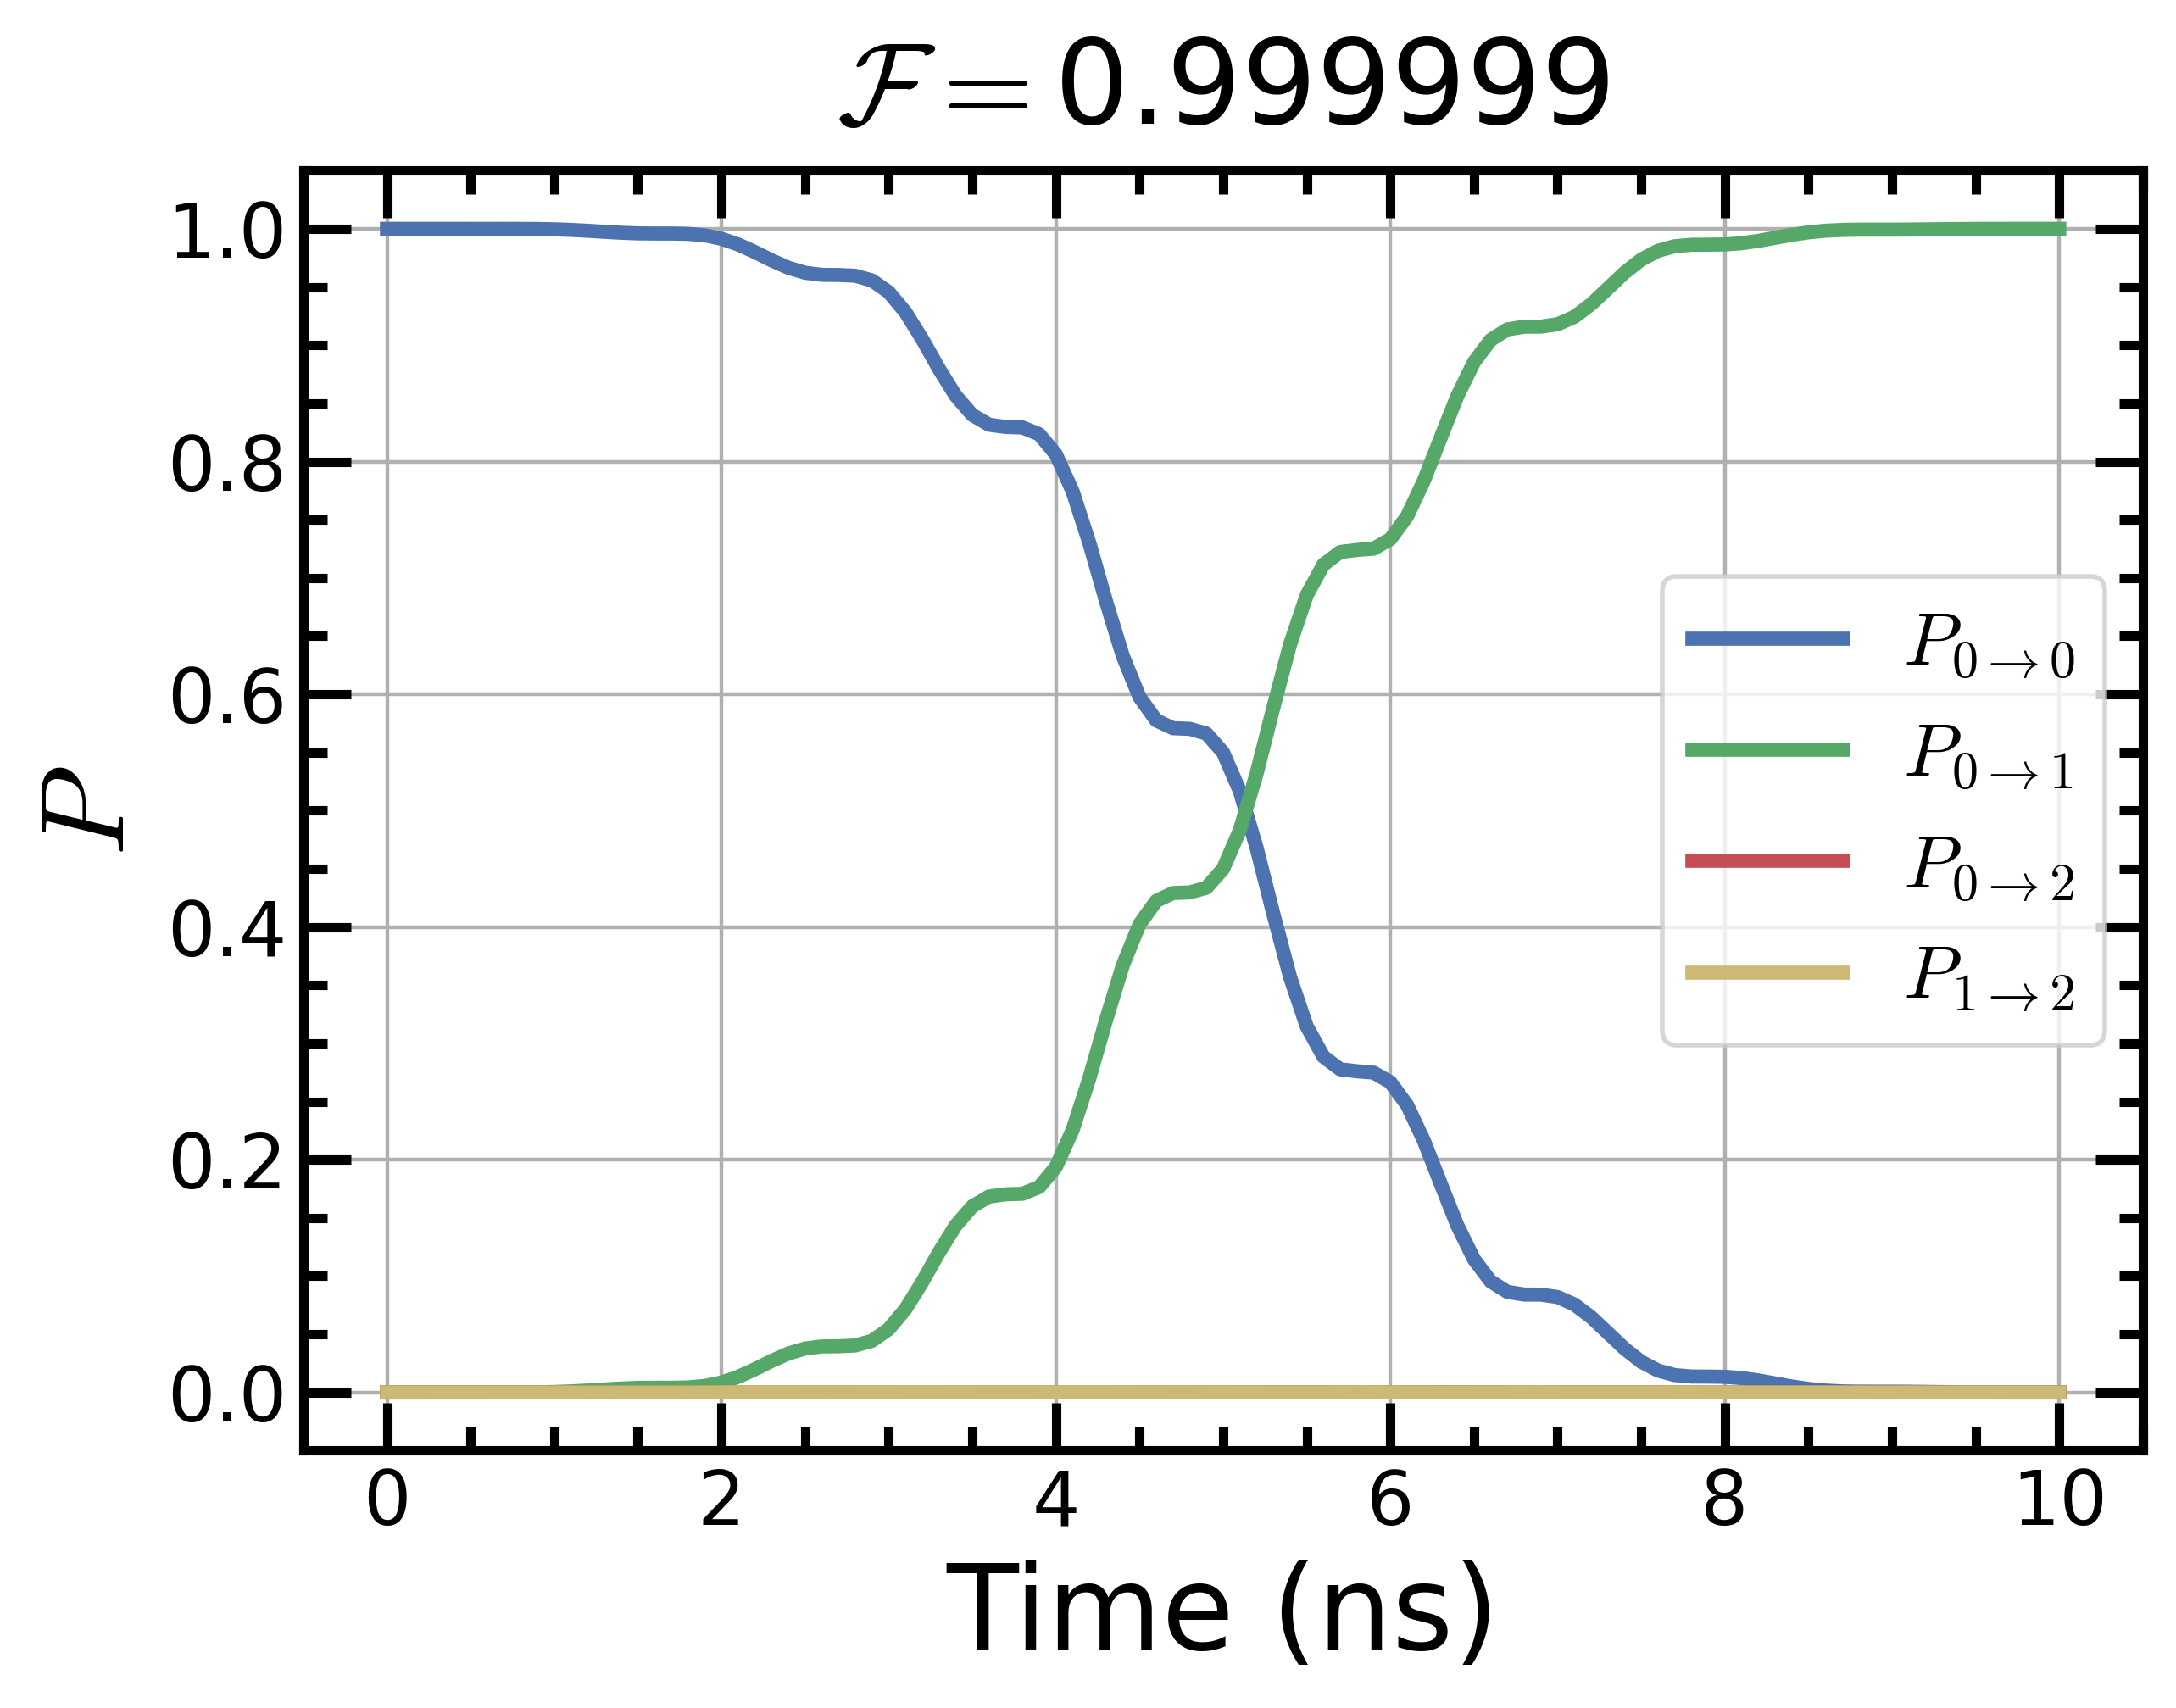

In [52]:
delta_omega_d=xopt.x[0]
drag_coeff = xopt.x[1]
omega_d = qubit.freq(0,1) + delta_omega_d
U_t = gates.evolution_operator_microwave(
        qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
        T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)

U_real = U_nothing[-1]*U_t[-1]
U_real = Qobj(U_real[0:2, 0:2])

op1 = U_real.dag() * U_real
op2 = U_real * U_ideal.dag()
fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
print(1-fidel)

trans_prob_0 = gates.prob_transition(U_t, state_0, state_0)
trans_prob_1 = gates.prob_transition(U_t, state_0, state_1)
trans_prob_2 = gates.prob_transition(U_t, state_0, state_2)
trans_prob_3 = gates.prob_transition(U_t, state_1, state_2)

plt.figure(figsize = [7,5])
plt.plot(t_points, trans_prob_0, label=r'$P_{0\rightarrow 0}$')
plt.plot(t_points, trans_prob_1, label=r'$P_{0\rightarrow 1}$')
plt.plot(t_points, trans_prob_2, label=r'$P_{0\rightarrow 2}$')
plt.plot(t_points, trans_prob_3, color = 'C4', label=r'$P_{1\rightarrow 2}$')
plt.xlabel('Time (ns)')
plt.ylabel(r'$P$')
plt.legend()
plt.grid()
plt.title(r'$\mathcal{F}=$'+str(np.round(fidel,6)))

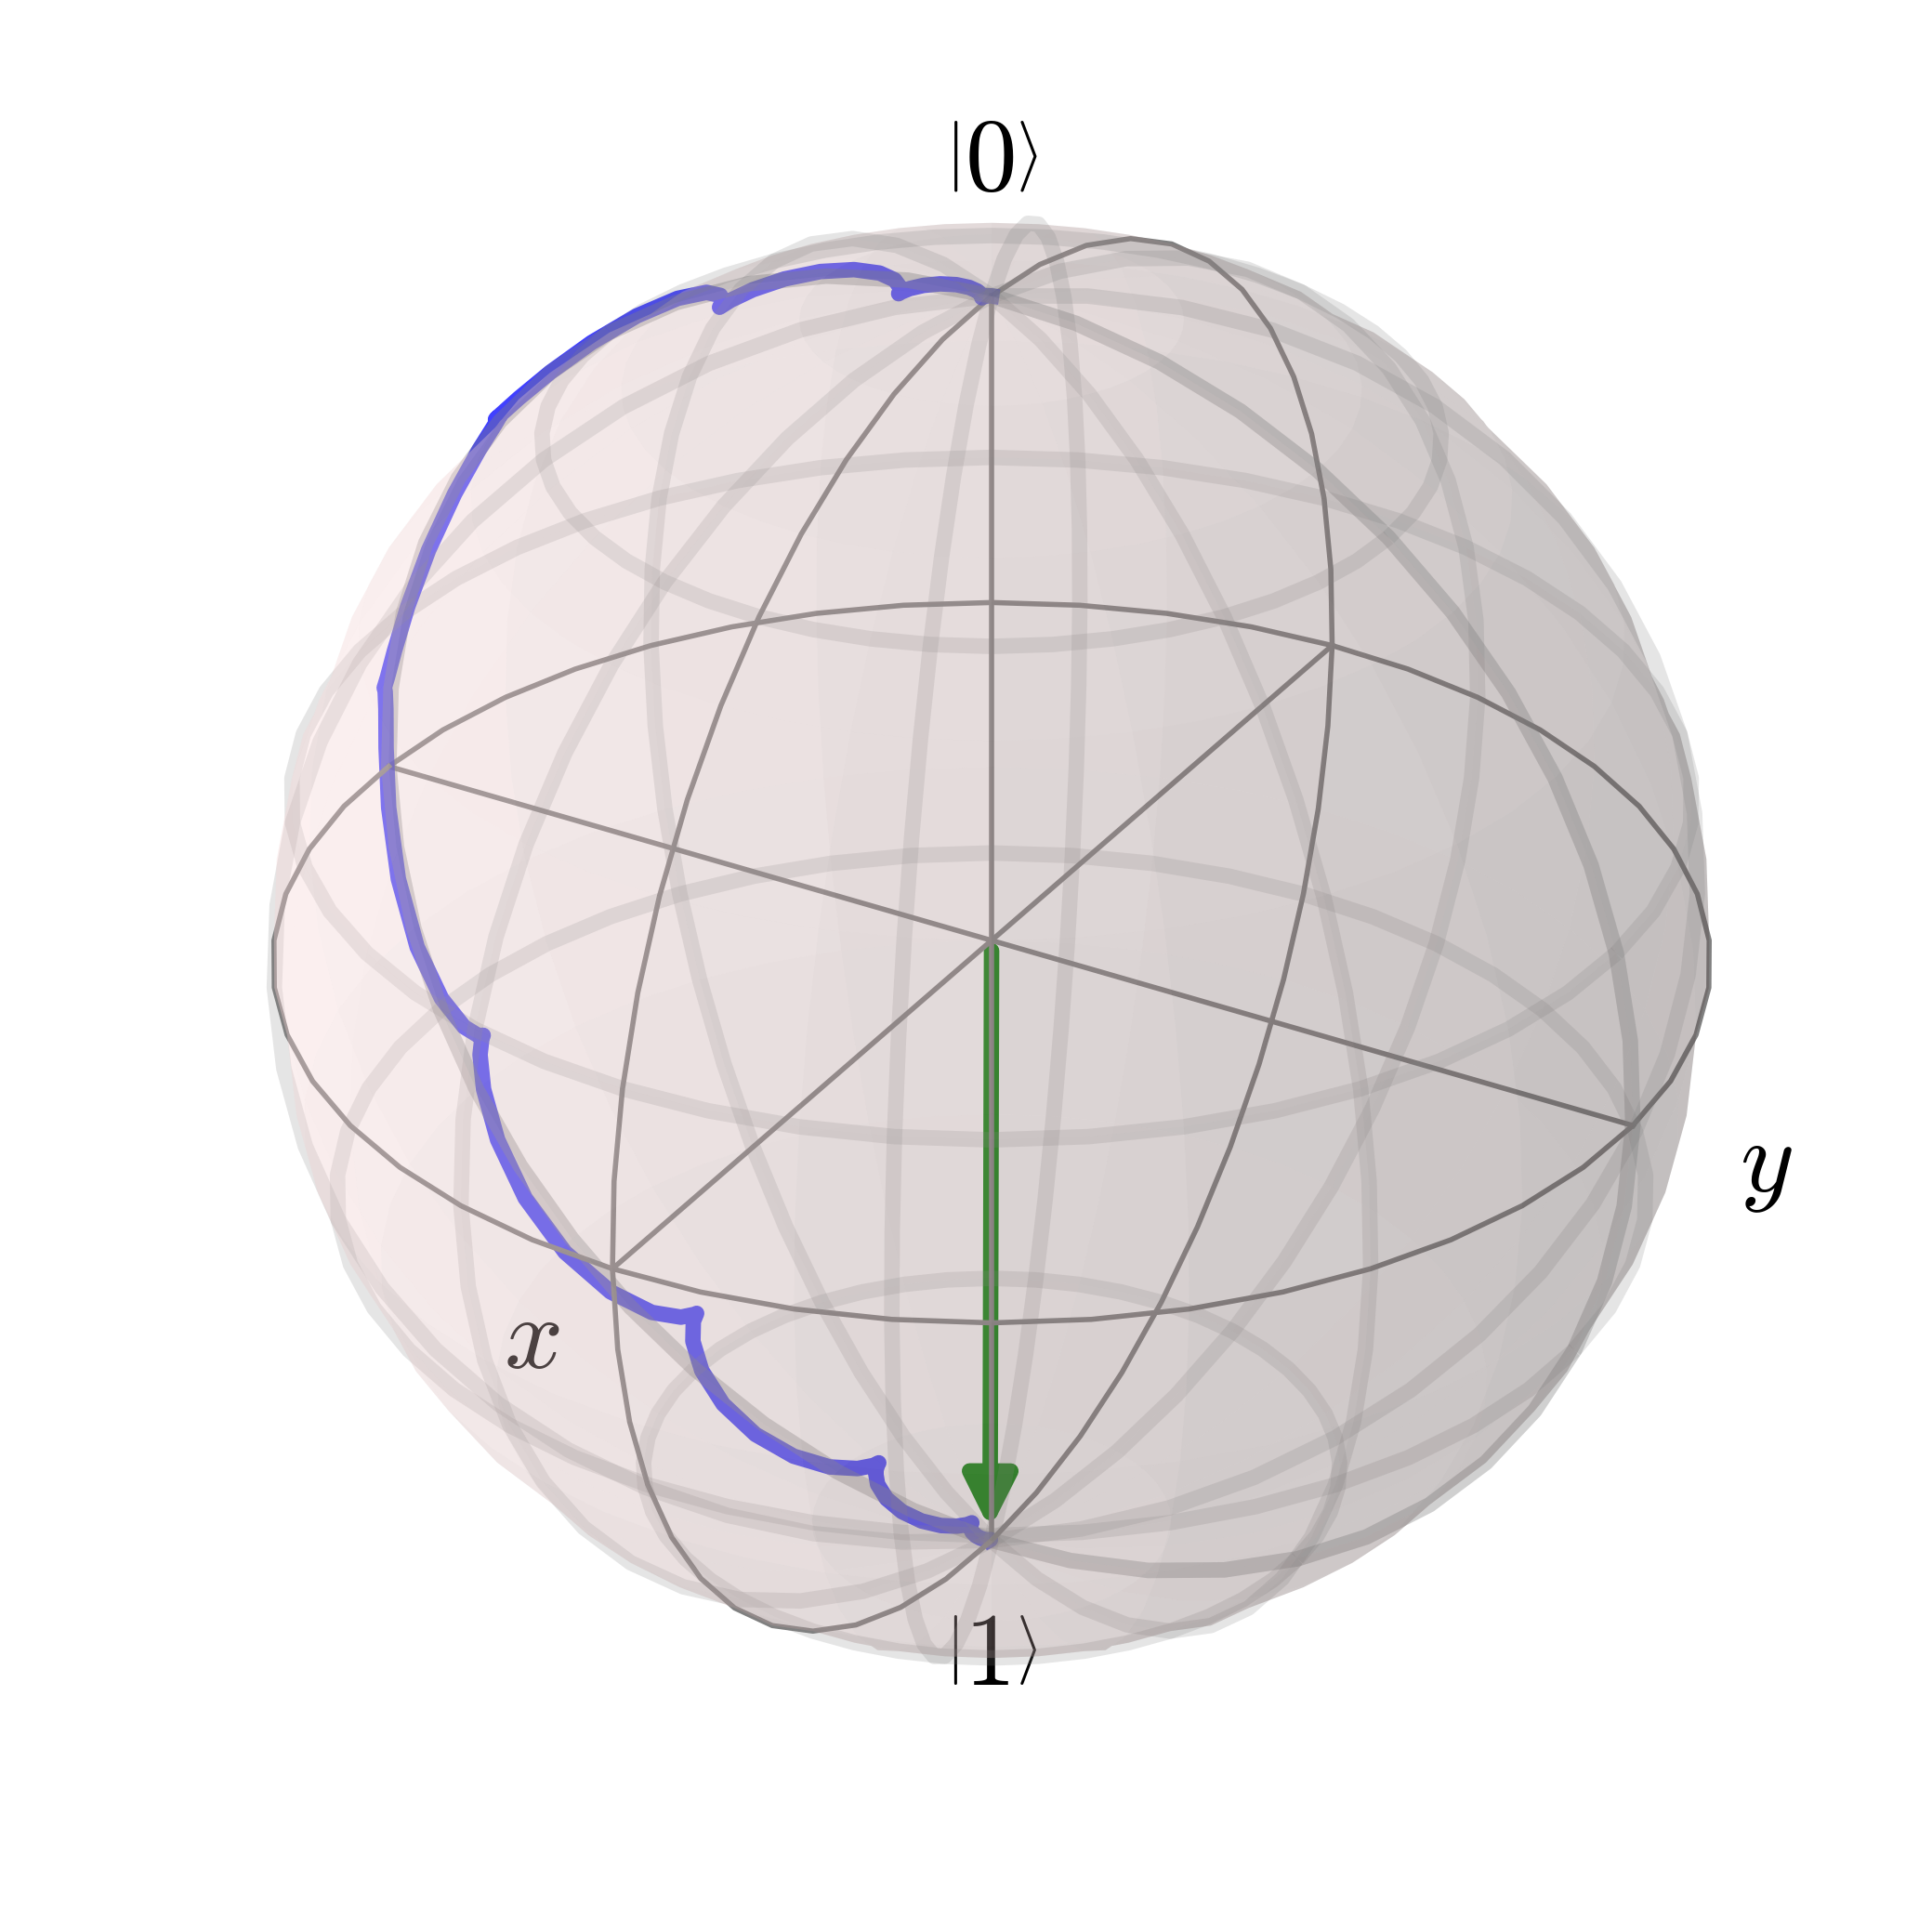

In [53]:
# Trajectory on Bloch sphere
state_evol = U_nothing * U_t * state_0

sz = np.real(expect(op.sigz(N=nlev_single),state_evol))
sx = np.real(expect(op.sigx(N=nlev_single),state_evol))
sy = np.real(expect(op.sigy(N=nlev_single),state_evol))

b = Bloch()
b.add_points([sx, sy, sz], meth ='l')
b.add_vectors([sx[-1], sy[-1], sz[-1]])
b.make_sphere()

### Sweeping gate time

In [12]:
#Gate parameter
T_gate_array = np.linspace(5,25,21) #ns
error_array_flux = np.zeros_like(T_gate_array)
drag_coeff_array = np.zeros_like(T_gate_array)
delta_omega_d_array = np.zeros_like(T_gate_array)

drive_amplitude_factor = 0.5
U_ideal = sigmax()

shape = 'gauss'
sigma = 0.25
drag = True
drag_coeff = 0.0
delta_omega_d = 0

for T_idx, T_gate in enumerate(T_gate_array):
  
    t_points = np.linspace(0, T_gate, 2 * int(T_gate) + 1)
    delta_omega_d = 0
    drag_coeff = 0
    U_nothing = gates.evolution_operator_microwave(
                -qubit.H(), H_dummy, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
    def infidelity(x):
        delta_omega_d = x[0]
        drag_coeff = x[1]
        omega_d = qubit.freq(0,1) + delta_omega_d
        U_t = gates.evolution_operator_microwave(
                    qubit.H(), H_drive, t_points=t_points, DRAG = drag, DRAG_coefficient = drag_coeff,
                    T_gate=T_gate, shape=shape, sigma=sigma, omega_d=omega_d)
        U_real = U_nothing[-1]*U_t[-1]
        U_real = Qobj(U_real[0:2, 0:2])

        op1 = U_real.dag() * U_real
        op2 = U_real * U_ideal.dag()
        fidel = (op1.tr() + (abs(op2.tr())) ** 2) / 6.0
        return 1-fidel

    if T_idx == 0:    
        x0 = [0,0]
    else:
        x0 = [xopt.x[0],xopt.x[1]]
    xopt = minimize(infidelity, x0, method ='Powell', tol = 1e-8)
    
    error_array_flux[T_idx] = infidelity(xopt.x)
    drag_coeff_array[T_idx] = xopt.x[1]
    delta_omega_d_array[T_idx] = xopt.x[0]

Text(0.5, 0, '$\\tau_g$ (ns)')

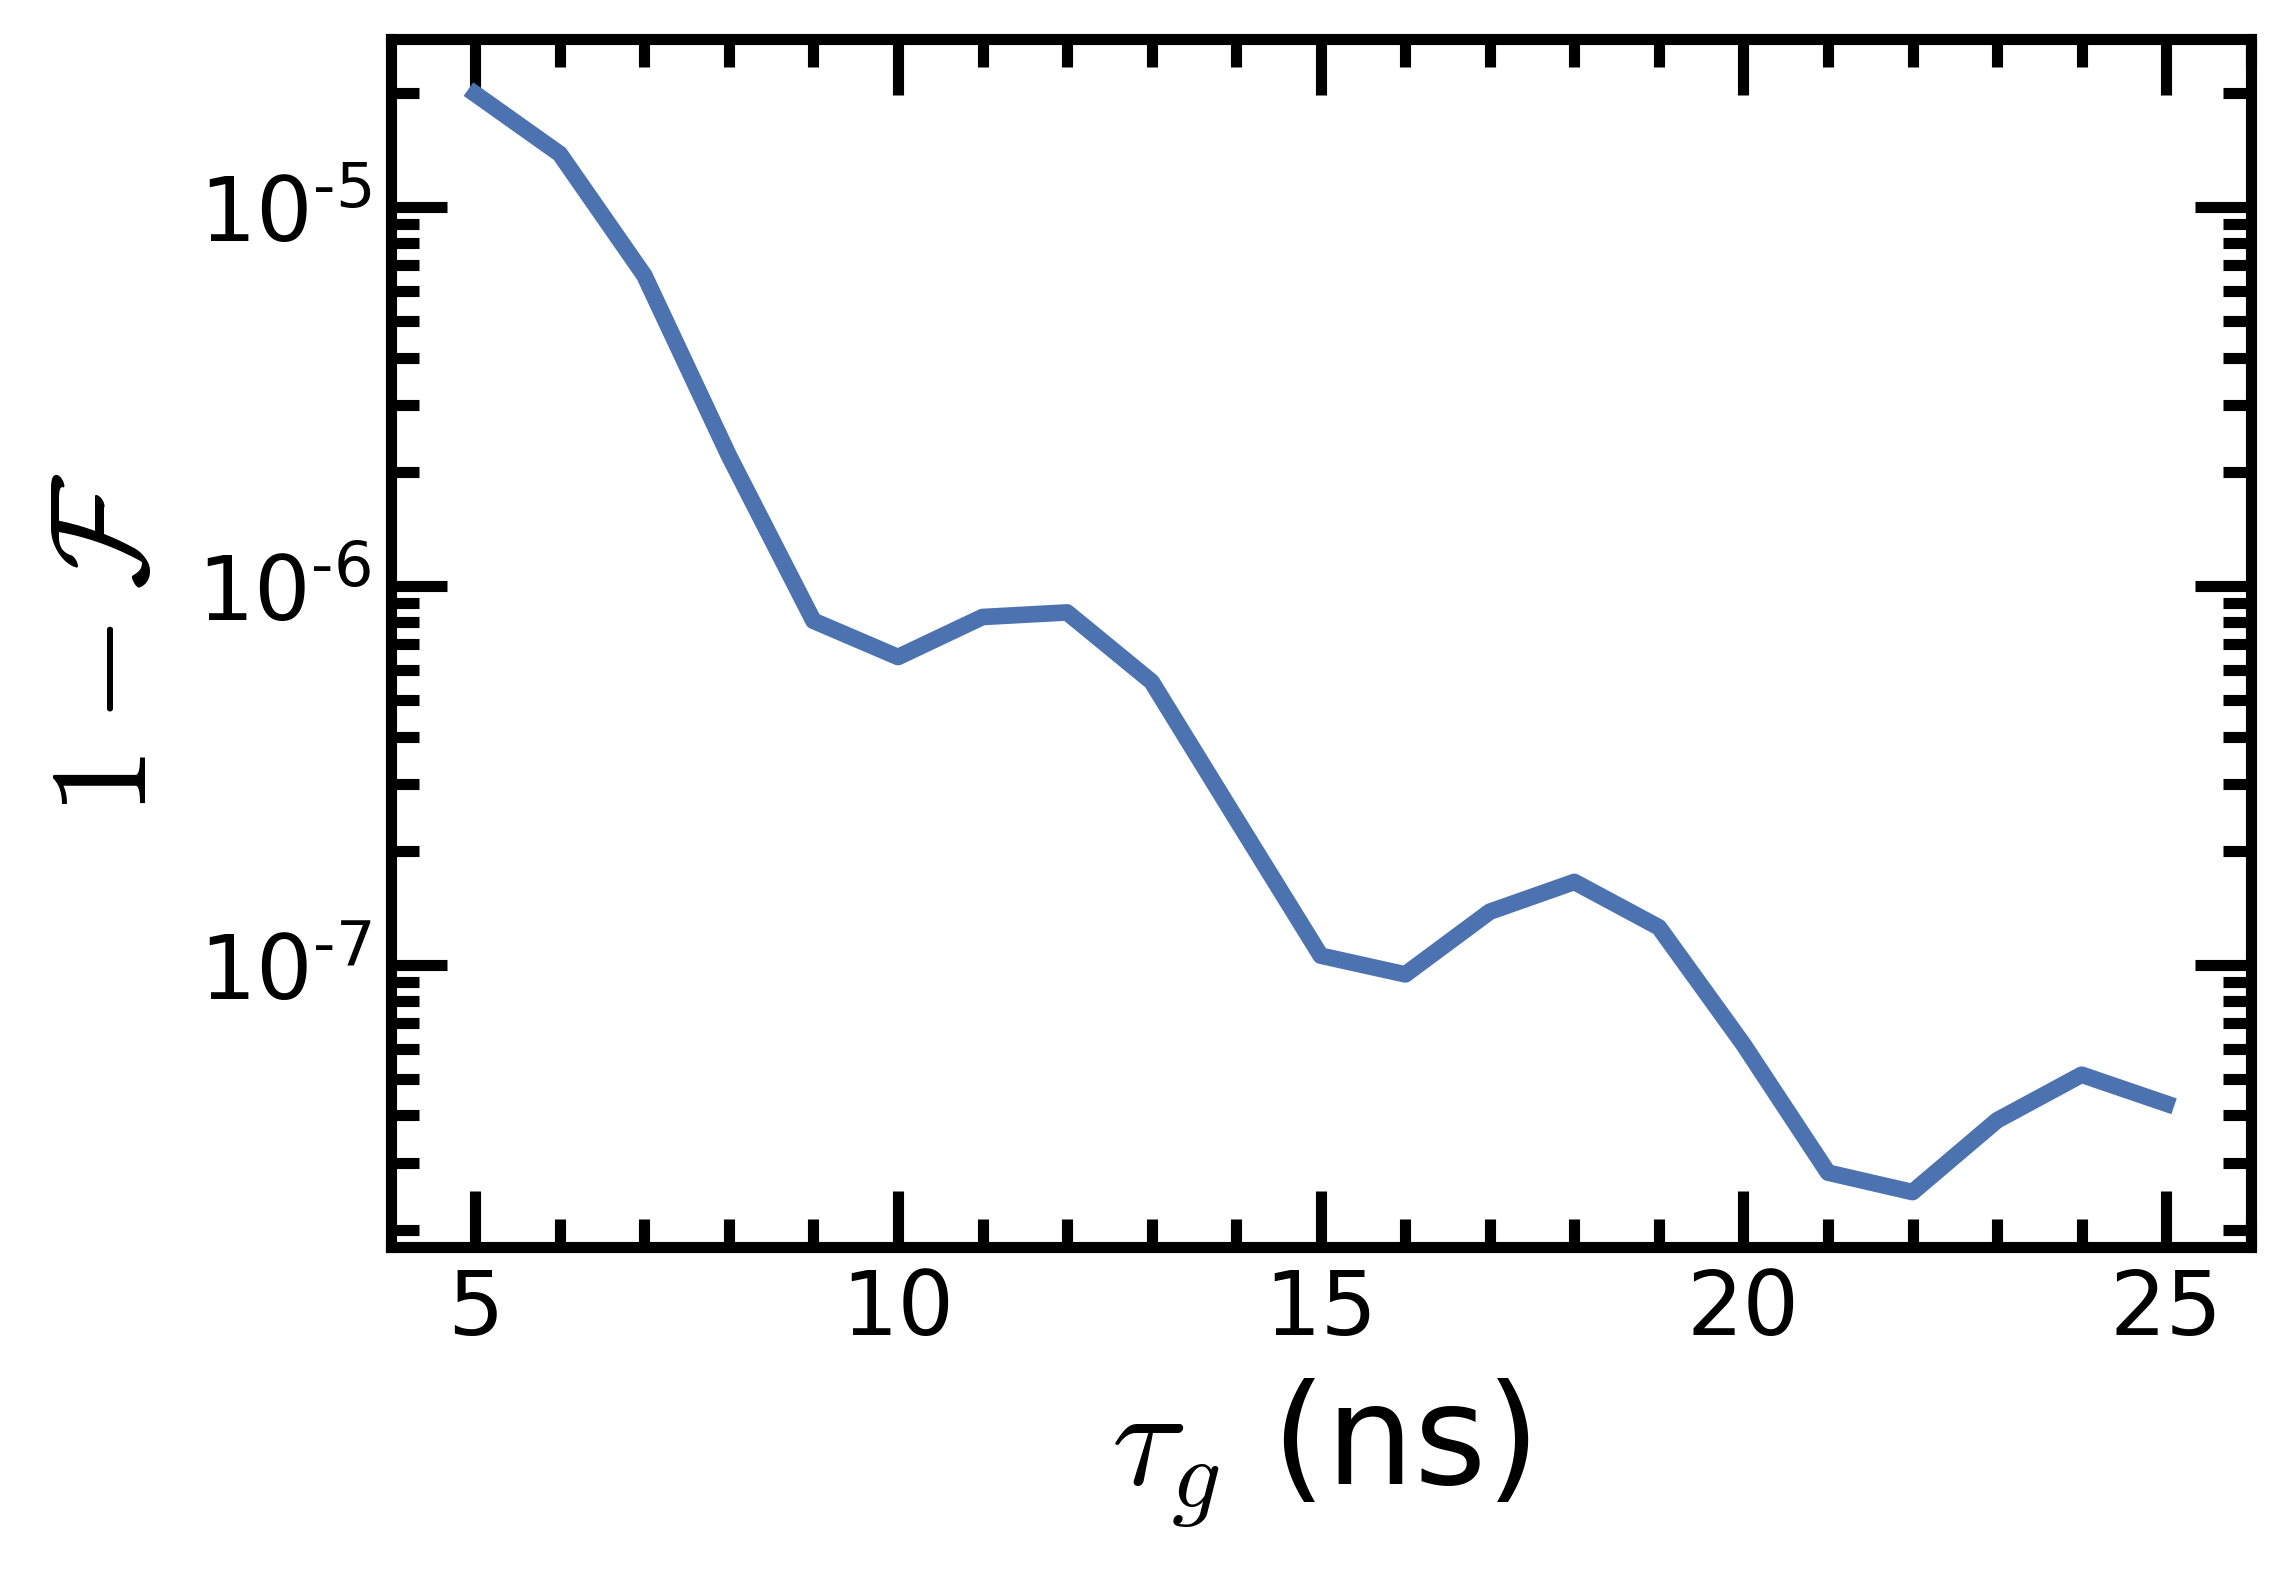

In [13]:
plt.semilogy(T_gate_array, error_array_flux)
plt.ylabel(r'$1-\mathcal{F}$')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

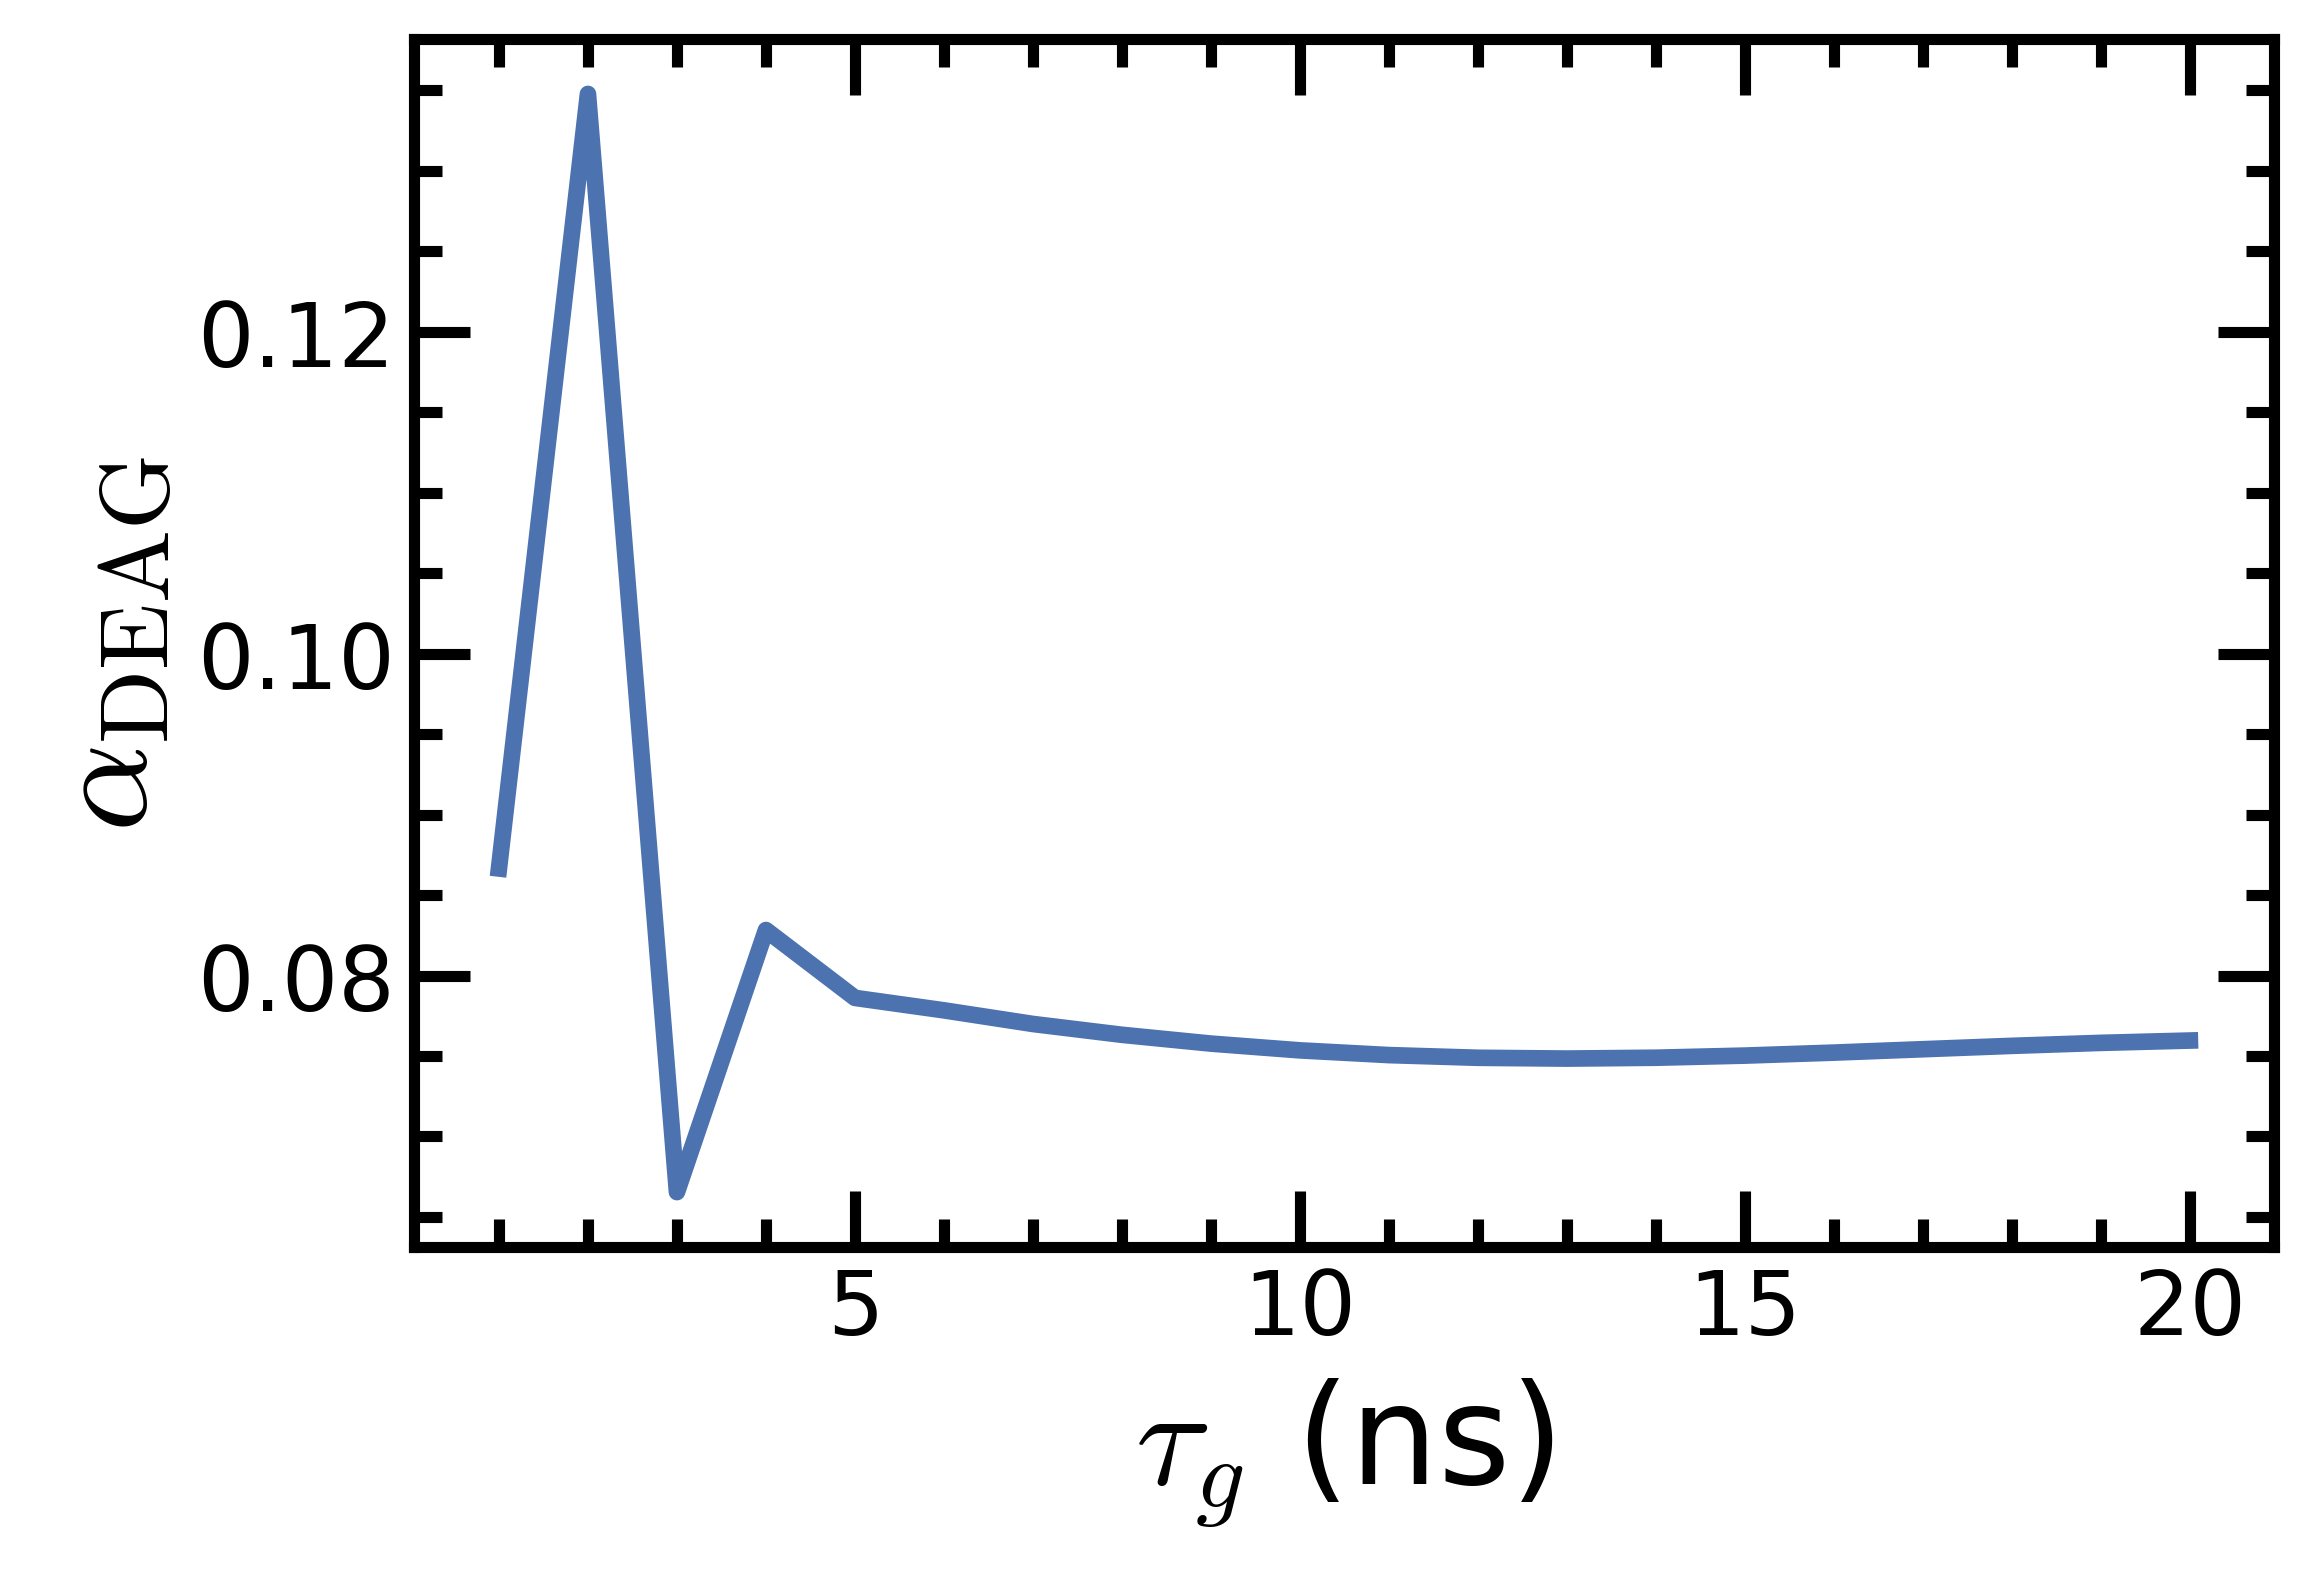

In [56]:
plt.plot(T_gate_array, drag_coeff_array)
plt.ylabel(r'$\alpha_\mathrm{DEAG}$')
plt.xlabel(r'$\tau_g$ (ns)')

Text(0.5, 0, '$\\tau_g$ (ns)')

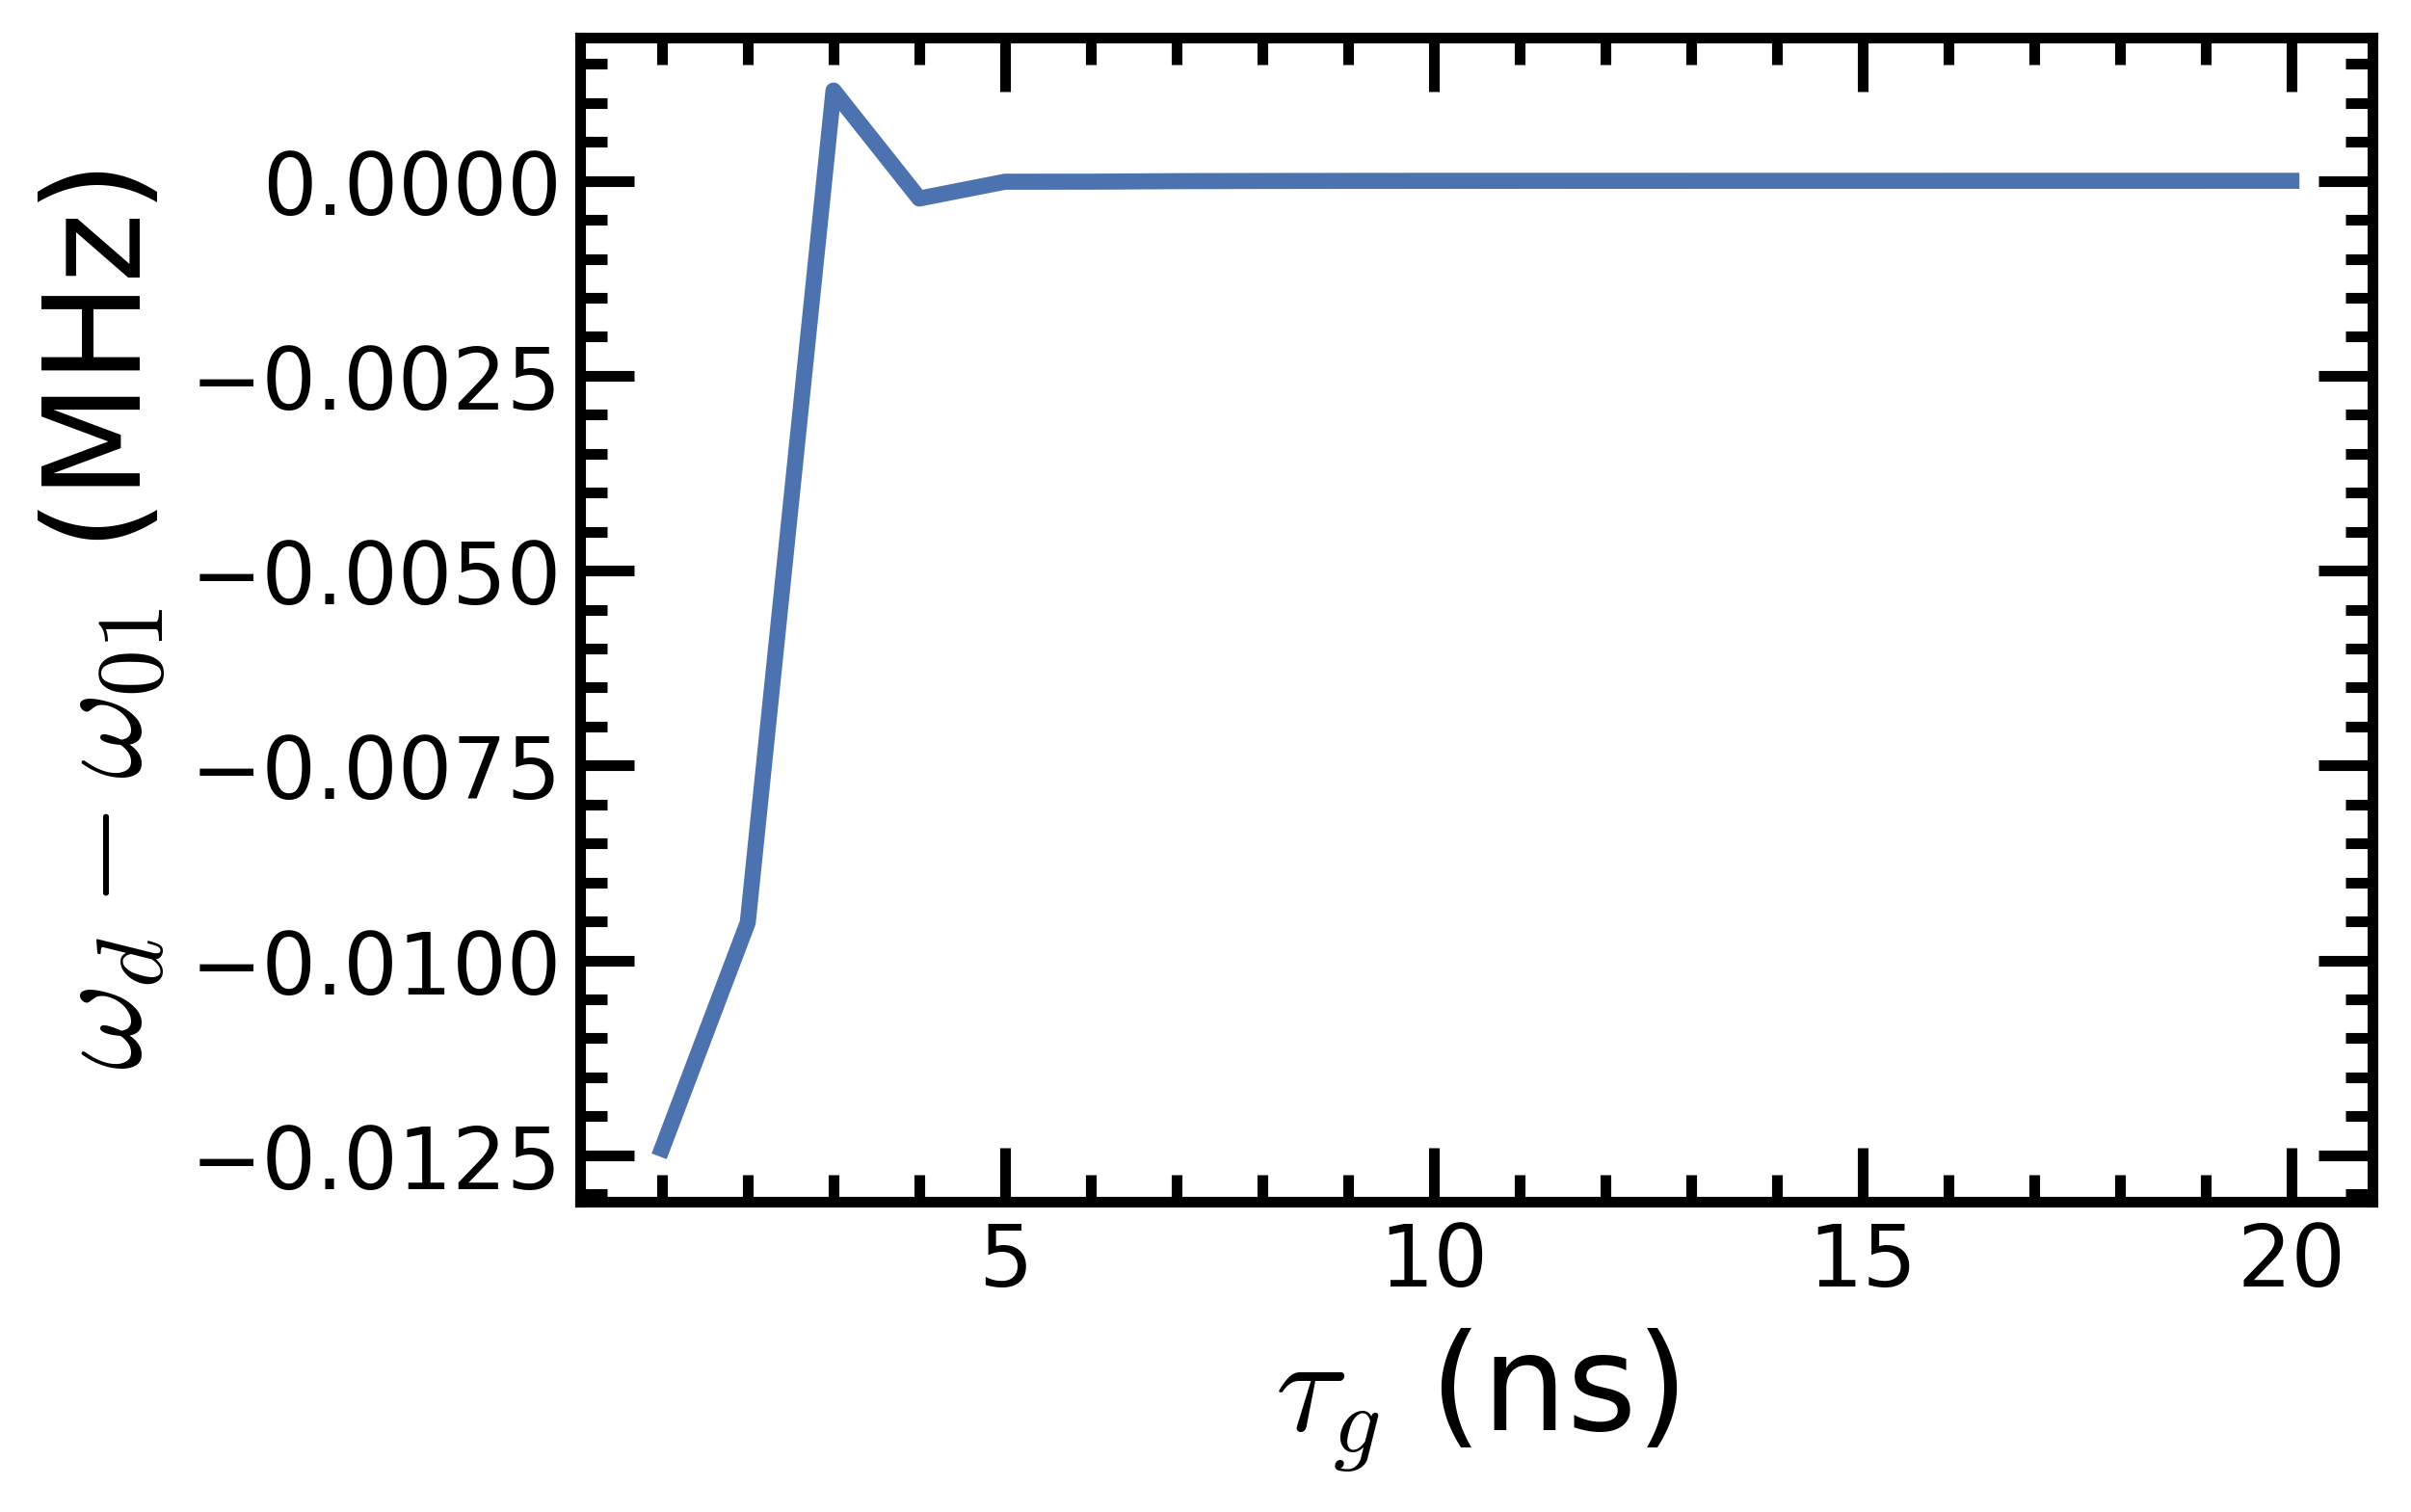

In [57]:
plt.plot(T_gate_array, delta_omega_d_array)
plt.ylabel(r'$\omega_d-\omega_{01}$ (MHz)')
plt.xlabel(r'$\tau_g$ (ns)')

# Plots for paper

<ipython-input-52-48ae311ec73c>:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([-0.001,0.015])


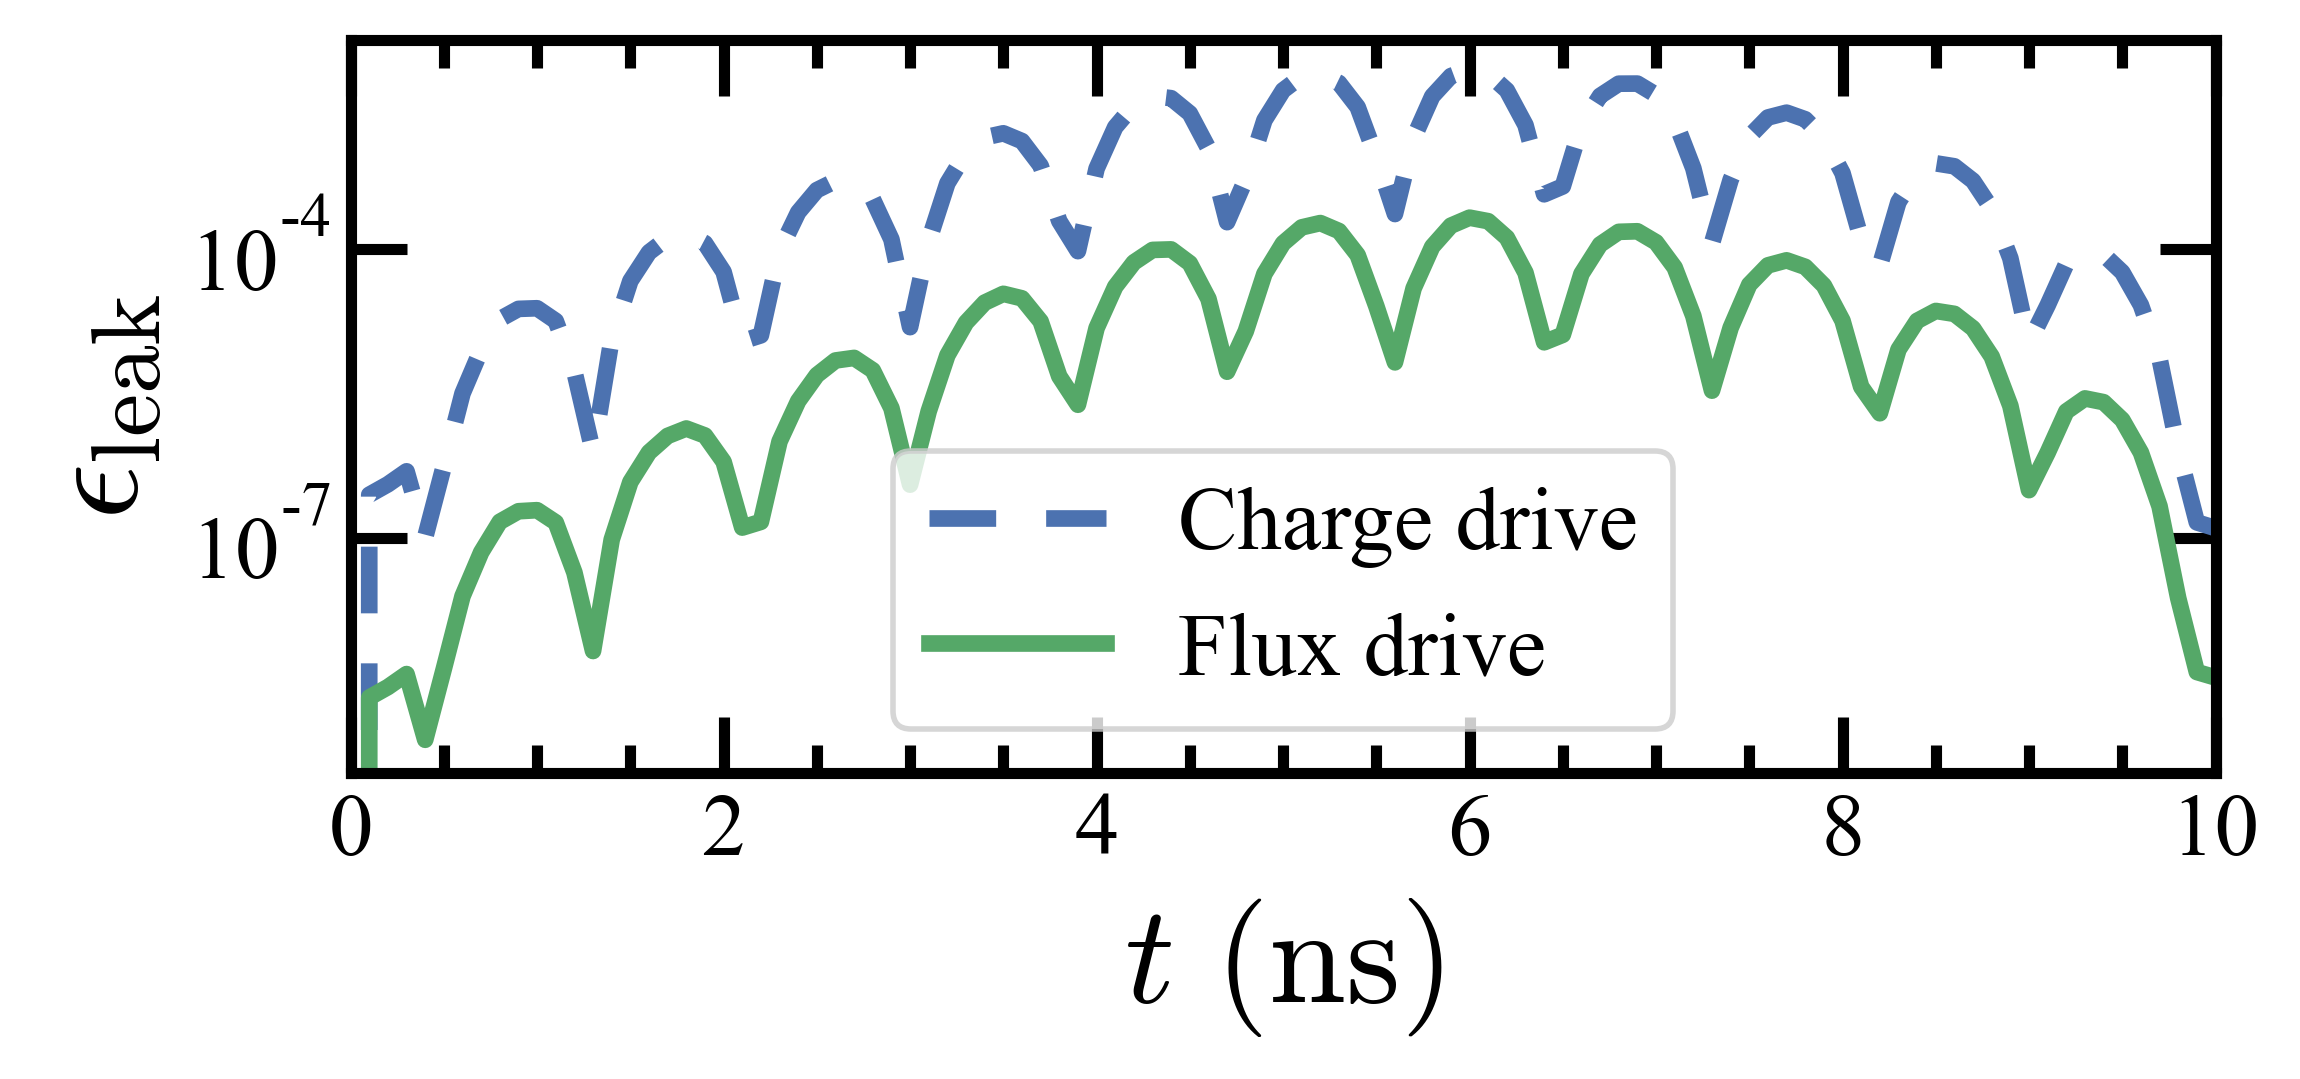

In [52]:
T_gate = 10 #ns
t_points = np.linspace(0, T_gate, 10 * int(T_gate) + 1)
plt.figure(figsize = [6,3])
plt.plot(t_points, leakage_charge,'--', label ='Charge drive')
plt.plot(t_points, leakage_flux, label ='Flux drive')
plt.yscale("log")
plt.ylabel(r'$\epsilon_\mathrm{leak}$')
plt.xlabel(r"$t~(\mathrm{ns})$")
plt.xlim([0,10])
plt.ylim([-0.001,0.015])
plt.legend()
plt.tight_layout()
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/1Q_leakage.pdf'
plt.savefig(figpath)

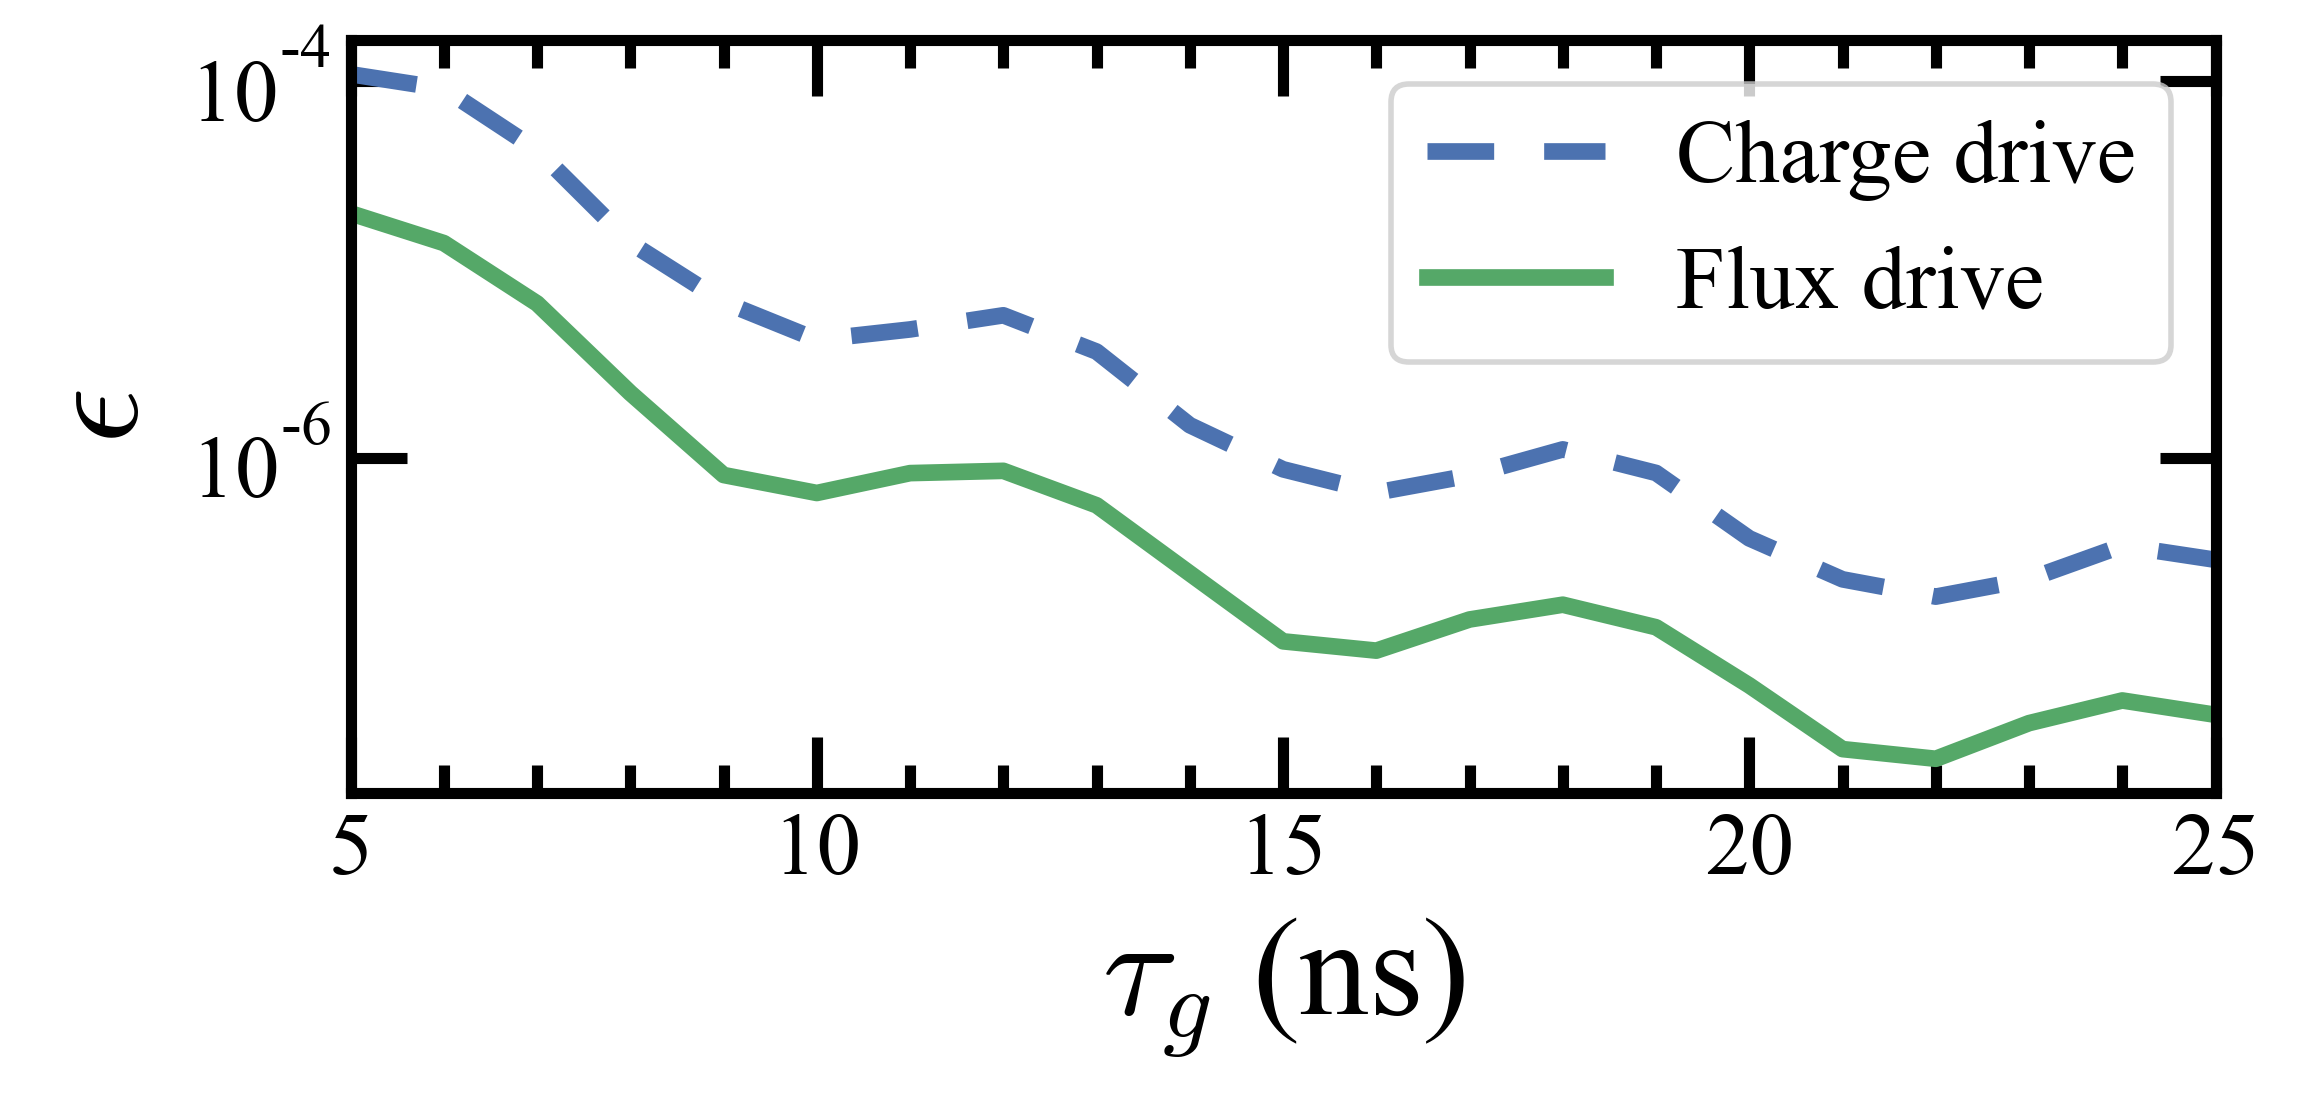

In [53]:
plt.figure(figsize = [6,3])
plt.semilogy(T_gate_array, error_array_charge,'--', label = 'Charge drive')
plt.semilogy(T_gate_array, error_array_flux,'-', label = 'Flux drive')
plt.ylabel(r'$\epsilon$')
plt.xlabel(r'$\tau_g$ (ns)')
plt.legend()
plt.xlim([5,25])
plt.tight_layout()
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/1Q_error.pdf'
plt.savefig(figpath)